## scipy image: cleaning, segmentation, etc.
[API Reference: scikit-image](https://scikit-image.org/docs/dev/api/api.html) <br>
****
[Home: scikit-image aka skimage](https://scikit-image.org/) <br>
[Documentation: scikit-image](https://scikit-image.org/docs/stable/) <br>
[scikit-image on GitHub](https://github.com/scikit-image/scikit-image) <br>
[User Guide: scikit-image](https://scikit-image.org/docs/dev/user_guide) <br>
[Founder-tutor](https://bids.berkeley.edu/resources/videos/scikit-image-image-analysis-python-intermediate) <br>
****
## OpenSlide:
[OpenSlide Wiki](https://github.com/openslide/openslide/wiki) <br>
[OpenSlide api](https://openslide.org/api/python/) <br>
[openslide github](https://github.com/openslide/openslide-python) <br>
[openslide dot org](https://openslide.org/) <br>
[openslide C docs](https://openslide.org/api/openslide_8h.html) <br>

#### Note that os.remove(full file name) must be used to remove all files before os.rmdir(directory path) will work
```python
import os
import tempfile

dirpath = tempfile.mkdtemp()
print('directory exists ? ',os.path.isdir(dirpath))
if os.path.isdir(dirpath):
    print(dirpath)
    os.rmdir(dirpath)
    print('directory still exists ? ',os.path.isdir(dirpath))
```
```bash
directory exists ?  True
/var/folders/gf/ybz3wzn55m139k_4dw2v_tvm0000gn/T/tmp8o6spky6
directory still exists ?  False
```

In [2]:
import os
import time
import glob
import math
import multiprocessing as mp
import itertools
import hashlib
import tempfile

import numpy as np
import openslide
from skimage.filters import threshold_otsu

import PIL

output_dir = '../../DigiPath_MLTK_data/out_to_test'
if os.path.isdir(output_dir) == False:
    os.makedirs(output_dir)
    
OUTPUT_PATH = output_dir
data_dir = '../../DigiPath_MLTK_data/Aperio'
files_list = ['CMU-1-Small-Region.svs', 'CMU-1.svs']
SVS = os.path.join(data_dir, files_list[0])
print('Working with file:', SVS, '\nOutput path:', OUTPUT_PATH)

Working with file: ../../DigiPath_MLTK_data/Aperio/CMU-1-Small-Region.svs 
Output path: ../../DigiPath_MLTK_data/out_to_test


In [3]:
out_dir = '../../DigiPath_MLTK_data/out_to_test'
file_types = ['.jpg']
files_list = []
for maybe_file in os.listdir(out_dir):
    full_path = os.path.join(out_dir, maybe_file)
    if os.path.isfile(full_path):
        _, f_ext = os.path.splitext(maybe_file)
        if f_ext in file_types:
            files_list.append(full_path)

print(len(files_list))

0


In [20]:
"""                                                 Detail scaling boxes usage 
                                                    overlap, padding, stride, etc
"""
#                                               initialize test variables
cell_start_time = time.time()
# True == PRINT_ALL_BOXES will make it slow
PRINT_ALL_BOXES = True
PATCH_HEIGHT = 224
PATCH_WIDTH = 224
print('%40s: %5i, %5i'%('output patch images size:',PATCH_HEIGHT, PATCH_WIDTH))
target_dir = '../../DigiPath_MLTK_data/out_to_test'
print('output directory:\n\t', os.path.abspath(target_dir))

#                                               open the file
test_file_name = os.path.join(data_dir, 'CMU-1.svs')
print('Opening Image file: \n\t{}\n'.format(test_file_name))
os_obj = openslide.OpenSlide(test_file_name)
pixels_height = os_obj.dimensions[0]
pixels_width = os_obj.dimensions[1]

print('Image size {} x {}\t{} pixels'.format(pixels_height, pixels_width, 
                                             pixels_height * pixels_width))

#                                               read the meta data
pixels_height_ds = os_obj.level_dimensions[-1][0]
pixels_width_ds = os_obj.level_dimensions[-1][1]
print('Thumb size {} x {}\t{} pixels'.format(pixels_height_ds, pixels_width_ds, 
                                             pixels_height_ds * pixels_width_ds))

#                                               find the thumbnail size ratio (need pre-trained size)
print('h, w scaling {} x {}'.format(pixels_height / pixels_height_ds, pixels_width / pixels_width_ds))
print('obj.level_downsamples', os_obj.level_downsamples)
print('obj.level_downsamples[-1]', os_obj.level_downsamples[-1])
print('obj.level_dimensions', os_obj.level_dimensions)

big_thumb = os_obj.get_thumbnail((pixels_height_ds, pixels_width_ds))
print('big_thumb stats:',type(big_thumb), big_thumb.size, big_thumb.getextrema())

#                                               make the mask
grey_thumbnail = np.array(big_thumb.convert('L'))
thresh = threshold_otsu(grey_thumbnail)
mask = np.array(grey_thumbnail) < thresh
mask_im = PIL.Image.fromarray(np.uint8(mask) * 255)
# display(mask_im)

#                                               make the grid
grid_height = pixels_height // PATCH_HEIGHT
grid_width = pixels_width // PATCH_WIDTH
print('\n%40s: %5i, %5i'%('grid size', grid_height, grid_width))

thumb_cell_height = pixels_height_ds // grid_height
thumb_cell_width = pixels_width_ds // grid_width
print('%40s: %5i, %5i'%('thumb cells',thumb_cell_height, thumb_cell_width))

#                                               make the directory
_, f_name = os.path.split(test_file_name)
f_name, f_ext = os.path.splitext(f_name)
print('directory name',f_name)

#                                               get the ndarrays of full size grid, write as type
# zoom_up_ratio, grid_height, thumb_cell_height
def get_scale_interval_dict_of_arrays(grid_size, n_pixels, zoom_up_ratio):
    """ Usage: boxes_dict = get_scale_interval_dict_of_arrays(grid_size, n_pixels, zoom_up_ratio)
    array of start end values for scaling between row or columns of two different sized images
    """
    small_scale = np.zeros((grid_size, 2))
    large_scale = np.zeros((grid_size, 2))
    for grid_elem in range(grid_size):
        small_scale[grid_elem, 0] = grid_elem * n_pixels
        small_scale[grid_elem, 1] = (grid_elem + 1) * n_pixels
        large_scale[grid_elem, :] =  small_scale[grid_elem, :] * zoom_up_ratio

    return {'small_scale': small_scale, 'large_scale': large_scale}
        
zoom_up_ratio = 16
row_boxes_dict = get_scale_interval_dict_of_arrays(grid_size=grid_height, 
                                                   n_pixels=thumb_cell_height, 
                                                   zoom_up_ratio=zoom_up_ratio)
col_boxes_dict = get_scale_interval_dict_of_arrays(grid_size=grid_width, 
                                                   n_pixels=thumb_cell_width, 
                                                   zoom_up_ratio=zoom_up_ratio)

print('\narrays creation time: %0.3f\n\n'%(time.time() - cell_start_time))
if PRINT_ALL_BOXES == True:
    for row_n in range(row_boxes_dict['small_scale'].shape[0]):
        for col_n in range(col_boxes_dict['small_scale'].shape[0]):
            print(row_boxes_dict['small_scale'][row_n,:], col_boxes_dict['small_scale'][col_n,:])
            print('\t',row_boxes_dict['large_scale'][row_n,:], col_boxes_dict['large_scale'][col_n,:])

print('\nthumb size:', pixels_height_ds, pixels_width_ds)
print('\nfull size:', pixels_height, pixels_width)

#                                               (save a list of the files)
print('\ncell run time: %0.3f'%(time.time() - cell_start_time))

               output patch images size::   224,   224
output directory:
	 /Users/mojo/git_clone/ncsa/DigiPath_MLTK_data/out_to_test
Opening Image file: 
	../../DigiPath_MLTK_data/Aperio/CMU-1.svs

Image size 46000 x 32914	1514044000 pixels
Thumb size 2875 x 2057	5913875 pixels
h, w scaling 16.0 x 16.000972289742343
obj.level_downsamples (1.0, 4.000121536217793, 16.00048614487117)
obj.level_downsamples[-1] 16.00048614487117
obj.level_dimensions ((46000, 32914), (11500, 8228), (2875, 2057))
big_thumb stats: <class 'PIL.Image.Image'> (2875, 2057) ((0, 255), (0, 255), (3, 255))

                               grid size:   205,   146
                             thumb cells:    14,    14
directory name CMU-1

arrays creation time: 0.430


[ 0. 14.] [ 0. 14.]
	 [  0. 224.] [  0. 224.]
[ 0. 14.] [14. 28.]
	 [  0. 224.] [224. 448.]
[ 0. 14.] [28. 42.]
	 [  0. 224.] [448. 672.]
[ 0. 14.] [42. 56.]
	 [  0. 224.] [672. 896.]
[ 0. 14.] [56. 70.]
	 [  0. 224.] [ 896. 1120.]
[ 0. 14.] [70. 84.]
	 [

[ 0. 14.] [2002. 2016.]
	 [  0. 224.] [32032. 32256.]
[ 0. 14.] [2016. 2030.]
	 [  0. 224.] [32256. 32480.]
[ 0. 14.] [2030. 2044.]
	 [  0. 224.] [32480. 32704.]
[14. 28.] [ 0. 14.]
	 [224. 448.] [  0. 224.]
[14. 28.] [14. 28.]
	 [224. 448.] [224. 448.]
[14. 28.] [28. 42.]
	 [224. 448.] [448. 672.]
[14. 28.] [42. 56.]
	 [224. 448.] [672. 896.]
[14. 28.] [56. 70.]
	 [224. 448.] [ 896. 1120.]
[14. 28.] [70. 84.]
	 [224. 448.] [1120. 1344.]
[14. 28.] [84. 98.]
	 [224. 448.] [1344. 1568.]
[14. 28.] [ 98. 112.]
	 [224. 448.] [1568. 1792.]
[14. 28.] [112. 126.]
	 [224. 448.] [1792. 2016.]
[14. 28.] [126. 140.]
	 [224. 448.] [2016. 2240.]
[14. 28.] [140. 154.]
	 [224. 448.] [2240. 2464.]
[14. 28.] [154. 168.]
	 [224. 448.] [2464. 2688.]
[14. 28.] [168. 182.]
	 [224. 448.] [2688. 2912.]
[14. 28.] [182. 196.]
	 [224. 448.] [2912. 3136.]
[14. 28.] [196. 210.]
	 [224. 448.] [3136. 3360.]
[14. 28.] [210. 224.]
	 [224. 448.] [3360. 3584.]
[14. 28.] [224. 238.]
	 [224. 448.] [3584. 3808.]
[14. 28.] 

[28. 42.] [1120. 1134.]
	 [448. 672.] [17920. 18144.]
[28. 42.] [1134. 1148.]
	 [448. 672.] [18144. 18368.]
[28. 42.] [1148. 1162.]
	 [448. 672.] [18368. 18592.]
[28. 42.] [1162. 1176.]
	 [448. 672.] [18592. 18816.]
[28. 42.] [1176. 1190.]
	 [448. 672.] [18816. 19040.]
[28. 42.] [1190. 1204.]
	 [448. 672.] [19040. 19264.]
[28. 42.] [1204. 1218.]
	 [448. 672.] [19264. 19488.]
[28. 42.] [1218. 1232.]
	 [448. 672.] [19488. 19712.]
[28. 42.] [1232. 1246.]
	 [448. 672.] [19712. 19936.]
[28. 42.] [1246. 1260.]
	 [448. 672.] [19936. 20160.]
[28. 42.] [1260. 1274.]
	 [448. 672.] [20160. 20384.]
[28. 42.] [1274. 1288.]
	 [448. 672.] [20384. 20608.]
[28. 42.] [1288. 1302.]
	 [448. 672.] [20608. 20832.]
[28. 42.] [1302. 1316.]
	 [448. 672.] [20832. 21056.]
[28. 42.] [1316. 1330.]
	 [448. 672.] [21056. 21280.]
[28. 42.] [1330. 1344.]
	 [448. 672.] [21280. 21504.]
[28. 42.] [1344. 1358.]
	 [448. 672.] [21504. 21728.]
[28. 42.] [1358. 1372.]
	 [448. 672.] [21728. 21952.]
[28. 42.] [1372. 1386.]
	 [4

	 [ 896. 1120.] [3808. 4032.]
[56. 70.] [252. 266.]
	 [ 896. 1120.] [4032. 4256.]
[56. 70.] [266. 280.]
	 [ 896. 1120.] [4256. 4480.]
[56. 70.] [280. 294.]
	 [ 896. 1120.] [4480. 4704.]
[56. 70.] [294. 308.]
	 [ 896. 1120.] [4704. 4928.]
[56. 70.] [308. 322.]
	 [ 896. 1120.] [4928. 5152.]
[56. 70.] [322. 336.]
	 [ 896. 1120.] [5152. 5376.]
[56. 70.] [336. 350.]
	 [ 896. 1120.] [5376. 5600.]
[56. 70.] [350. 364.]
	 [ 896. 1120.] [5600. 5824.]
[56. 70.] [364. 378.]
	 [ 896. 1120.] [5824. 6048.]
[56. 70.] [378. 392.]
	 [ 896. 1120.] [6048. 6272.]
[56. 70.] [392. 406.]
	 [ 896. 1120.] [6272. 6496.]
[56. 70.] [406. 420.]
	 [ 896. 1120.] [6496. 6720.]
[56. 70.] [420. 434.]
	 [ 896. 1120.] [6720. 6944.]
[56. 70.] [434. 448.]
	 [ 896. 1120.] [6944. 7168.]
[56. 70.] [448. 462.]
	 [ 896. 1120.] [7168. 7392.]
[56. 70.] [462. 476.]
	 [ 896. 1120.] [7392. 7616.]
[56. 70.] [476. 490.]
	 [ 896. 1120.] [7616. 7840.]
[56. 70.] [490. 504.]
	 [ 896. 1120.] [7840. 8064.]
[56. 70.] [504. 518.]
	 [ 896. 112

	 [1120. 1344.] [19488. 19712.]
[70. 84.] [1232. 1246.]
	 [1120. 1344.] [19712. 19936.]
[70. 84.] [1246. 1260.]
	 [1120. 1344.] [19936. 20160.]
[70. 84.] [1260. 1274.]
	 [1120. 1344.] [20160. 20384.]
[70. 84.] [1274. 1288.]
	 [1120. 1344.] [20384. 20608.]
[70. 84.] [1288. 1302.]
	 [1120. 1344.] [20608. 20832.]
[70. 84.] [1302. 1316.]
	 [1120. 1344.] [20832. 21056.]
[70. 84.] [1316. 1330.]
	 [1120. 1344.] [21056. 21280.]
[70. 84.] [1330. 1344.]
	 [1120. 1344.] [21280. 21504.]
[70. 84.] [1344. 1358.]
	 [1120. 1344.] [21504. 21728.]
[70. 84.] [1358. 1372.]
	 [1120. 1344.] [21728. 21952.]
[70. 84.] [1372. 1386.]
	 [1120. 1344.] [21952. 22176.]
[70. 84.] [1386. 1400.]
	 [1120. 1344.] [22176. 22400.]
[70. 84.] [1400. 1414.]
	 [1120. 1344.] [22400. 22624.]
[70. 84.] [1414. 1428.]
	 [1120. 1344.] [22624. 22848.]
[70. 84.] [1428. 1442.]
	 [1120. 1344.] [22848. 23072.]
[70. 84.] [1442. 1456.]
	 [1120. 1344.] [23072. 23296.]
[70. 84.] [1456. 1470.]
	 [1120. 1344.] [23296. 23520.]
[70. 84.] [1470.

	 [1568. 1792.] [3136. 3360.]
[ 98. 112.] [210. 224.]
	 [1568. 1792.] [3360. 3584.]
[ 98. 112.] [224. 238.]
	 [1568. 1792.] [3584. 3808.]
[ 98. 112.] [238. 252.]
	 [1568. 1792.] [3808. 4032.]
[ 98. 112.] [252. 266.]
	 [1568. 1792.] [4032. 4256.]
[ 98. 112.] [266. 280.]
	 [1568. 1792.] [4256. 4480.]
[ 98. 112.] [280. 294.]
	 [1568. 1792.] [4480. 4704.]
[ 98. 112.] [294. 308.]
	 [1568. 1792.] [4704. 4928.]
[ 98. 112.] [308. 322.]
	 [1568. 1792.] [4928. 5152.]
[ 98. 112.] [322. 336.]
	 [1568. 1792.] [5152. 5376.]
[ 98. 112.] [336. 350.]
	 [1568. 1792.] [5376. 5600.]
[ 98. 112.] [350. 364.]
	 [1568. 1792.] [5600. 5824.]
[ 98. 112.] [364. 378.]
	 [1568. 1792.] [5824. 6048.]
[ 98. 112.] [378. 392.]
	 [1568. 1792.] [6048. 6272.]
[ 98. 112.] [392. 406.]
	 [1568. 1792.] [6272. 6496.]
[ 98. 112.] [406. 420.]
	 [1568. 1792.] [6496. 6720.]
[ 98. 112.] [420. 434.]
	 [1568. 1792.] [6720. 6944.]
[ 98. 112.] [434. 448.]
	 [1568. 1792.] [6944. 7168.]
[ 98. 112.] [448. 462.]
	 [1568. 1792.] [7168. 7392.

	 [1792. 2016.] [23296. 23520.]
[112. 126.] [1470. 1484.]
	 [1792. 2016.] [23520. 23744.]
[112. 126.] [1484. 1498.]
	 [1792. 2016.] [23744. 23968.]
[112. 126.] [1498. 1512.]
	 [1792. 2016.] [23968. 24192.]
[112. 126.] [1512. 1526.]
	 [1792. 2016.] [24192. 24416.]
[112. 126.] [1526. 1540.]
	 [1792. 2016.] [24416. 24640.]
[112. 126.] [1540. 1554.]
	 [1792. 2016.] [24640. 24864.]
[112. 126.] [1554. 1568.]
	 [1792. 2016.] [24864. 25088.]
[112. 126.] [1568. 1582.]
	 [1792. 2016.] [25088. 25312.]
[112. 126.] [1582. 1596.]
	 [1792. 2016.] [25312. 25536.]
[112. 126.] [1596. 1610.]
	 [1792. 2016.] [25536. 25760.]
[112. 126.] [1610. 1624.]
	 [1792. 2016.] [25760. 25984.]
[112. 126.] [1624. 1638.]
	 [1792. 2016.] [25984. 26208.]
[112. 126.] [1638. 1652.]
	 [1792. 2016.] [26208. 26432.]
[112. 126.] [1652. 1666.]
	 [1792. 2016.] [26432. 26656.]
[112. 126.] [1666. 1680.]
	 [1792. 2016.] [26656. 26880.]
[112. 126.] [1680. 1694.]
	 [1792. 2016.] [26880. 27104.]
[112. 126.] [1694. 1708.]
	 [1792. 2016.

[140. 154.] [518. 532.]
	 [2240. 2464.] [8288. 8512.]
[140. 154.] [532. 546.]
	 [2240. 2464.] [8512. 8736.]
[140. 154.] [546. 560.]
	 [2240. 2464.] [8736. 8960.]
[140. 154.] [560. 574.]
	 [2240. 2464.] [8960. 9184.]
[140. 154.] [574. 588.]
	 [2240. 2464.] [9184. 9408.]
[140. 154.] [588. 602.]
	 [2240. 2464.] [9408. 9632.]
[140. 154.] [602. 616.]
	 [2240. 2464.] [9632. 9856.]
[140. 154.] [616. 630.]
	 [2240. 2464.] [ 9856. 10080.]
[140. 154.] [630. 644.]
	 [2240. 2464.] [10080. 10304.]
[140. 154.] [644. 658.]
	 [2240. 2464.] [10304. 10528.]
[140. 154.] [658. 672.]
	 [2240. 2464.] [10528. 10752.]
[140. 154.] [672. 686.]
	 [2240. 2464.] [10752. 10976.]
[140. 154.] [686. 700.]
	 [2240. 2464.] [10976. 11200.]
[140. 154.] [700. 714.]
	 [2240. 2464.] [11200. 11424.]
[140. 154.] [714. 728.]
	 [2240. 2464.] [11424. 11648.]
[140. 154.] [728. 742.]
	 [2240. 2464.] [11648. 11872.]
[140. 154.] [742. 756.]
	 [2240. 2464.] [11872. 12096.]
[140. 154.] [756. 770.]
	 [2240. 2464.] [12096. 12320.]
[140. 

[154. 168.] [1708. 1722.]
	 [2464. 2688.] [27328. 27552.]
[154. 168.] [1722. 1736.]
	 [2464. 2688.] [27552. 27776.]
[154. 168.] [1736. 1750.]
	 [2464. 2688.] [27776. 28000.]
[154. 168.] [1750. 1764.]
	 [2464. 2688.] [28000. 28224.]
[154. 168.] [1764. 1778.]
	 [2464. 2688.] [28224. 28448.]
[154. 168.] [1778. 1792.]
	 [2464. 2688.] [28448. 28672.]
[154. 168.] [1792. 1806.]
	 [2464. 2688.] [28672. 28896.]
[154. 168.] [1806. 1820.]
	 [2464. 2688.] [28896. 29120.]
[154. 168.] [1820. 1834.]
	 [2464. 2688.] [29120. 29344.]
[154. 168.] [1834. 1848.]
	 [2464. 2688.] [29344. 29568.]
[154. 168.] [1848. 1862.]
	 [2464. 2688.] [29568. 29792.]
[154. 168.] [1862. 1876.]
	 [2464. 2688.] [29792. 30016.]
[154. 168.] [1876. 1890.]
	 [2464. 2688.] [30016. 30240.]
[154. 168.] [1890. 1904.]
	 [2464. 2688.] [30240. 30464.]
[154. 168.] [1904. 1918.]
	 [2464. 2688.] [30464. 30688.]
[154. 168.] [1918. 1932.]
	 [2464. 2688.] [30688. 30912.]
[154. 168.] [1932. 1946.]
	 [2464. 2688.] [30912. 31136.]
[154. 168.] [1

[182. 196.] [840. 854.]
	 [2912. 3136.] [13440. 13664.]
[182. 196.] [854. 868.]
	 [2912. 3136.] [13664. 13888.]
[182. 196.] [868. 882.]
	 [2912. 3136.] [13888. 14112.]
[182. 196.] [882. 896.]
	 [2912. 3136.] [14112. 14336.]
[182. 196.] [896. 910.]
	 [2912. 3136.] [14336. 14560.]
[182. 196.] [910. 924.]
	 [2912. 3136.] [14560. 14784.]
[182. 196.] [924. 938.]
	 [2912. 3136.] [14784. 15008.]
[182. 196.] [938. 952.]
	 [2912. 3136.] [15008. 15232.]
[182. 196.] [952. 966.]
	 [2912. 3136.] [15232. 15456.]
[182. 196.] [966. 980.]
	 [2912. 3136.] [15456. 15680.]
[182. 196.] [980. 994.]
	 [2912. 3136.] [15680. 15904.]
[182. 196.] [ 994. 1008.]
	 [2912. 3136.] [15904. 16128.]
[182. 196.] [1008. 1022.]
	 [2912. 3136.] [16128. 16352.]
[182. 196.] [1022. 1036.]
	 [2912. 3136.] [16352. 16576.]
[182. 196.] [1036. 1050.]
	 [2912. 3136.] [16576. 16800.]
[182. 196.] [1050. 1064.]
	 [2912. 3136.] [16800. 17024.]
[182. 196.] [1064. 1078.]
	 [2912. 3136.] [17024. 17248.]
[182. 196.] [1078. 1092.]
	 [2912. 3

	 [3360. 3584.] [  0. 224.]
[210. 224.] [14. 28.]
	 [3360. 3584.] [224. 448.]
[210. 224.] [28. 42.]
	 [3360. 3584.] [448. 672.]
[210. 224.] [42. 56.]
	 [3360. 3584.] [672. 896.]
[210. 224.] [56. 70.]
	 [3360. 3584.] [ 896. 1120.]
[210. 224.] [70. 84.]
	 [3360. 3584.] [1120. 1344.]
[210. 224.] [84. 98.]
	 [3360. 3584.] [1344. 1568.]
[210. 224.] [ 98. 112.]
	 [3360. 3584.] [1568. 1792.]
[210. 224.] [112. 126.]
	 [3360. 3584.] [1792. 2016.]
[210. 224.] [126. 140.]
	 [3360. 3584.] [2016. 2240.]
[210. 224.] [140. 154.]
	 [3360. 3584.] [2240. 2464.]
[210. 224.] [154. 168.]
	 [3360. 3584.] [2464. 2688.]
[210. 224.] [168. 182.]
	 [3360. 3584.] [2688. 2912.]
[210. 224.] [182. 196.]
	 [3360. 3584.] [2912. 3136.]
[210. 224.] [196. 210.]
	 [3360. 3584.] [3136. 3360.]
[210. 224.] [210. 224.]
	 [3360. 3584.] [3360. 3584.]
[210. 224.] [224. 238.]
	 [3360. 3584.] [3584. 3808.]
[210. 224.] [238. 252.]
	 [3360. 3584.] [3808. 4032.]
[210. 224.] [252. 266.]
	 [3360. 3584.] [4032. 4256.]
[210. 224.] [266. 

	 [3584. 3808.] [17920. 18144.]
[224. 238.] [1134. 1148.]
	 [3584. 3808.] [18144. 18368.]
[224. 238.] [1148. 1162.]
	 [3584. 3808.] [18368. 18592.]
[224. 238.] [1162. 1176.]
	 [3584. 3808.] [18592. 18816.]
[224. 238.] [1176. 1190.]
	 [3584. 3808.] [18816. 19040.]
[224. 238.] [1190. 1204.]
	 [3584. 3808.] [19040. 19264.]
[224. 238.] [1204. 1218.]
	 [3584. 3808.] [19264. 19488.]
[224. 238.] [1218. 1232.]
	 [3584. 3808.] [19488. 19712.]
[224. 238.] [1232. 1246.]
	 [3584. 3808.] [19712. 19936.]
[224. 238.] [1246. 1260.]
	 [3584. 3808.] [19936. 20160.]
[224. 238.] [1260. 1274.]
	 [3584. 3808.] [20160. 20384.]
[224. 238.] [1274. 1288.]
	 [3584. 3808.] [20384. 20608.]
[224. 238.] [1288. 1302.]
	 [3584. 3808.] [20608. 20832.]
[224. 238.] [1302. 1316.]
	 [3584. 3808.] [20832. 21056.]
[224. 238.] [1316. 1330.]
	 [3584. 3808.] [21056. 21280.]
[224. 238.] [1330. 1344.]
	 [3584. 3808.] [21280. 21504.]
[224. 238.] [1344. 1358.]
	 [3584. 3808.] [21504. 21728.]
[224. 238.] [1358. 1372.]
	 [3584. 3808.

	 [4032. 4256.] [2912. 3136.]
[252. 266.] [196. 210.]
	 [4032. 4256.] [3136. 3360.]
[252. 266.] [210. 224.]
	 [4032. 4256.] [3360. 3584.]
[252. 266.] [224. 238.]
	 [4032. 4256.] [3584. 3808.]
[252. 266.] [238. 252.]
	 [4032. 4256.] [3808. 4032.]
[252. 266.] [252. 266.]
	 [4032. 4256.] [4032. 4256.]
[252. 266.] [266. 280.]
	 [4032. 4256.] [4256. 4480.]
[252. 266.] [280. 294.]
	 [4032. 4256.] [4480. 4704.]
[252. 266.] [294. 308.]
	 [4032. 4256.] [4704. 4928.]
[252. 266.] [308. 322.]
	 [4032. 4256.] [4928. 5152.]
[252. 266.] [322. 336.]
	 [4032. 4256.] [5152. 5376.]
[252. 266.] [336. 350.]
	 [4032. 4256.] [5376. 5600.]
[252. 266.] [350. 364.]
	 [4032. 4256.] [5600. 5824.]
[252. 266.] [364. 378.]
	 [4032. 4256.] [5824. 6048.]
[252. 266.] [378. 392.]
	 [4032. 4256.] [6048. 6272.]
[252. 266.] [392. 406.]
	 [4032. 4256.] [6272. 6496.]
[252. 266.] [406. 420.]
	 [4032. 4256.] [6496. 6720.]
[252. 266.] [420. 434.]
	 [4032. 4256.] [6720. 6944.]
[252. 266.] [434. 448.]
	 [4032. 4256.] [6944. 7168.

[266. 280.] [1442. 1456.]
	 [4256. 4480.] [23072. 23296.]
[266. 280.] [1456. 1470.]
	 [4256. 4480.] [23296. 23520.]
[266. 280.] [1470. 1484.]
	 [4256. 4480.] [23520. 23744.]
[266. 280.] [1484. 1498.]
	 [4256. 4480.] [23744. 23968.]
[266. 280.] [1498. 1512.]
	 [4256. 4480.] [23968. 24192.]
[266. 280.] [1512. 1526.]
	 [4256. 4480.] [24192. 24416.]
[266. 280.] [1526. 1540.]
	 [4256. 4480.] [24416. 24640.]
[266. 280.] [1540. 1554.]
	 [4256. 4480.] [24640. 24864.]
[266. 280.] [1554. 1568.]
	 [4256. 4480.] [24864. 25088.]
[266. 280.] [1568. 1582.]
	 [4256. 4480.] [25088. 25312.]
[266. 280.] [1582. 1596.]
	 [4256. 4480.] [25312. 25536.]
[266. 280.] [1596. 1610.]
	 [4256. 4480.] [25536. 25760.]
[266. 280.] [1610. 1624.]
	 [4256. 4480.] [25760. 25984.]
[266. 280.] [1624. 1638.]
	 [4256. 4480.] [25984. 26208.]
[266. 280.] [1638. 1652.]
	 [4256. 4480.] [26208. 26432.]
[266. 280.] [1652. 1666.]
	 [4256. 4480.] [26432. 26656.]
[266. 280.] [1666. 1680.]
	 [4256. 4480.] [26656. 26880.]
[266. 280.] [1

[294. 308.] [602. 616.]
	 [4704. 4928.] [9632. 9856.]
[294. 308.] [616. 630.]
	 [4704. 4928.] [ 9856. 10080.]
[294. 308.] [630. 644.]
	 [4704. 4928.] [10080. 10304.]
[294. 308.] [644. 658.]
	 [4704. 4928.] [10304. 10528.]
[294. 308.] [658. 672.]
	 [4704. 4928.] [10528. 10752.]
[294. 308.] [672. 686.]
	 [4704. 4928.] [10752. 10976.]
[294. 308.] [686. 700.]
	 [4704. 4928.] [10976. 11200.]
[294. 308.] [700. 714.]
	 [4704. 4928.] [11200. 11424.]
[294. 308.] [714. 728.]
	 [4704. 4928.] [11424. 11648.]
[294. 308.] [728. 742.]
	 [4704. 4928.] [11648. 11872.]
[294. 308.] [742. 756.]
	 [4704. 4928.] [11872. 12096.]
[294. 308.] [756. 770.]
	 [4704. 4928.] [12096. 12320.]
[294. 308.] [770. 784.]
	 [4704. 4928.] [12320. 12544.]
[294. 308.] [784. 798.]
	 [4704. 4928.] [12544. 12768.]
[294. 308.] [798. 812.]
	 [4704. 4928.] [12768. 12992.]
[294. 308.] [812. 826.]
	 [4704. 4928.] [12992. 13216.]
[294. 308.] [826. 840.]
	 [4704. 4928.] [13216. 13440.]
[294. 308.] [840. 854.]
	 [4704. 4928.] [13440. 13

	 [4928. 5152.] [28672. 28896.]
[308. 322.] [1806. 1820.]
	 [4928. 5152.] [28896. 29120.]
[308. 322.] [1820. 1834.]
	 [4928. 5152.] [29120. 29344.]
[308. 322.] [1834. 1848.]
	 [4928. 5152.] [29344. 29568.]
[308. 322.] [1848. 1862.]
	 [4928. 5152.] [29568. 29792.]
[308. 322.] [1862. 1876.]
	 [4928. 5152.] [29792. 30016.]
[308. 322.] [1876. 1890.]
	 [4928. 5152.] [30016. 30240.]
[308. 322.] [1890. 1904.]
	 [4928. 5152.] [30240. 30464.]
[308. 322.] [1904. 1918.]
	 [4928. 5152.] [30464. 30688.]
[308. 322.] [1918. 1932.]
	 [4928. 5152.] [30688. 30912.]
[308. 322.] [1932. 1946.]
	 [4928. 5152.] [30912. 31136.]
[308. 322.] [1946. 1960.]
	 [4928. 5152.] [31136. 31360.]
[308. 322.] [1960. 1974.]
	 [4928. 5152.] [31360. 31584.]
[308. 322.] [1974. 1988.]
	 [4928. 5152.] [31584. 31808.]
[308. 322.] [1988. 2002.]
	 [4928. 5152.] [31808. 32032.]
[308. 322.] [2002. 2016.]
	 [4928. 5152.] [32032. 32256.]
[308. 322.] [2016. 2030.]
	 [4928. 5152.] [32256. 32480.]
[308. 322.] [2030. 2044.]
	 [4928. 5152.

	 [5376. 5600.] [13888. 14112.]
[336. 350.] [882. 896.]
	 [5376. 5600.] [14112. 14336.]
[336. 350.] [896. 910.]
	 [5376. 5600.] [14336. 14560.]
[336. 350.] [910. 924.]
	 [5376. 5600.] [14560. 14784.]
[336. 350.] [924. 938.]
	 [5376. 5600.] [14784. 15008.]
[336. 350.] [938. 952.]
	 [5376. 5600.] [15008. 15232.]
[336. 350.] [952. 966.]
	 [5376. 5600.] [15232. 15456.]
[336. 350.] [966. 980.]
	 [5376. 5600.] [15456. 15680.]
[336. 350.] [980. 994.]
	 [5376. 5600.] [15680. 15904.]
[336. 350.] [ 994. 1008.]
	 [5376. 5600.] [15904. 16128.]
[336. 350.] [1008. 1022.]
	 [5376. 5600.] [16128. 16352.]
[336. 350.] [1022. 1036.]
	 [5376. 5600.] [16352. 16576.]
[336. 350.] [1036. 1050.]
	 [5376. 5600.] [16576. 16800.]
[336. 350.] [1050. 1064.]
	 [5376. 5600.] [16800. 17024.]
[336. 350.] [1064. 1078.]
	 [5376. 5600.] [17024. 17248.]
[336. 350.] [1078. 1092.]
	 [5376. 5600.] [17248. 17472.]
[336. 350.] [1092. 1106.]
	 [5376. 5600.] [17472. 17696.]
[336. 350.] [1106. 1120.]
	 [5376. 5600.] [17696. 17920.

[364. 378.] [28. 42.]
	 [5824. 6048.] [448. 672.]
[364. 378.] [42. 56.]
	 [5824. 6048.] [672. 896.]
[364. 378.] [56. 70.]
	 [5824. 6048.] [ 896. 1120.]
[364. 378.] [70. 84.]
	 [5824. 6048.] [1120. 1344.]
[364. 378.] [84. 98.]
	 [5824. 6048.] [1344. 1568.]
[364. 378.] [ 98. 112.]
	 [5824. 6048.] [1568. 1792.]
[364. 378.] [112. 126.]
	 [5824. 6048.] [1792. 2016.]
[364. 378.] [126. 140.]
	 [5824. 6048.] [2016. 2240.]
[364. 378.] [140. 154.]
	 [5824. 6048.] [2240. 2464.]
[364. 378.] [154. 168.]
	 [5824. 6048.] [2464. 2688.]
[364. 378.] [168. 182.]
	 [5824. 6048.] [2688. 2912.]
[364. 378.] [182. 196.]
	 [5824. 6048.] [2912. 3136.]
[364. 378.] [196. 210.]
	 [5824. 6048.] [3136. 3360.]
[364. 378.] [210. 224.]
	 [5824. 6048.] [3360. 3584.]
[364. 378.] [224. 238.]
	 [5824. 6048.] [3584. 3808.]
[364. 378.] [238. 252.]
	 [5824. 6048.] [3808. 4032.]
[364. 378.] [252. 266.]
	 [5824. 6048.] [4032. 4256.]
[364. 378.] [266. 280.]
	 [5824. 6048.] [4256. 4480.]
[364. 378.] [280. 294.]
	 [5824. 6048.] [4

	 [6048. 6272.] [18368. 18592.]
[378. 392.] [1162. 1176.]
	 [6048. 6272.] [18592. 18816.]
[378. 392.] [1176. 1190.]
	 [6048. 6272.] [18816. 19040.]
[378. 392.] [1190. 1204.]
	 [6048. 6272.] [19040. 19264.]
[378. 392.] [1204. 1218.]
	 [6048. 6272.] [19264. 19488.]
[378. 392.] [1218. 1232.]
	 [6048. 6272.] [19488. 19712.]
[378. 392.] [1232. 1246.]
	 [6048. 6272.] [19712. 19936.]
[378. 392.] [1246. 1260.]
	 [6048. 6272.] [19936. 20160.]
[378. 392.] [1260. 1274.]
	 [6048. 6272.] [20160. 20384.]
[378. 392.] [1274. 1288.]
	 [6048. 6272.] [20384. 20608.]
[378. 392.] [1288. 1302.]
	 [6048. 6272.] [20608. 20832.]
[378. 392.] [1302. 1316.]
	 [6048. 6272.] [20832. 21056.]
[378. 392.] [1316. 1330.]
	 [6048. 6272.] [21056. 21280.]
[378. 392.] [1330. 1344.]
	 [6048. 6272.] [21280. 21504.]
[378. 392.] [1344. 1358.]
	 [6048. 6272.] [21504. 21728.]
[378. 392.] [1358. 1372.]
	 [6048. 6272.] [21728. 21952.]
[378. 392.] [1372. 1386.]
	 [6048. 6272.] [21952. 22176.]
[378. 392.] [1386. 1400.]
	 [6048. 6272.

	 [6496. 6720.] [4928. 5152.]
[406. 420.] [322. 336.]
	 [6496. 6720.] [5152. 5376.]
[406. 420.] [336. 350.]
	 [6496. 6720.] [5376. 5600.]
[406. 420.] [350. 364.]
	 [6496. 6720.] [5600. 5824.]
[406. 420.] [364. 378.]
	 [6496. 6720.] [5824. 6048.]
[406. 420.] [378. 392.]
	 [6496. 6720.] [6048. 6272.]
[406. 420.] [392. 406.]
	 [6496. 6720.] [6272. 6496.]
[406. 420.] [406. 420.]
	 [6496. 6720.] [6496. 6720.]
[406. 420.] [420. 434.]
	 [6496. 6720.] [6720. 6944.]
[406. 420.] [434. 448.]
	 [6496. 6720.] [6944. 7168.]
[406. 420.] [448. 462.]
	 [6496. 6720.] [7168. 7392.]
[406. 420.] [462. 476.]
	 [6496. 6720.] [7392. 7616.]
[406. 420.] [476. 490.]
	 [6496. 6720.] [7616. 7840.]
[406. 420.] [490. 504.]
	 [6496. 6720.] [7840. 8064.]
[406. 420.] [504. 518.]
	 [6496. 6720.] [8064. 8288.]
[406. 420.] [518. 532.]
	 [6496. 6720.] [8288. 8512.]
[406. 420.] [532. 546.]
	 [6496. 6720.] [8512. 8736.]
[406. 420.] [546. 560.]
	 [6496. 6720.] [8736. 8960.]
[406. 420.] [560. 574.]
	 [6496. 6720.] [8960. 9184.

	 [6720. 6944.] [23968. 24192.]
[420. 434.] [1512. 1526.]
	 [6720. 6944.] [24192. 24416.]
[420. 434.] [1526. 1540.]
	 [6720. 6944.] [24416. 24640.]
[420. 434.] [1540. 1554.]
	 [6720. 6944.] [24640. 24864.]
[420. 434.] [1554. 1568.]
	 [6720. 6944.] [24864. 25088.]
[420. 434.] [1568. 1582.]
	 [6720. 6944.] [25088. 25312.]
[420. 434.] [1582. 1596.]
	 [6720. 6944.] [25312. 25536.]
[420. 434.] [1596. 1610.]
	 [6720. 6944.] [25536. 25760.]
[420. 434.] [1610. 1624.]
	 [6720. 6944.] [25760. 25984.]
[420. 434.] [1624. 1638.]
	 [6720. 6944.] [25984. 26208.]
[420. 434.] [1638. 1652.]
	 [6720. 6944.] [26208. 26432.]
[420. 434.] [1652. 1666.]
	 [6720. 6944.] [26432. 26656.]
[420. 434.] [1666. 1680.]
	 [6720. 6944.] [26656. 26880.]
[420. 434.] [1680. 1694.]
	 [6720. 6944.] [26880. 27104.]
[420. 434.] [1694. 1708.]
	 [6720. 6944.] [27104. 27328.]
[420. 434.] [1708. 1722.]
	 [6720. 6944.] [27328. 27552.]
[420. 434.] [1722. 1736.]
	 [6720. 6944.] [27552. 27776.]
[420. 434.] [1736. 1750.]
	 [6720. 6944.

	 [7168. 7392.] [10304. 10528.]
[448. 462.] [658. 672.]
	 [7168. 7392.] [10528. 10752.]
[448. 462.] [672. 686.]
	 [7168. 7392.] [10752. 10976.]
[448. 462.] [686. 700.]
	 [7168. 7392.] [10976. 11200.]
[448. 462.] [700. 714.]
	 [7168. 7392.] [11200. 11424.]
[448. 462.] [714. 728.]
	 [7168. 7392.] [11424. 11648.]
[448. 462.] [728. 742.]
	 [7168. 7392.] [11648. 11872.]
[448. 462.] [742. 756.]
	 [7168. 7392.] [11872. 12096.]
[448. 462.] [756. 770.]
	 [7168. 7392.] [12096. 12320.]
[448. 462.] [770. 784.]
	 [7168. 7392.] [12320. 12544.]
[448. 462.] [784. 798.]
	 [7168. 7392.] [12544. 12768.]
[448. 462.] [798. 812.]
	 [7168. 7392.] [12768. 12992.]
[448. 462.] [812. 826.]
	 [7168. 7392.] [12992. 13216.]
[448. 462.] [826. 840.]
	 [7168. 7392.] [13216. 13440.]
[448. 462.] [840. 854.]
	 [7168. 7392.] [13440. 13664.]
[448. 462.] [854. 868.]
	 [7168. 7392.] [13664. 13888.]
[448. 462.] [868. 882.]
	 [7168. 7392.] [13888. 14112.]
[448. 462.] [882. 896.]
	 [7168. 7392.] [14112. 14336.]
[448. 462.] [896

[462. 476.] [1540. 1554.]
	 [7392. 7616.] [24640. 24864.]
[462. 476.] [1554. 1568.]
	 [7392. 7616.] [24864. 25088.]
[462. 476.] [1568. 1582.]
	 [7392. 7616.] [25088. 25312.]
[462. 476.] [1582. 1596.]
	 [7392. 7616.] [25312. 25536.]
[462. 476.] [1596. 1610.]
	 [7392. 7616.] [25536. 25760.]
[462. 476.] [1610. 1624.]
	 [7392. 7616.] [25760. 25984.]
[462. 476.] [1624. 1638.]
	 [7392. 7616.] [25984. 26208.]
[462. 476.] [1638. 1652.]
	 [7392. 7616.] [26208. 26432.]
[462. 476.] [1652. 1666.]
	 [7392. 7616.] [26432. 26656.]
[462. 476.] [1666. 1680.]
	 [7392. 7616.] [26656. 26880.]
[462. 476.] [1680. 1694.]
	 [7392. 7616.] [26880. 27104.]
[462. 476.] [1694. 1708.]
	 [7392. 7616.] [27104. 27328.]
[462. 476.] [1708. 1722.]
	 [7392. 7616.] [27328. 27552.]
[462. 476.] [1722. 1736.]
	 [7392. 7616.] [27552. 27776.]
[462. 476.] [1736. 1750.]
	 [7392. 7616.] [27776. 28000.]
[462. 476.] [1750. 1764.]
	 [7392. 7616.] [28000. 28224.]
[462. 476.] [1764. 1778.]
	 [7392. 7616.] [28224. 28448.]
[462. 476.] [1

	 [7840. 8064.] [10080. 10304.]
[490. 504.] [644. 658.]
	 [7840. 8064.] [10304. 10528.]
[490. 504.] [658. 672.]
	 [7840. 8064.] [10528. 10752.]
[490. 504.] [672. 686.]
	 [7840. 8064.] [10752. 10976.]
[490. 504.] [686. 700.]
	 [7840. 8064.] [10976. 11200.]
[490. 504.] [700. 714.]
	 [7840. 8064.] [11200. 11424.]
[490. 504.] [714. 728.]
	 [7840. 8064.] [11424. 11648.]
[490. 504.] [728. 742.]
	 [7840. 8064.] [11648. 11872.]
[490. 504.] [742. 756.]
	 [7840. 8064.] [11872. 12096.]
[490. 504.] [756. 770.]
	 [7840. 8064.] [12096. 12320.]
[490. 504.] [770. 784.]
	 [7840. 8064.] [12320. 12544.]
[490. 504.] [784. 798.]
	 [7840. 8064.] [12544. 12768.]
[490. 504.] [798. 812.]
	 [7840. 8064.] [12768. 12992.]
[490. 504.] [812. 826.]
	 [7840. 8064.] [12992. 13216.]
[490. 504.] [826. 840.]
	 [7840. 8064.] [13216. 13440.]
[490. 504.] [840. 854.]
	 [7840. 8064.] [13440. 13664.]
[490. 504.] [854. 868.]
	 [7840. 8064.] [13664. 13888.]
[490. 504.] [868. 882.]
	 [7840. 8064.] [13888. 14112.]
[490. 504.] [882

	 [8064. 8288.] [28224. 28448.]
[504. 518.] [1778. 1792.]
	 [8064. 8288.] [28448. 28672.]
[504. 518.] [1792. 1806.]
	 [8064. 8288.] [28672. 28896.]
[504. 518.] [1806. 1820.]
	 [8064. 8288.] [28896. 29120.]
[504. 518.] [1820. 1834.]
	 [8064. 8288.] [29120. 29344.]
[504. 518.] [1834. 1848.]
	 [8064. 8288.] [29344. 29568.]
[504. 518.] [1848. 1862.]
	 [8064. 8288.] [29568. 29792.]
[504. 518.] [1862. 1876.]
	 [8064. 8288.] [29792. 30016.]
[504. 518.] [1876. 1890.]
	 [8064. 8288.] [30016. 30240.]
[504. 518.] [1890. 1904.]
	 [8064. 8288.] [30240. 30464.]
[504. 518.] [1904. 1918.]
	 [8064. 8288.] [30464. 30688.]
[504. 518.] [1918. 1932.]
	 [8064. 8288.] [30688. 30912.]
[504. 518.] [1932. 1946.]
	 [8064. 8288.] [30912. 31136.]
[504. 518.] [1946. 1960.]
	 [8064. 8288.] [31136. 31360.]
[504. 518.] [1960. 1974.]
	 [8064. 8288.] [31360. 31584.]
[504. 518.] [1974. 1988.]
	 [8064. 8288.] [31584. 31808.]
[504. 518.] [1988. 2002.]
	 [8064. 8288.] [31808. 32032.]
[504. 518.] [2002. 2016.]
	 [8064. 8288.

	 [8512. 8736.] [14560. 14784.]
[532. 546.] [924. 938.]
	 [8512. 8736.] [14784. 15008.]
[532. 546.] [938. 952.]
	 [8512. 8736.] [15008. 15232.]
[532. 546.] [952. 966.]
	 [8512. 8736.] [15232. 15456.]
[532. 546.] [966. 980.]
	 [8512. 8736.] [15456. 15680.]
[532. 546.] [980. 994.]
	 [8512. 8736.] [15680. 15904.]
[532. 546.] [ 994. 1008.]
	 [8512. 8736.] [15904. 16128.]
[532. 546.] [1008. 1022.]
	 [8512. 8736.] [16128. 16352.]
[532. 546.] [1022. 1036.]
	 [8512. 8736.] [16352. 16576.]
[532. 546.] [1036. 1050.]
	 [8512. 8736.] [16576. 16800.]
[532. 546.] [1050. 1064.]
	 [8512. 8736.] [16800. 17024.]
[532. 546.] [1064. 1078.]
	 [8512. 8736.] [17024. 17248.]
[532. 546.] [1078. 1092.]
	 [8512. 8736.] [17248. 17472.]
[532. 546.] [1092. 1106.]
	 [8512. 8736.] [17472. 17696.]
[532. 546.] [1106. 1120.]
	 [8512. 8736.] [17696. 17920.]
[532. 546.] [1120. 1134.]
	 [8512. 8736.] [17920. 18144.]
[532. 546.] [1134. 1148.]
	 [8512. 8736.] [18144. 18368.]
[532. 546.] [1148. 1162.]
	 [8512. 8736.] [18368. 

	 [8960. 9184.] [  0. 224.]
[560. 574.] [14. 28.]
	 [8960. 9184.] [224. 448.]
[560. 574.] [28. 42.]
	 [8960. 9184.] [448. 672.]
[560. 574.] [42. 56.]
	 [8960. 9184.] [672. 896.]
[560. 574.] [56. 70.]
	 [8960. 9184.] [ 896. 1120.]
[560. 574.] [70. 84.]
	 [8960. 9184.] [1120. 1344.]
[560. 574.] [84. 98.]
	 [8960. 9184.] [1344. 1568.]
[560. 574.] [ 98. 112.]
	 [8960. 9184.] [1568. 1792.]
[560. 574.] [112. 126.]
	 [8960. 9184.] [1792. 2016.]
[560. 574.] [126. 140.]
	 [8960. 9184.] [2016. 2240.]
[560. 574.] [140. 154.]
	 [8960. 9184.] [2240. 2464.]
[560. 574.] [154. 168.]
	 [8960. 9184.] [2464. 2688.]
[560. 574.] [168. 182.]
	 [8960. 9184.] [2688. 2912.]
[560. 574.] [182. 196.]
	 [8960. 9184.] [2912. 3136.]
[560. 574.] [196. 210.]
	 [8960. 9184.] [3136. 3360.]
[560. 574.] [210. 224.]
	 [8960. 9184.] [3360. 3584.]
[560. 574.] [224. 238.]
	 [8960. 9184.] [3584. 3808.]
[560. 574.] [238. 252.]
	 [8960. 9184.] [3808. 4032.]
[560. 574.] [252. 266.]
	 [8960. 9184.] [4032. 4256.]
[560. 574.] [266. 

	 [9184. 9408.] [16576. 16800.]
[574. 588.] [1050. 1064.]
	 [9184. 9408.] [16800. 17024.]
[574. 588.] [1064. 1078.]
	 [9184. 9408.] [17024. 17248.]
[574. 588.] [1078. 1092.]
	 [9184. 9408.] [17248. 17472.]
[574. 588.] [1092. 1106.]
	 [9184. 9408.] [17472. 17696.]
[574. 588.] [1106. 1120.]
	 [9184. 9408.] [17696. 17920.]
[574. 588.] [1120. 1134.]
	 [9184. 9408.] [17920. 18144.]
[574. 588.] [1134. 1148.]
	 [9184. 9408.] [18144. 18368.]
[574. 588.] [1148. 1162.]
	 [9184. 9408.] [18368. 18592.]
[574. 588.] [1162. 1176.]
	 [9184. 9408.] [18592. 18816.]
[574. 588.] [1176. 1190.]
	 [9184. 9408.] [18816. 19040.]
[574. 588.] [1190. 1204.]
	 [9184. 9408.] [19040. 19264.]
[574. 588.] [1204. 1218.]
	 [9184. 9408.] [19264. 19488.]
[574. 588.] [1218. 1232.]
	 [9184. 9408.] [19488. 19712.]
[574. 588.] [1232. 1246.]
	 [9184. 9408.] [19712. 19936.]
[574. 588.] [1246. 1260.]
	 [9184. 9408.] [19936. 20160.]
[574. 588.] [1260. 1274.]
	 [9184. 9408.] [20160. 20384.]
[574. 588.] [1274. 1288.]
	 [9184. 9408.

[602. 616.] [168. 182.]
	 [9632. 9856.] [2688. 2912.]
[602. 616.] [182. 196.]
	 [9632. 9856.] [2912. 3136.]
[602. 616.] [196. 210.]
	 [9632. 9856.] [3136. 3360.]
[602. 616.] [210. 224.]
	 [9632. 9856.] [3360. 3584.]
[602. 616.] [224. 238.]
	 [9632. 9856.] [3584. 3808.]
[602. 616.] [238. 252.]
	 [9632. 9856.] [3808. 4032.]
[602. 616.] [252. 266.]
	 [9632. 9856.] [4032. 4256.]
[602. 616.] [266. 280.]
	 [9632. 9856.] [4256. 4480.]
[602. 616.] [280. 294.]
	 [9632. 9856.] [4480. 4704.]
[602. 616.] [294. 308.]
	 [9632. 9856.] [4704. 4928.]
[602. 616.] [308. 322.]
	 [9632. 9856.] [4928. 5152.]
[602. 616.] [322. 336.]
	 [9632. 9856.] [5152. 5376.]
[602. 616.] [336. 350.]
	 [9632. 9856.] [5376. 5600.]
[602. 616.] [350. 364.]
	 [9632. 9856.] [5600. 5824.]
[602. 616.] [364. 378.]
	 [9632. 9856.] [5824. 6048.]
[602. 616.] [378. 392.]
	 [9632. 9856.] [6048. 6272.]
[602. 616.] [392. 406.]
	 [9632. 9856.] [6272. 6496.]
[602. 616.] [406. 420.]
	 [9632. 9856.] [6496. 6720.]
[602. 616.] [420. 434.]
	 [9

[616. 630.] [1036. 1050.]
	 [ 9856. 10080.] [16576. 16800.]
[616. 630.] [1050. 1064.]
	 [ 9856. 10080.] [16800. 17024.]
[616. 630.] [1064. 1078.]
	 [ 9856. 10080.] [17024. 17248.]
[616. 630.] [1078. 1092.]
	 [ 9856. 10080.] [17248. 17472.]
[616. 630.] [1092. 1106.]
	 [ 9856. 10080.] [17472. 17696.]
[616. 630.] [1106. 1120.]
	 [ 9856. 10080.] [17696. 17920.]
[616. 630.] [1120. 1134.]
	 [ 9856. 10080.] [17920. 18144.]
[616. 630.] [1134. 1148.]
	 [ 9856. 10080.] [18144. 18368.]
[616. 630.] [1148. 1162.]
	 [ 9856. 10080.] [18368. 18592.]
[616. 630.] [1162. 1176.]
	 [ 9856. 10080.] [18592. 18816.]
[616. 630.] [1176. 1190.]
	 [ 9856. 10080.] [18816. 19040.]
[616. 630.] [1190. 1204.]
	 [ 9856. 10080.] [19040. 19264.]
[616. 630.] [1204. 1218.]
	 [ 9856. 10080.] [19264. 19488.]
[616. 630.] [1218. 1232.]
	 [ 9856. 10080.] [19488. 19712.]
[616. 630.] [1232. 1246.]
	 [ 9856. 10080.] [19712. 19936.]
[616. 630.] [1246. 1260.]
	 [ 9856. 10080.] [19936. 20160.]
[616. 630.] [1260. 1274.]
	 [ 9856. 1008

	 [10080. 10304.] [28896. 29120.]
[630. 644.] [1820. 1834.]
	 [10080. 10304.] [29120. 29344.]
[630. 644.] [1834. 1848.]
	 [10080. 10304.] [29344. 29568.]
[630. 644.] [1848. 1862.]
	 [10080. 10304.] [29568. 29792.]
[630. 644.] [1862. 1876.]
	 [10080. 10304.] [29792. 30016.]
[630. 644.] [1876. 1890.]
	 [10080. 10304.] [30016. 30240.]
[630. 644.] [1890. 1904.]
	 [10080. 10304.] [30240. 30464.]
[630. 644.] [1904. 1918.]
	 [10080. 10304.] [30464. 30688.]
[630. 644.] [1918. 1932.]
	 [10080. 10304.] [30688. 30912.]
[630. 644.] [1932. 1946.]
	 [10080. 10304.] [30912. 31136.]
[630. 644.] [1946. 1960.]
	 [10080. 10304.] [31136. 31360.]
[630. 644.] [1960. 1974.]
	 [10080. 10304.] [31360. 31584.]
[630. 644.] [1974. 1988.]
	 [10080. 10304.] [31584. 31808.]
[630. 644.] [1988. 2002.]
	 [10080. 10304.] [31808. 32032.]
[630. 644.] [2002. 2016.]
	 [10080. 10304.] [32032. 32256.]
[630. 644.] [2016. 2030.]
	 [10080. 10304.] [32256. 32480.]
[630. 644.] [2030. 2044.]
	 [10080. 10304.] [32480. 32704.]
[644. 

[658. 672.] [ 994. 1008.]
	 [10528. 10752.] [15904. 16128.]
[658. 672.] [1008. 1022.]
	 [10528. 10752.] [16128. 16352.]
[658. 672.] [1022. 1036.]
	 [10528. 10752.] [16352. 16576.]
[658. 672.] [1036. 1050.]
	 [10528. 10752.] [16576. 16800.]
[658. 672.] [1050. 1064.]
	 [10528. 10752.] [16800. 17024.]
[658. 672.] [1064. 1078.]
	 [10528. 10752.] [17024. 17248.]
[658. 672.] [1078. 1092.]
	 [10528. 10752.] [17248. 17472.]
[658. 672.] [1092. 1106.]
	 [10528. 10752.] [17472. 17696.]
[658. 672.] [1106. 1120.]
	 [10528. 10752.] [17696. 17920.]
[658. 672.] [1120. 1134.]
	 [10528. 10752.] [17920. 18144.]
[658. 672.] [1134. 1148.]
	 [10528. 10752.] [18144. 18368.]
[658. 672.] [1148. 1162.]
	 [10528. 10752.] [18368. 18592.]
[658. 672.] [1162. 1176.]
	 [10528. 10752.] [18592. 18816.]
[658. 672.] [1176. 1190.]
	 [10528. 10752.] [18816. 19040.]
[658. 672.] [1190. 1204.]
	 [10528. 10752.] [19040. 19264.]
[658. 672.] [1204. 1218.]
	 [10528. 10752.] [19264. 19488.]
[658. 672.] [1218. 1232.]
	 [10528. 1075

	 [10976. 11200.] [672. 896.]
[686. 700.] [56. 70.]
	 [10976. 11200.] [ 896. 1120.]
[686. 700.] [70. 84.]
	 [10976. 11200.] [1120. 1344.]
[686. 700.] [84. 98.]
	 [10976. 11200.] [1344. 1568.]
[686. 700.] [ 98. 112.]
	 [10976. 11200.] [1568. 1792.]
[686. 700.] [112. 126.]
	 [10976. 11200.] [1792. 2016.]
[686. 700.] [126. 140.]
	 [10976. 11200.] [2016. 2240.]
[686. 700.] [140. 154.]
	 [10976. 11200.] [2240. 2464.]
[686. 700.] [154. 168.]
	 [10976. 11200.] [2464. 2688.]
[686. 700.] [168. 182.]
	 [10976. 11200.] [2688. 2912.]
[686. 700.] [182. 196.]
	 [10976. 11200.] [2912. 3136.]
[686. 700.] [196. 210.]
	 [10976. 11200.] [3136. 3360.]
[686. 700.] [210. 224.]
	 [10976. 11200.] [3360. 3584.]
[686. 700.] [224. 238.]
	 [10976. 11200.] [3584. 3808.]
[686. 700.] [238. 252.]
	 [10976. 11200.] [3808. 4032.]
[686. 700.] [252. 266.]
	 [10976. 11200.] [4032. 4256.]
[686. 700.] [266. 280.]
	 [10976. 11200.] [4256. 4480.]
[686. 700.] [280. 294.]
	 [10976. 11200.] [4480. 4704.]
[686. 700.] [294. 308.]


[700. 714.] [1036. 1050.]
	 [11200. 11424.] [16576. 16800.]
[700. 714.] [1050. 1064.]
	 [11200. 11424.] [16800. 17024.]
[700. 714.] [1064. 1078.]
	 [11200. 11424.] [17024. 17248.]
[700. 714.] [1078. 1092.]
	 [11200. 11424.] [17248. 17472.]
[700. 714.] [1092. 1106.]
	 [11200. 11424.] [17472. 17696.]
[700. 714.] [1106. 1120.]
	 [11200. 11424.] [17696. 17920.]
[700. 714.] [1120. 1134.]
	 [11200. 11424.] [17920. 18144.]
[700. 714.] [1134. 1148.]
	 [11200. 11424.] [18144. 18368.]
[700. 714.] [1148. 1162.]
	 [11200. 11424.] [18368. 18592.]
[700. 714.] [1162. 1176.]
	 [11200. 11424.] [18592. 18816.]
[700. 714.] [1176. 1190.]
	 [11200. 11424.] [18816. 19040.]
[700. 714.] [1190. 1204.]
	 [11200. 11424.] [19040. 19264.]
[700. 714.] [1204. 1218.]
	 [11200. 11424.] [19264. 19488.]
[700. 714.] [1218. 1232.]
	 [11200. 11424.] [19488. 19712.]
[700. 714.] [1232. 1246.]
	 [11200. 11424.] [19712. 19936.]
[700. 714.] [1246. 1260.]
	 [11200. 11424.] [19936. 20160.]
[700. 714.] [1260. 1274.]
	 [11200. 1142

[714. 728.] [1946. 1960.]
	 [11424. 11648.] [31136. 31360.]
[714. 728.] [1960. 1974.]
	 [11424. 11648.] [31360. 31584.]
[714. 728.] [1974. 1988.]
	 [11424. 11648.] [31584. 31808.]
[714. 728.] [1988. 2002.]
	 [11424. 11648.] [31808. 32032.]
[714. 728.] [2002. 2016.]
	 [11424. 11648.] [32032. 32256.]
[714. 728.] [2016. 2030.]
	 [11424. 11648.] [32256. 32480.]
[714. 728.] [2030. 2044.]
	 [11424. 11648.] [32480. 32704.]
[728. 742.] [ 0. 14.]
	 [11648. 11872.] [  0. 224.]
[728. 742.] [14. 28.]
	 [11648. 11872.] [224. 448.]
[728. 742.] [28. 42.]
	 [11648. 11872.] [448. 672.]
[728. 742.] [42. 56.]
	 [11648. 11872.] [672. 896.]
[728. 742.] [56. 70.]
	 [11648. 11872.] [ 896. 1120.]
[728. 742.] [70. 84.]
	 [11648. 11872.] [1120. 1344.]
[728. 742.] [84. 98.]
	 [11648. 11872.] [1344. 1568.]
[728. 742.] [ 98. 112.]
	 [11648. 11872.] [1568. 1792.]
[728. 742.] [112. 126.]
	 [11648. 11872.] [1792. 2016.]
[728. 742.] [126. 140.]
	 [11648. 11872.] [2016. 2240.]
[728. 742.] [140. 154.]
	 [11648. 11872.] 

	 [11872. 12096.] [15232. 15456.]
[742. 756.] [966. 980.]
	 [11872. 12096.] [15456. 15680.]
[742. 756.] [980. 994.]
	 [11872. 12096.] [15680. 15904.]
[742. 756.] [ 994. 1008.]
	 [11872. 12096.] [15904. 16128.]
[742. 756.] [1008. 1022.]
	 [11872. 12096.] [16128. 16352.]
[742. 756.] [1022. 1036.]
	 [11872. 12096.] [16352. 16576.]
[742. 756.] [1036. 1050.]
	 [11872. 12096.] [16576. 16800.]
[742. 756.] [1050. 1064.]
	 [11872. 12096.] [16800. 17024.]
[742. 756.] [1064. 1078.]
	 [11872. 12096.] [17024. 17248.]
[742. 756.] [1078. 1092.]
	 [11872. 12096.] [17248. 17472.]
[742. 756.] [1092. 1106.]
	 [11872. 12096.] [17472. 17696.]
[742. 756.] [1106. 1120.]
	 [11872. 12096.] [17696. 17920.]
[742. 756.] [1120. 1134.]
	 [11872. 12096.] [17920. 18144.]
[742. 756.] [1134. 1148.]
	 [11872. 12096.] [18144. 18368.]
[742. 756.] [1148. 1162.]
	 [11872. 12096.] [18368. 18592.]
[742. 756.] [1162. 1176.]
	 [11872. 12096.] [18592. 18816.]
[742. 756.] [1176. 1190.]
	 [11872. 12096.] [18816. 19040.]
[742. 756.

	 [12320. 12544.] [1120. 1344.]
[770. 784.] [84. 98.]
	 [12320. 12544.] [1344. 1568.]
[770. 784.] [ 98. 112.]
	 [12320. 12544.] [1568. 1792.]
[770. 784.] [112. 126.]
	 [12320. 12544.] [1792. 2016.]
[770. 784.] [126. 140.]
	 [12320. 12544.] [2016. 2240.]
[770. 784.] [140. 154.]
	 [12320. 12544.] [2240. 2464.]
[770. 784.] [154. 168.]
	 [12320. 12544.] [2464. 2688.]
[770. 784.] [168. 182.]
	 [12320. 12544.] [2688. 2912.]
[770. 784.] [182. 196.]
	 [12320. 12544.] [2912. 3136.]
[770. 784.] [196. 210.]
	 [12320. 12544.] [3136. 3360.]
[770. 784.] [210. 224.]
	 [12320. 12544.] [3360. 3584.]
[770. 784.] [224. 238.]
	 [12320. 12544.] [3584. 3808.]
[770. 784.] [238. 252.]
	 [12320. 12544.] [3808. 4032.]
[770. 784.] [252. 266.]
	 [12320. 12544.] [4032. 4256.]
[770. 784.] [266. 280.]
	 [12320. 12544.] [4256. 4480.]
[770. 784.] [280. 294.]
	 [12320. 12544.] [4480. 4704.]
[770. 784.] [294. 308.]
	 [12320. 12544.] [4704. 4928.]
[770. 784.] [308. 322.]
	 [12320. 12544.] [4928. 5152.]
[770. 784.] [322. 

[784. 798.] [1190. 1204.]
	 [12544. 12768.] [19040. 19264.]
[784. 798.] [1204. 1218.]
	 [12544. 12768.] [19264. 19488.]
[784. 798.] [1218. 1232.]
	 [12544. 12768.] [19488. 19712.]
[784. 798.] [1232. 1246.]
	 [12544. 12768.] [19712. 19936.]
[784. 798.] [1246. 1260.]
	 [12544. 12768.] [19936. 20160.]
[784. 798.] [1260. 1274.]
	 [12544. 12768.] [20160. 20384.]
[784. 798.] [1274. 1288.]
	 [12544. 12768.] [20384. 20608.]
[784. 798.] [1288. 1302.]
	 [12544. 12768.] [20608. 20832.]
[784. 798.] [1302. 1316.]
	 [12544. 12768.] [20832. 21056.]
[784. 798.] [1316. 1330.]
	 [12544. 12768.] [21056. 21280.]
[784. 798.] [1330. 1344.]
	 [12544. 12768.] [21280. 21504.]
[784. 798.] [1344. 1358.]
	 [12544. 12768.] [21504. 21728.]
[784. 798.] [1358. 1372.]
	 [12544. 12768.] [21728. 21952.]
[784. 798.] [1372. 1386.]
	 [12544. 12768.] [21952. 22176.]
[784. 798.] [1386. 1400.]
	 [12544. 12768.] [22176. 22400.]
[784. 798.] [1400. 1414.]
	 [12544. 12768.] [22400. 22624.]
[784. 798.] [1414. 1428.]
	 [12544. 1276

	 [12992. 13216.] [4704. 4928.]
[812. 826.] [308. 322.]
	 [12992. 13216.] [4928. 5152.]
[812. 826.] [322. 336.]
	 [12992. 13216.] [5152. 5376.]
[812. 826.] [336. 350.]
	 [12992. 13216.] [5376. 5600.]
[812. 826.] [350. 364.]
	 [12992. 13216.] [5600. 5824.]
[812. 826.] [364. 378.]
	 [12992. 13216.] [5824. 6048.]
[812. 826.] [378. 392.]
	 [12992. 13216.] [6048. 6272.]
[812. 826.] [392. 406.]
	 [12992. 13216.] [6272. 6496.]
[812. 826.] [406. 420.]
	 [12992. 13216.] [6496. 6720.]
[812. 826.] [420. 434.]
	 [12992. 13216.] [6720. 6944.]
[812. 826.] [434. 448.]
	 [12992. 13216.] [6944. 7168.]
[812. 826.] [448. 462.]
	 [12992. 13216.] [7168. 7392.]
[812. 826.] [462. 476.]
	 [12992. 13216.] [7392. 7616.]
[812. 826.] [476. 490.]
	 [12992. 13216.] [7616. 7840.]
[812. 826.] [490. 504.]
	 [12992. 13216.] [7840. 8064.]
[812. 826.] [504. 518.]
	 [12992. 13216.] [8064. 8288.]
[812. 826.] [518. 532.]
	 [12992. 13216.] [8288. 8512.]
[812. 826.] [532. 546.]
	 [12992. 13216.] [8512. 8736.]
[812. 826.] [546

[826. 840.] [1372. 1386.]
	 [13216. 13440.] [21952. 22176.]
[826. 840.] [1386. 1400.]
	 [13216. 13440.] [22176. 22400.]
[826. 840.] [1400. 1414.]
	 [13216. 13440.] [22400. 22624.]
[826. 840.] [1414. 1428.]
	 [13216. 13440.] [22624. 22848.]
[826. 840.] [1428. 1442.]
	 [13216. 13440.] [22848. 23072.]
[826. 840.] [1442. 1456.]
	 [13216. 13440.] [23072. 23296.]
[826. 840.] [1456. 1470.]
	 [13216. 13440.] [23296. 23520.]
[826. 840.] [1470. 1484.]
	 [13216. 13440.] [23520. 23744.]
[826. 840.] [1484. 1498.]
	 [13216. 13440.] [23744. 23968.]
[826. 840.] [1498. 1512.]
	 [13216. 13440.] [23968. 24192.]
[826. 840.] [1512. 1526.]
	 [13216. 13440.] [24192. 24416.]
[826. 840.] [1526. 1540.]
	 [13216. 13440.] [24416. 24640.]
[826. 840.] [1540. 1554.]
	 [13216. 13440.] [24640. 24864.]
[826. 840.] [1554. 1568.]
	 [13216. 13440.] [24864. 25088.]
[826. 840.] [1568. 1582.]
	 [13216. 13440.] [25088. 25312.]
[826. 840.] [1582. 1596.]
	 [13216. 13440.] [25312. 25536.]
[826. 840.] [1596. 1610.]
	 [13216. 1344

[854. 868.] [504. 518.]
	 [13664. 13888.] [8064. 8288.]
[854. 868.] [518. 532.]
	 [13664. 13888.] [8288. 8512.]
[854. 868.] [532. 546.]
	 [13664. 13888.] [8512. 8736.]
[854. 868.] [546. 560.]
	 [13664. 13888.] [8736. 8960.]
[854. 868.] [560. 574.]
	 [13664. 13888.] [8960. 9184.]
[854. 868.] [574. 588.]
	 [13664. 13888.] [9184. 9408.]
[854. 868.] [588. 602.]
	 [13664. 13888.] [9408. 9632.]
[854. 868.] [602. 616.]
	 [13664. 13888.] [9632. 9856.]
[854. 868.] [616. 630.]
	 [13664. 13888.] [ 9856. 10080.]
[854. 868.] [630. 644.]
	 [13664. 13888.] [10080. 10304.]
[854. 868.] [644. 658.]
	 [13664. 13888.] [10304. 10528.]
[854. 868.] [658. 672.]
	 [13664. 13888.] [10528. 10752.]
[854. 868.] [672. 686.]
	 [13664. 13888.] [10752. 10976.]
[854. 868.] [686. 700.]
	 [13664. 13888.] [10976. 11200.]
[854. 868.] [700. 714.]
	 [13664. 13888.] [11200. 11424.]
[854. 868.] [714. 728.]
	 [13664. 13888.] [11424. 11648.]
[854. 868.] [728. 742.]
	 [13664. 13888.] [11648. 11872.]
[854. 868.] [742. 756.]
	 [136

	 [13888. 14112.] [25312. 25536.]
[868. 882.] [1596. 1610.]
	 [13888. 14112.] [25536. 25760.]
[868. 882.] [1610. 1624.]
	 [13888. 14112.] [25760. 25984.]
[868. 882.] [1624. 1638.]
	 [13888. 14112.] [25984. 26208.]
[868. 882.] [1638. 1652.]
	 [13888. 14112.] [26208. 26432.]
[868. 882.] [1652. 1666.]
	 [13888. 14112.] [26432. 26656.]
[868. 882.] [1666. 1680.]
	 [13888. 14112.] [26656. 26880.]
[868. 882.] [1680. 1694.]
	 [13888. 14112.] [26880. 27104.]
[868. 882.] [1694. 1708.]
	 [13888. 14112.] [27104. 27328.]
[868. 882.] [1708. 1722.]
	 [13888. 14112.] [27328. 27552.]
[868. 882.] [1722. 1736.]
	 [13888. 14112.] [27552. 27776.]
[868. 882.] [1736. 1750.]
	 [13888. 14112.] [27776. 28000.]
[868. 882.] [1750. 1764.]
	 [13888. 14112.] [28000. 28224.]
[868. 882.] [1764. 1778.]
	 [13888. 14112.] [28224. 28448.]
[868. 882.] [1778. 1792.]
	 [13888. 14112.] [28448. 28672.]
[868. 882.] [1792. 1806.]
	 [13888. 14112.] [28672. 28896.]
[868. 882.] [1806. 1820.]
	 [13888. 14112.] [28896. 29120.]
[868. 

	 [14336. 14560.] [11200. 11424.]
[896. 910.] [714. 728.]
	 [14336. 14560.] [11424. 11648.]
[896. 910.] [728. 742.]
	 [14336. 14560.] [11648. 11872.]
[896. 910.] [742. 756.]
	 [14336. 14560.] [11872. 12096.]
[896. 910.] [756. 770.]
	 [14336. 14560.] [12096. 12320.]
[896. 910.] [770. 784.]
	 [14336. 14560.] [12320. 12544.]
[896. 910.] [784. 798.]
	 [14336. 14560.] [12544. 12768.]
[896. 910.] [798. 812.]
	 [14336. 14560.] [12768. 12992.]
[896. 910.] [812. 826.]
	 [14336. 14560.] [12992. 13216.]
[896. 910.] [826. 840.]
	 [14336. 14560.] [13216. 13440.]
[896. 910.] [840. 854.]
	 [14336. 14560.] [13440. 13664.]
[896. 910.] [854. 868.]
	 [14336. 14560.] [13664. 13888.]
[896. 910.] [868. 882.]
	 [14336. 14560.] [13888. 14112.]
[896. 910.] [882. 896.]
	 [14336. 14560.] [14112. 14336.]
[896. 910.] [896. 910.]
	 [14336. 14560.] [14336. 14560.]
[896. 910.] [910. 924.]
	 [14336. 14560.] [14560. 14784.]
[896. 910.] [924. 938.]
	 [14336. 14560.] [14784. 15008.]
[896. 910.] [938. 952.]
	 [14336. 1456

	 [14560. 14784.] [30464. 30688.]
[910. 924.] [1918. 1932.]
	 [14560. 14784.] [30688. 30912.]
[910. 924.] [1932. 1946.]
	 [14560. 14784.] [30912. 31136.]
[910. 924.] [1946. 1960.]
	 [14560. 14784.] [31136. 31360.]
[910. 924.] [1960. 1974.]
	 [14560. 14784.] [31360. 31584.]
[910. 924.] [1974. 1988.]
	 [14560. 14784.] [31584. 31808.]
[910. 924.] [1988. 2002.]
	 [14560. 14784.] [31808. 32032.]
[910. 924.] [2002. 2016.]
	 [14560. 14784.] [32032. 32256.]
[910. 924.] [2016. 2030.]
	 [14560. 14784.] [32256. 32480.]
[910. 924.] [2030. 2044.]
	 [14560. 14784.] [32480. 32704.]
[924. 938.] [ 0. 14.]
	 [14784. 15008.] [  0. 224.]
[924. 938.] [14. 28.]
	 [14784. 15008.] [224. 448.]
[924. 938.] [28. 42.]
	 [14784. 15008.] [448. 672.]
[924. 938.] [42. 56.]
	 [14784. 15008.] [672. 896.]
[924. 938.] [56. 70.]
	 [14784. 15008.] [ 896. 1120.]
[924. 938.] [70. 84.]
	 [14784. 15008.] [1120. 1344.]
[924. 938.] [84. 98.]
	 [14784. 15008.] [1344. 1568.]
[924. 938.] [ 98. 112.]
	 [14784. 15008.] [1568. 1792.]


	 [15008. 15232.] [16576. 16800.]
[938. 952.] [1050. 1064.]
	 [15008. 15232.] [16800. 17024.]
[938. 952.] [1064. 1078.]
	 [15008. 15232.] [17024. 17248.]
[938. 952.] [1078. 1092.]
	 [15008. 15232.] [17248. 17472.]
[938. 952.] [1092. 1106.]
	 [15008. 15232.] [17472. 17696.]
[938. 952.] [1106. 1120.]
	 [15008. 15232.] [17696. 17920.]
[938. 952.] [1120. 1134.]
	 [15008. 15232.] [17920. 18144.]
[938. 952.] [1134. 1148.]
	 [15008. 15232.] [18144. 18368.]
[938. 952.] [1148. 1162.]
	 [15008. 15232.] [18368. 18592.]
[938. 952.] [1162. 1176.]
	 [15008. 15232.] [18592. 18816.]
[938. 952.] [1176. 1190.]
	 [15008. 15232.] [18816. 19040.]
[938. 952.] [1190. 1204.]
	 [15008. 15232.] [19040. 19264.]
[938. 952.] [1204. 1218.]
	 [15008. 15232.] [19264. 19488.]
[938. 952.] [1218. 1232.]
	 [15008. 15232.] [19488. 19712.]
[938. 952.] [1232. 1246.]
	 [15008. 15232.] [19712. 19936.]
[938. 952.] [1246. 1260.]
	 [15008. 15232.] [19936. 20160.]
[938. 952.] [1260. 1274.]
	 [15008. 15232.] [20160. 20384.]
[938. 

	 [15456. 15680.] [2016. 2240.]
[966. 980.] [140. 154.]
	 [15456. 15680.] [2240. 2464.]
[966. 980.] [154. 168.]
	 [15456. 15680.] [2464. 2688.]
[966. 980.] [168. 182.]
	 [15456. 15680.] [2688. 2912.]
[966. 980.] [182. 196.]
	 [15456. 15680.] [2912. 3136.]
[966. 980.] [196. 210.]
	 [15456. 15680.] [3136. 3360.]
[966. 980.] [210. 224.]
	 [15456. 15680.] [3360. 3584.]
[966. 980.] [224. 238.]
	 [15456. 15680.] [3584. 3808.]
[966. 980.] [238. 252.]
	 [15456. 15680.] [3808. 4032.]
[966. 980.] [252. 266.]
	 [15456. 15680.] [4032. 4256.]
[966. 980.] [266. 280.]
	 [15456. 15680.] [4256. 4480.]
[966. 980.] [280. 294.]
	 [15456. 15680.] [4480. 4704.]
[966. 980.] [294. 308.]
	 [15456. 15680.] [4704. 4928.]
[966. 980.] [308. 322.]
	 [15456. 15680.] [4928. 5152.]
[966. 980.] [322. 336.]
	 [15456. 15680.] [5152. 5376.]
[966. 980.] [336. 350.]
	 [15456. 15680.] [5376. 5600.]
[966. 980.] [350. 364.]
	 [15456. 15680.] [5600. 5824.]
[966. 980.] [364. 378.]
	 [15456. 15680.] [5824. 6048.]
[966. 980.] [378

	 [15680. 15904.] [20608. 20832.]
[980. 994.] [1302. 1316.]
	 [15680. 15904.] [20832. 21056.]
[980. 994.] [1316. 1330.]
	 [15680. 15904.] [21056. 21280.]
[980. 994.] [1330. 1344.]
	 [15680. 15904.] [21280. 21504.]
[980. 994.] [1344. 1358.]
	 [15680. 15904.] [21504. 21728.]
[980. 994.] [1358. 1372.]
	 [15680. 15904.] [21728. 21952.]
[980. 994.] [1372. 1386.]
	 [15680. 15904.] [21952. 22176.]
[980. 994.] [1386. 1400.]
	 [15680. 15904.] [22176. 22400.]
[980. 994.] [1400. 1414.]
	 [15680. 15904.] [22400. 22624.]
[980. 994.] [1414. 1428.]
	 [15680. 15904.] [22624. 22848.]
[980. 994.] [1428. 1442.]
	 [15680. 15904.] [22848. 23072.]
[980. 994.] [1442. 1456.]
	 [15680. 15904.] [23072. 23296.]
[980. 994.] [1456. 1470.]
	 [15680. 15904.] [23296. 23520.]
[980. 994.] [1470. 1484.]
	 [15680. 15904.] [23520. 23744.]
[980. 994.] [1484. 1498.]
	 [15680. 15904.] [23744. 23968.]
[980. 994.] [1498. 1512.]
	 [15680. 15904.] [23968. 24192.]
[980. 994.] [1512. 1526.]
	 [15680. 15904.] [24192. 24416.]
[980. 

[1008. 1022.] [434. 448.]
	 [16128. 16352.] [6944. 7168.]
[1008. 1022.] [448. 462.]
	 [16128. 16352.] [7168. 7392.]
[1008. 1022.] [462. 476.]
	 [16128. 16352.] [7392. 7616.]
[1008. 1022.] [476. 490.]
	 [16128. 16352.] [7616. 7840.]
[1008. 1022.] [490. 504.]
	 [16128. 16352.] [7840. 8064.]
[1008. 1022.] [504. 518.]
	 [16128. 16352.] [8064. 8288.]
[1008. 1022.] [518. 532.]
	 [16128. 16352.] [8288. 8512.]
[1008. 1022.] [532. 546.]
	 [16128. 16352.] [8512. 8736.]
[1008. 1022.] [546. 560.]
	 [16128. 16352.] [8736. 8960.]
[1008. 1022.] [560. 574.]
	 [16128. 16352.] [8960. 9184.]
[1008. 1022.] [574. 588.]
	 [16128. 16352.] [9184. 9408.]
[1008. 1022.] [588. 602.]
	 [16128. 16352.] [9408. 9632.]
[1008. 1022.] [602. 616.]
	 [16128. 16352.] [9632. 9856.]
[1008. 1022.] [616. 630.]
	 [16128. 16352.] [ 9856. 10080.]
[1008. 1022.] [630. 644.]
	 [16128. 16352.] [10080. 10304.]
[1008. 1022.] [644. 658.]
	 [16128. 16352.] [10304. 10528.]
[1008. 1022.] [658. 672.]
	 [16128. 16352.] [10528. 10752.]
[1008.

	 [16352. 16576.] [26432. 26656.]
[1022. 1036.] [1666. 1680.]
	 [16352. 16576.] [26656. 26880.]
[1022. 1036.] [1680. 1694.]
	 [16352. 16576.] [26880. 27104.]
[1022. 1036.] [1694. 1708.]
	 [16352. 16576.] [27104. 27328.]
[1022. 1036.] [1708. 1722.]
	 [16352. 16576.] [27328. 27552.]
[1022. 1036.] [1722. 1736.]
	 [16352. 16576.] [27552. 27776.]
[1022. 1036.] [1736. 1750.]
	 [16352. 16576.] [27776. 28000.]
[1022. 1036.] [1750. 1764.]
	 [16352. 16576.] [28000. 28224.]
[1022. 1036.] [1764. 1778.]
	 [16352. 16576.] [28224. 28448.]
[1022. 1036.] [1778. 1792.]
	 [16352. 16576.] [28448. 28672.]
[1022. 1036.] [1792. 1806.]
	 [16352. 16576.] [28672. 28896.]
[1022. 1036.] [1806. 1820.]
	 [16352. 16576.] [28896. 29120.]
[1022. 1036.] [1820. 1834.]
	 [16352. 16576.] [29120. 29344.]
[1022. 1036.] [1834. 1848.]
	 [16352. 16576.] [29344. 29568.]
[1022. 1036.] [1848. 1862.]
	 [16352. 16576.] [29568. 29792.]
[1022. 1036.] [1862. 1876.]
	 [16352. 16576.] [29792. 30016.]
[1022. 1036.] [1876. 1890.]
	 [16352

[1050. 1064.] [826. 840.]
	 [16800. 17024.] [13216. 13440.]
[1050. 1064.] [840. 854.]
	 [16800. 17024.] [13440. 13664.]
[1050. 1064.] [854. 868.]
	 [16800. 17024.] [13664. 13888.]
[1050. 1064.] [868. 882.]
	 [16800. 17024.] [13888. 14112.]
[1050. 1064.] [882. 896.]
	 [16800. 17024.] [14112. 14336.]
[1050. 1064.] [896. 910.]
	 [16800. 17024.] [14336. 14560.]
[1050. 1064.] [910. 924.]
	 [16800. 17024.] [14560. 14784.]
[1050. 1064.] [924. 938.]
	 [16800. 17024.] [14784. 15008.]
[1050. 1064.] [938. 952.]
	 [16800. 17024.] [15008. 15232.]
[1050. 1064.] [952. 966.]
	 [16800. 17024.] [15232. 15456.]
[1050. 1064.] [966. 980.]
	 [16800. 17024.] [15456. 15680.]
[1050. 1064.] [980. 994.]
	 [16800. 17024.] [15680. 15904.]
[1050. 1064.] [ 994. 1008.]
	 [16800. 17024.] [15904. 16128.]
[1050. 1064.] [1008. 1022.]
	 [16800. 17024.] [16128. 16352.]
[1050. 1064.] [1022. 1036.]
	 [16800. 17024.] [16352. 16576.]
[1050. 1064.] [1036. 1050.]
	 [16800. 17024.] [16576. 16800.]
[1050. 1064.] [1050. 1064.]
	 [1

	 [17248. 17472.] [224. 448.]
[1078. 1092.] [28. 42.]
	 [17248. 17472.] [448. 672.]
[1078. 1092.] [42. 56.]
	 [17248. 17472.] [672. 896.]
[1078. 1092.] [56. 70.]
	 [17248. 17472.] [ 896. 1120.]
[1078. 1092.] [70. 84.]
	 [17248. 17472.] [1120. 1344.]
[1078. 1092.] [84. 98.]
	 [17248. 17472.] [1344. 1568.]
[1078. 1092.] [ 98. 112.]
	 [17248. 17472.] [1568. 1792.]
[1078. 1092.] [112. 126.]
	 [17248. 17472.] [1792. 2016.]
[1078. 1092.] [126. 140.]
	 [17248. 17472.] [2016. 2240.]
[1078. 1092.] [140. 154.]
	 [17248. 17472.] [2240. 2464.]
[1078. 1092.] [154. 168.]
	 [17248. 17472.] [2464. 2688.]
[1078. 1092.] [168. 182.]
	 [17248. 17472.] [2688. 2912.]
[1078. 1092.] [182. 196.]
	 [17248. 17472.] [2912. 3136.]
[1078. 1092.] [196. 210.]
	 [17248. 17472.] [3136. 3360.]
[1078. 1092.] [210. 224.]
	 [17248. 17472.] [3360. 3584.]
[1078. 1092.] [224. 238.]
	 [17248. 17472.] [3584. 3808.]
[1078. 1092.] [238. 252.]
	 [17248. 17472.] [3808. 4032.]
[1078. 1092.] [252. 266.]
	 [17248. 17472.] [4032. 4256.

	 [17472. 17696.] [19040. 19264.]
[1092. 1106.] [1204. 1218.]
	 [17472. 17696.] [19264. 19488.]
[1092. 1106.] [1218. 1232.]
	 [17472. 17696.] [19488. 19712.]
[1092. 1106.] [1232. 1246.]
	 [17472. 17696.] [19712. 19936.]
[1092. 1106.] [1246. 1260.]
	 [17472. 17696.] [19936. 20160.]
[1092. 1106.] [1260. 1274.]
	 [17472. 17696.] [20160. 20384.]
[1092. 1106.] [1274. 1288.]
	 [17472. 17696.] [20384. 20608.]
[1092. 1106.] [1288. 1302.]
	 [17472. 17696.] [20608. 20832.]
[1092. 1106.] [1302. 1316.]
	 [17472. 17696.] [20832. 21056.]
[1092. 1106.] [1316. 1330.]
	 [17472. 17696.] [21056. 21280.]
[1092. 1106.] [1330. 1344.]
	 [17472. 17696.] [21280. 21504.]
[1092. 1106.] [1344. 1358.]
	 [17472. 17696.] [21504. 21728.]
[1092. 1106.] [1358. 1372.]
	 [17472. 17696.] [21728. 21952.]
[1092. 1106.] [1372. 1386.]
	 [17472. 17696.] [21952. 22176.]
[1092. 1106.] [1386. 1400.]
	 [17472. 17696.] [22176. 22400.]
[1092. 1106.] [1400. 1414.]
	 [17472. 17696.] [22400. 22624.]
[1092. 1106.] [1414. 1428.]
	 [17472

	 [17920. 18144.] [5152. 5376.]
[1120. 1134.] [336. 350.]
	 [17920. 18144.] [5376. 5600.]
[1120. 1134.] [350. 364.]
	 [17920. 18144.] [5600. 5824.]
[1120. 1134.] [364. 378.]
	 [17920. 18144.] [5824. 6048.]
[1120. 1134.] [378. 392.]
	 [17920. 18144.] [6048. 6272.]
[1120. 1134.] [392. 406.]
	 [17920. 18144.] [6272. 6496.]
[1120. 1134.] [406. 420.]
	 [17920. 18144.] [6496. 6720.]
[1120. 1134.] [420. 434.]
	 [17920. 18144.] [6720. 6944.]
[1120. 1134.] [434. 448.]
	 [17920. 18144.] [6944. 7168.]
[1120. 1134.] [448. 462.]
	 [17920. 18144.] [7168. 7392.]
[1120. 1134.] [462. 476.]
	 [17920. 18144.] [7392. 7616.]
[1120. 1134.] [476. 490.]
	 [17920. 18144.] [7616. 7840.]
[1120. 1134.] [490. 504.]
	 [17920. 18144.] [7840. 8064.]
[1120. 1134.] [504. 518.]
	 [17920. 18144.] [8064. 8288.]
[1120. 1134.] [518. 532.]
	 [17920. 18144.] [8288. 8512.]
[1120. 1134.] [532. 546.]
	 [17920. 18144.] [8512. 8736.]
[1120. 1134.] [546. 560.]
	 [17920. 18144.] [8736. 8960.]
[1120. 1134.] [560. 574.]
	 [17920. 1814

	 [18144. 18368.] [23968. 24192.]
[1134. 1148.] [1512. 1526.]
	 [18144. 18368.] [24192. 24416.]
[1134. 1148.] [1526. 1540.]
	 [18144. 18368.] [24416. 24640.]
[1134. 1148.] [1540. 1554.]
	 [18144. 18368.] [24640. 24864.]
[1134. 1148.] [1554. 1568.]
	 [18144. 18368.] [24864. 25088.]
[1134. 1148.] [1568. 1582.]
	 [18144. 18368.] [25088. 25312.]
[1134. 1148.] [1582. 1596.]
	 [18144. 18368.] [25312. 25536.]
[1134. 1148.] [1596. 1610.]
	 [18144. 18368.] [25536. 25760.]
[1134. 1148.] [1610. 1624.]
	 [18144. 18368.] [25760. 25984.]
[1134. 1148.] [1624. 1638.]
	 [18144. 18368.] [25984. 26208.]
[1134. 1148.] [1638. 1652.]
	 [18144. 18368.] [26208. 26432.]
[1134. 1148.] [1652. 1666.]
	 [18144. 18368.] [26432. 26656.]
[1134. 1148.] [1666. 1680.]
	 [18144. 18368.] [26656. 26880.]
[1134. 1148.] [1680. 1694.]
	 [18144. 18368.] [26880. 27104.]
[1134. 1148.] [1694. 1708.]
	 [18144. 18368.] [27104. 27328.]
[1134. 1148.] [1708. 1722.]
	 [18144. 18368.] [27328. 27552.]
[1134. 1148.] [1722. 1736.]
	 [18144

	 [18592. 18816.] [ 9856. 10080.]
[1162. 1176.] [630. 644.]
	 [18592. 18816.] [10080. 10304.]
[1162. 1176.] [644. 658.]
	 [18592. 18816.] [10304. 10528.]
[1162. 1176.] [658. 672.]
	 [18592. 18816.] [10528. 10752.]
[1162. 1176.] [672. 686.]
	 [18592. 18816.] [10752. 10976.]
[1162. 1176.] [686. 700.]
	 [18592. 18816.] [10976. 11200.]
[1162. 1176.] [700. 714.]
	 [18592. 18816.] [11200. 11424.]
[1162. 1176.] [714. 728.]
	 [18592. 18816.] [11424. 11648.]
[1162. 1176.] [728. 742.]
	 [18592. 18816.] [11648. 11872.]
[1162. 1176.] [742. 756.]
	 [18592. 18816.] [11872. 12096.]
[1162. 1176.] [756. 770.]
	 [18592. 18816.] [12096. 12320.]
[1162. 1176.] [770. 784.]
	 [18592. 18816.] [12320. 12544.]
[1162. 1176.] [784. 798.]
	 [18592. 18816.] [12544. 12768.]
[1162. 1176.] [798. 812.]
	 [18592. 18816.] [12768. 12992.]
[1162. 1176.] [812. 826.]
	 [18592. 18816.] [12992. 13216.]
[1162. 1176.] [826. 840.]
	 [18592. 18816.] [13216. 13440.]
[1162. 1176.] [840. 854.]
	 [18592. 18816.] [13440. 13664.]
[1162.

	 [18816. 19040.] [30240. 30464.]
[1176. 1190.] [1904. 1918.]
	 [18816. 19040.] [30464. 30688.]
[1176. 1190.] [1918. 1932.]
	 [18816. 19040.] [30688. 30912.]
[1176. 1190.] [1932. 1946.]
	 [18816. 19040.] [30912. 31136.]
[1176. 1190.] [1946. 1960.]
	 [18816. 19040.] [31136. 31360.]
[1176. 1190.] [1960. 1974.]
	 [18816. 19040.] [31360. 31584.]
[1176. 1190.] [1974. 1988.]
	 [18816. 19040.] [31584. 31808.]
[1176. 1190.] [1988. 2002.]
	 [18816. 19040.] [31808. 32032.]
[1176. 1190.] [2002. 2016.]
	 [18816. 19040.] [32032. 32256.]
[1176. 1190.] [2016. 2030.]
	 [18816. 19040.] [32256. 32480.]
[1176. 1190.] [2030. 2044.]
	 [18816. 19040.] [32480. 32704.]
[1190. 1204.] [ 0. 14.]
	 [19040. 19264.] [  0. 224.]
[1190. 1204.] [14. 28.]
	 [19040. 19264.] [224. 448.]
[1190. 1204.] [28. 42.]
	 [19040. 19264.] [448. 672.]
[1190. 1204.] [42. 56.]
	 [19040. 19264.] [672. 896.]
[1190. 1204.] [56. 70.]
	 [19040. 19264.] [ 896. 1120.]
[1190. 1204.] [70. 84.]
	 [19040. 19264.] [1120. 1344.]
[1190. 1204.] [84.

[1204. 1218.] [1036. 1050.]
	 [19264. 19488.] [16576. 16800.]
[1204. 1218.] [1050. 1064.]
	 [19264. 19488.] [16800. 17024.]
[1204. 1218.] [1064. 1078.]
	 [19264. 19488.] [17024. 17248.]
[1204. 1218.] [1078. 1092.]
	 [19264. 19488.] [17248. 17472.]
[1204. 1218.] [1092. 1106.]
	 [19264. 19488.] [17472. 17696.]
[1204. 1218.] [1106. 1120.]
	 [19264. 19488.] [17696. 17920.]
[1204. 1218.] [1120. 1134.]
	 [19264. 19488.] [17920. 18144.]
[1204. 1218.] [1134. 1148.]
	 [19264. 19488.] [18144. 18368.]
[1204. 1218.] [1148. 1162.]
	 [19264. 19488.] [18368. 18592.]
[1204. 1218.] [1162. 1176.]
	 [19264. 19488.] [18592. 18816.]
[1204. 1218.] [1176. 1190.]
	 [19264. 19488.] [18816. 19040.]
[1204. 1218.] [1190. 1204.]
	 [19264. 19488.] [19040. 19264.]
[1204. 1218.] [1204. 1218.]
	 [19264. 19488.] [19264. 19488.]
[1204. 1218.] [1218. 1232.]
	 [19264. 19488.] [19488. 19712.]
[1204. 1218.] [1232. 1246.]
	 [19264. 19488.] [19712. 19936.]
[1204. 1218.] [1246. 1260.]
	 [19264. 19488.] [19936. 20160.]
[1204. 1

[1232. 1246.] [224. 238.]
	 [19712. 19936.] [3584. 3808.]
[1232. 1246.] [238. 252.]
	 [19712. 19936.] [3808. 4032.]
[1232. 1246.] [252. 266.]
	 [19712. 19936.] [4032. 4256.]
[1232. 1246.] [266. 280.]
	 [19712. 19936.] [4256. 4480.]
[1232. 1246.] [280. 294.]
	 [19712. 19936.] [4480. 4704.]
[1232. 1246.] [294. 308.]
	 [19712. 19936.] [4704. 4928.]
[1232. 1246.] [308. 322.]
	 [19712. 19936.] [4928. 5152.]
[1232. 1246.] [322. 336.]
	 [19712. 19936.] [5152. 5376.]
[1232. 1246.] [336. 350.]
	 [19712. 19936.] [5376. 5600.]
[1232. 1246.] [350. 364.]
	 [19712. 19936.] [5600. 5824.]
[1232. 1246.] [364. 378.]
	 [19712. 19936.] [5824. 6048.]
[1232. 1246.] [378. 392.]
	 [19712. 19936.] [6048. 6272.]
[1232. 1246.] [392. 406.]
	 [19712. 19936.] [6272. 6496.]
[1232. 1246.] [406. 420.]
	 [19712. 19936.] [6496. 6720.]
[1232. 1246.] [420. 434.]
	 [19712. 19936.] [6720. 6944.]
[1232. 1246.] [434. 448.]
	 [19712. 19936.] [6944. 7168.]
[1232. 1246.] [448. 462.]
	 [19712. 19936.] [7168. 7392.]
[1232. 1246.] 

	 [19936. 20160.] [22848. 23072.]
[1246. 1260.] [1442. 1456.]
	 [19936. 20160.] [23072. 23296.]
[1246. 1260.] [1456. 1470.]
	 [19936. 20160.] [23296. 23520.]
[1246. 1260.] [1470. 1484.]
	 [19936. 20160.] [23520. 23744.]
[1246. 1260.] [1484. 1498.]
	 [19936. 20160.] [23744. 23968.]
[1246. 1260.] [1498. 1512.]
	 [19936. 20160.] [23968. 24192.]
[1246. 1260.] [1512. 1526.]
	 [19936. 20160.] [24192. 24416.]
[1246. 1260.] [1526. 1540.]
	 [19936. 20160.] [24416. 24640.]
[1246. 1260.] [1540. 1554.]
	 [19936. 20160.] [24640. 24864.]
[1246. 1260.] [1554. 1568.]
	 [19936. 20160.] [24864. 25088.]
[1246. 1260.] [1568. 1582.]
	 [19936. 20160.] [25088. 25312.]
[1246. 1260.] [1582. 1596.]
	 [19936. 20160.] [25312. 25536.]
[1246. 1260.] [1596. 1610.]
	 [19936. 20160.] [25536. 25760.]
[1246. 1260.] [1610. 1624.]
	 [19936. 20160.] [25760. 25984.]
[1246. 1260.] [1624. 1638.]
	 [19936. 20160.] [25984. 26208.]
[1246. 1260.] [1638. 1652.]
	 [19936. 20160.] [26208. 26432.]
[1246. 1260.] [1652. 1666.]
	 [19936

	 [20384. 20608.] [8288. 8512.]
[1274. 1288.] [532. 546.]
	 [20384. 20608.] [8512. 8736.]
[1274. 1288.] [546. 560.]
	 [20384. 20608.] [8736. 8960.]
[1274. 1288.] [560. 574.]
	 [20384. 20608.] [8960. 9184.]
[1274. 1288.] [574. 588.]
	 [20384. 20608.] [9184. 9408.]
[1274. 1288.] [588. 602.]
	 [20384. 20608.] [9408. 9632.]
[1274. 1288.] [602. 616.]
	 [20384. 20608.] [9632. 9856.]
[1274. 1288.] [616. 630.]
	 [20384. 20608.] [ 9856. 10080.]
[1274. 1288.] [630. 644.]
	 [20384. 20608.] [10080. 10304.]
[1274. 1288.] [644. 658.]
	 [20384. 20608.] [10304. 10528.]
[1274. 1288.] [658. 672.]
	 [20384. 20608.] [10528. 10752.]
[1274. 1288.] [672. 686.]
	 [20384. 20608.] [10752. 10976.]
[1274. 1288.] [686. 700.]
	 [20384. 20608.] [10976. 11200.]
[1274. 1288.] [700. 714.]
	 [20384. 20608.] [11200. 11424.]
[1274. 1288.] [714. 728.]
	 [20384. 20608.] [11424. 11648.]
[1274. 1288.] [728. 742.]
	 [20384. 20608.] [11648. 11872.]
[1274. 1288.] [742. 756.]
	 [20384. 20608.] [11872. 12096.]
[1274. 1288.] [756. 

	 [20608. 20832.] [27776. 28000.]
[1288. 1302.] [1750. 1764.]
	 [20608. 20832.] [28000. 28224.]
[1288. 1302.] [1764. 1778.]
	 [20608. 20832.] [28224. 28448.]
[1288. 1302.] [1778. 1792.]
	 [20608. 20832.] [28448. 28672.]
[1288. 1302.] [1792. 1806.]
	 [20608. 20832.] [28672. 28896.]
[1288. 1302.] [1806. 1820.]
	 [20608. 20832.] [28896. 29120.]
[1288. 1302.] [1820. 1834.]
	 [20608. 20832.] [29120. 29344.]
[1288. 1302.] [1834. 1848.]
	 [20608. 20832.] [29344. 29568.]
[1288. 1302.] [1848. 1862.]
	 [20608. 20832.] [29568. 29792.]
[1288. 1302.] [1862. 1876.]
	 [20608. 20832.] [29792. 30016.]
[1288. 1302.] [1876. 1890.]
	 [20608. 20832.] [30016. 30240.]
[1288. 1302.] [1890. 1904.]
	 [20608. 20832.] [30240. 30464.]
[1288. 1302.] [1904. 1918.]
	 [20608. 20832.] [30464. 30688.]
[1288. 1302.] [1918. 1932.]
	 [20608. 20832.] [30688. 30912.]
[1288. 1302.] [1932. 1946.]
	 [20608. 20832.] [30912. 31136.]
[1288. 1302.] [1946. 1960.]
	 [20608. 20832.] [31136. 31360.]
[1288. 1302.] [1960. 1974.]
	 [20608

	 [21056. 21280.] [14112. 14336.]
[1316. 1330.] [896. 910.]
	 [21056. 21280.] [14336. 14560.]
[1316. 1330.] [910. 924.]
	 [21056. 21280.] [14560. 14784.]
[1316. 1330.] [924. 938.]
	 [21056. 21280.] [14784. 15008.]
[1316. 1330.] [938. 952.]
	 [21056. 21280.] [15008. 15232.]
[1316. 1330.] [952. 966.]
	 [21056. 21280.] [15232. 15456.]
[1316. 1330.] [966. 980.]
	 [21056. 21280.] [15456. 15680.]
[1316. 1330.] [980. 994.]
	 [21056. 21280.] [15680. 15904.]
[1316. 1330.] [ 994. 1008.]
	 [21056. 21280.] [15904. 16128.]
[1316. 1330.] [1008. 1022.]
	 [21056. 21280.] [16128. 16352.]
[1316. 1330.] [1022. 1036.]
	 [21056. 21280.] [16352. 16576.]
[1316. 1330.] [1036. 1050.]
	 [21056. 21280.] [16576. 16800.]
[1316. 1330.] [1050. 1064.]
	 [21056. 21280.] [16800. 17024.]
[1316. 1330.] [1064. 1078.]
	 [21056. 21280.] [17024. 17248.]
[1316. 1330.] [1078. 1092.]
	 [21056. 21280.] [17248. 17472.]
[1316. 1330.] [1092. 1106.]
	 [21056. 21280.] [17472. 17696.]
[1316. 1330.] [1106. 1120.]
	 [21056. 21280.] [176

	 [21504. 21728.] [672. 896.]
[1344. 1358.] [56. 70.]
	 [21504. 21728.] [ 896. 1120.]
[1344. 1358.] [70. 84.]
	 [21504. 21728.] [1120. 1344.]
[1344. 1358.] [84. 98.]
	 [21504. 21728.] [1344. 1568.]
[1344. 1358.] [ 98. 112.]
	 [21504. 21728.] [1568. 1792.]
[1344. 1358.] [112. 126.]
	 [21504. 21728.] [1792. 2016.]
[1344. 1358.] [126. 140.]
	 [21504. 21728.] [2016. 2240.]
[1344. 1358.] [140. 154.]
	 [21504. 21728.] [2240. 2464.]
[1344. 1358.] [154. 168.]
	 [21504. 21728.] [2464. 2688.]
[1344. 1358.] [168. 182.]
	 [21504. 21728.] [2688. 2912.]
[1344. 1358.] [182. 196.]
	 [21504. 21728.] [2912. 3136.]
[1344. 1358.] [196. 210.]
	 [21504. 21728.] [3136. 3360.]
[1344. 1358.] [210. 224.]
	 [21504. 21728.] [3360. 3584.]
[1344. 1358.] [224. 238.]
	 [21504. 21728.] [3584. 3808.]
[1344. 1358.] [238. 252.]
	 [21504. 21728.] [3808. 4032.]
[1344. 1358.] [252. 266.]
	 [21504. 21728.] [4032. 4256.]
[1344. 1358.] [266. 280.]
	 [21504. 21728.] [4256. 4480.]
[1344. 1358.] [280. 294.]
	 [21504. 21728.] [448

[1358. 1372.] [1190. 1204.]
	 [21728. 21952.] [19040. 19264.]
[1358. 1372.] [1204. 1218.]
	 [21728. 21952.] [19264. 19488.]
[1358. 1372.] [1218. 1232.]
	 [21728. 21952.] [19488. 19712.]
[1358. 1372.] [1232. 1246.]
	 [21728. 21952.] [19712. 19936.]
[1358. 1372.] [1246. 1260.]
	 [21728. 21952.] [19936. 20160.]
[1358. 1372.] [1260. 1274.]
	 [21728. 21952.] [20160. 20384.]
[1358. 1372.] [1274. 1288.]
	 [21728. 21952.] [20384. 20608.]
[1358. 1372.] [1288. 1302.]
	 [21728. 21952.] [20608. 20832.]
[1358. 1372.] [1302. 1316.]
	 [21728. 21952.] [20832. 21056.]
[1358. 1372.] [1316. 1330.]
	 [21728. 21952.] [21056. 21280.]
[1358. 1372.] [1330. 1344.]
	 [21728. 21952.] [21280. 21504.]
[1358. 1372.] [1344. 1358.]
	 [21728. 21952.] [21504. 21728.]
[1358. 1372.] [1358. 1372.]
	 [21728. 21952.] [21728. 21952.]
[1358. 1372.] [1372. 1386.]
	 [21728. 21952.] [21952. 22176.]
[1358. 1372.] [1386. 1400.]
	 [21728. 21952.] [22176. 22400.]
[1358. 1372.] [1400. 1414.]
	 [21728. 21952.] [22400. 22624.]
[1358. 1

	 [22176. 22400.] [6496. 6720.]
[1386. 1400.] [420. 434.]
	 [22176. 22400.] [6720. 6944.]
[1386. 1400.] [434. 448.]
	 [22176. 22400.] [6944. 7168.]
[1386. 1400.] [448. 462.]
	 [22176. 22400.] [7168. 7392.]
[1386. 1400.] [462. 476.]
	 [22176. 22400.] [7392. 7616.]
[1386. 1400.] [476. 490.]
	 [22176. 22400.] [7616. 7840.]
[1386. 1400.] [490. 504.]
	 [22176. 22400.] [7840. 8064.]
[1386. 1400.] [504. 518.]
	 [22176. 22400.] [8064. 8288.]
[1386. 1400.] [518. 532.]
	 [22176. 22400.] [8288. 8512.]
[1386. 1400.] [532. 546.]
	 [22176. 22400.] [8512. 8736.]
[1386. 1400.] [546. 560.]
	 [22176. 22400.] [8736. 8960.]
[1386. 1400.] [560. 574.]
	 [22176. 22400.] [8960. 9184.]
[1386. 1400.] [574. 588.]
	 [22176. 22400.] [9184. 9408.]
[1386. 1400.] [588. 602.]
	 [22176. 22400.] [9408. 9632.]
[1386. 1400.] [602. 616.]
	 [22176. 22400.] [9632. 9856.]
[1386. 1400.] [616. 630.]
	 [22176. 22400.] [ 9856. 10080.]
[1386. 1400.] [630. 644.]
	 [22176. 22400.] [10080. 10304.]
[1386. 1400.] [644. 658.]
	 [22176. 

	 [22400. 22624.] [26208. 26432.]
[1400. 1414.] [1652. 1666.]
	 [22400. 22624.] [26432. 26656.]
[1400. 1414.] [1666. 1680.]
	 [22400. 22624.] [26656. 26880.]
[1400. 1414.] [1680. 1694.]
	 [22400. 22624.] [26880. 27104.]
[1400. 1414.] [1694. 1708.]
	 [22400. 22624.] [27104. 27328.]
[1400. 1414.] [1708. 1722.]
	 [22400. 22624.] [27328. 27552.]
[1400. 1414.] [1722. 1736.]
	 [22400. 22624.] [27552. 27776.]
[1400. 1414.] [1736. 1750.]
	 [22400. 22624.] [27776. 28000.]
[1400. 1414.] [1750. 1764.]
	 [22400. 22624.] [28000. 28224.]
[1400. 1414.] [1764. 1778.]
	 [22400. 22624.] [28224. 28448.]
[1400. 1414.] [1778. 1792.]
	 [22400. 22624.] [28448. 28672.]
[1400. 1414.] [1792. 1806.]
	 [22400. 22624.] [28672. 28896.]
[1400. 1414.] [1806. 1820.]
	 [22400. 22624.] [28896. 29120.]
[1400. 1414.] [1820. 1834.]
	 [22400. 22624.] [29120. 29344.]
[1400. 1414.] [1834. 1848.]
	 [22400. 22624.] [29344. 29568.]
[1400. 1414.] [1848. 1862.]
	 [22400. 22624.] [29568. 29792.]
[1400. 1414.] [1862. 1876.]
	 [22400

[1428. 1442.] [798. 812.]
	 [22848. 23072.] [12768. 12992.]
[1428. 1442.] [812. 826.]
	 [22848. 23072.] [12992. 13216.]
[1428. 1442.] [826. 840.]
	 [22848. 23072.] [13216. 13440.]
[1428. 1442.] [840. 854.]
	 [22848. 23072.] [13440. 13664.]
[1428. 1442.] [854. 868.]
	 [22848. 23072.] [13664. 13888.]
[1428. 1442.] [868. 882.]
	 [22848. 23072.] [13888. 14112.]
[1428. 1442.] [882. 896.]
	 [22848. 23072.] [14112. 14336.]
[1428. 1442.] [896. 910.]
	 [22848. 23072.] [14336. 14560.]
[1428. 1442.] [910. 924.]
	 [22848. 23072.] [14560. 14784.]
[1428. 1442.] [924. 938.]
	 [22848. 23072.] [14784. 15008.]
[1428. 1442.] [938. 952.]
	 [22848. 23072.] [15008. 15232.]
[1428. 1442.] [952. 966.]
	 [22848. 23072.] [15232. 15456.]
[1428. 1442.] [966. 980.]
	 [22848. 23072.] [15456. 15680.]
[1428. 1442.] [980. 994.]
	 [22848. 23072.] [15680. 15904.]
[1428. 1442.] [ 994. 1008.]
	 [22848. 23072.] [15904. 16128.]
[1428. 1442.] [1008. 1022.]
	 [22848. 23072.] [16128. 16352.]
[1428. 1442.] [1022. 1036.]
	 [22848

[1442. 1456.] [1974. 1988.]
	 [23072. 23296.] [31584. 31808.]
[1442. 1456.] [1988. 2002.]
	 [23072. 23296.] [31808. 32032.]
[1442. 1456.] [2002. 2016.]
	 [23072. 23296.] [32032. 32256.]
[1442. 1456.] [2016. 2030.]
	 [23072. 23296.] [32256. 32480.]
[1442. 1456.] [2030. 2044.]
	 [23072. 23296.] [32480. 32704.]
[1456. 1470.] [ 0. 14.]
	 [23296. 23520.] [  0. 224.]
[1456. 1470.] [14. 28.]
	 [23296. 23520.] [224. 448.]
[1456. 1470.] [28. 42.]
	 [23296. 23520.] [448. 672.]
[1456. 1470.] [42. 56.]
	 [23296. 23520.] [672. 896.]
[1456. 1470.] [56. 70.]
	 [23296. 23520.] [ 896. 1120.]
[1456. 1470.] [70. 84.]
	 [23296. 23520.] [1120. 1344.]
[1456. 1470.] [84. 98.]
	 [23296. 23520.] [1344. 1568.]
[1456. 1470.] [ 98. 112.]
	 [23296. 23520.] [1568. 1792.]
[1456. 1470.] [112. 126.]
	 [23296. 23520.] [1792. 2016.]
[1456. 1470.] [126. 140.]
	 [23296. 23520.] [2016. 2240.]
[1456. 1470.] [140. 154.]
	 [23296. 23520.] [2240. 2464.]
[1456. 1470.] [154. 168.]
	 [23296. 23520.] [2464. 2688.]
[1456. 1470.] [1

	 [23520. 23744.] [17696. 17920.]
[1470. 1484.] [1120. 1134.]
	 [23520. 23744.] [17920. 18144.]
[1470. 1484.] [1134. 1148.]
	 [23520. 23744.] [18144. 18368.]
[1470. 1484.] [1148. 1162.]
	 [23520. 23744.] [18368. 18592.]
[1470. 1484.] [1162. 1176.]
	 [23520. 23744.] [18592. 18816.]
[1470. 1484.] [1176. 1190.]
	 [23520. 23744.] [18816. 19040.]
[1470. 1484.] [1190. 1204.]
	 [23520. 23744.] [19040. 19264.]
[1470. 1484.] [1204. 1218.]
	 [23520. 23744.] [19264. 19488.]
[1470. 1484.] [1218. 1232.]
	 [23520. 23744.] [19488. 19712.]
[1470. 1484.] [1232. 1246.]
	 [23520. 23744.] [19712. 19936.]
[1470. 1484.] [1246. 1260.]
	 [23520. 23744.] [19936. 20160.]
[1470. 1484.] [1260. 1274.]
	 [23520. 23744.] [20160. 20384.]
[1470. 1484.] [1274. 1288.]
	 [23520. 23744.] [20384. 20608.]
[1470. 1484.] [1288. 1302.]
	 [23520. 23744.] [20608. 20832.]
[1470. 1484.] [1302. 1316.]
	 [23520. 23744.] [20832. 21056.]
[1470. 1484.] [1316. 1330.]
	 [23520. 23744.] [21056. 21280.]
[1470. 1484.] [1330. 1344.]
	 [23520

	 [23968. 24192.] [4704. 4928.]
[1498. 1512.] [308. 322.]
	 [23968. 24192.] [4928. 5152.]
[1498. 1512.] [322. 336.]
	 [23968. 24192.] [5152. 5376.]
[1498. 1512.] [336. 350.]
	 [23968. 24192.] [5376. 5600.]
[1498. 1512.] [350. 364.]
	 [23968. 24192.] [5600. 5824.]
[1498. 1512.] [364. 378.]
	 [23968. 24192.] [5824. 6048.]
[1498. 1512.] [378. 392.]
	 [23968. 24192.] [6048. 6272.]
[1498. 1512.] [392. 406.]
	 [23968. 24192.] [6272. 6496.]
[1498. 1512.] [406. 420.]
	 [23968. 24192.] [6496. 6720.]
[1498. 1512.] [420. 434.]
	 [23968. 24192.] [6720. 6944.]
[1498. 1512.] [434. 448.]
	 [23968. 24192.] [6944. 7168.]
[1498. 1512.] [448. 462.]
	 [23968. 24192.] [7168. 7392.]
[1498. 1512.] [462. 476.]
	 [23968. 24192.] [7392. 7616.]
[1498. 1512.] [476. 490.]
	 [23968. 24192.] [7616. 7840.]
[1498. 1512.] [490. 504.]
	 [23968. 24192.] [7840. 8064.]
[1498. 1512.] [504. 518.]
	 [23968. 24192.] [8064. 8288.]
[1498. 1512.] [518. 532.]
	 [23968. 24192.] [8288. 8512.]
[1498. 1512.] [532. 546.]
	 [23968. 2419

	 [24192. 24416.] [23520. 23744.]
[1512. 1526.] [1484. 1498.]
	 [24192. 24416.] [23744. 23968.]
[1512. 1526.] [1498. 1512.]
	 [24192. 24416.] [23968. 24192.]
[1512. 1526.] [1512. 1526.]
	 [24192. 24416.] [24192. 24416.]
[1512. 1526.] [1526. 1540.]
	 [24192. 24416.] [24416. 24640.]
[1512. 1526.] [1540. 1554.]
	 [24192. 24416.] [24640. 24864.]
[1512. 1526.] [1554. 1568.]
	 [24192. 24416.] [24864. 25088.]
[1512. 1526.] [1568. 1582.]
	 [24192. 24416.] [25088. 25312.]
[1512. 1526.] [1582. 1596.]
	 [24192. 24416.] [25312. 25536.]
[1512. 1526.] [1596. 1610.]
	 [24192. 24416.] [25536. 25760.]
[1512. 1526.] [1610. 1624.]
	 [24192. 24416.] [25760. 25984.]
[1512. 1526.] [1624. 1638.]
	 [24192. 24416.] [25984. 26208.]
[1512. 1526.] [1638. 1652.]
	 [24192. 24416.] [26208. 26432.]
[1512. 1526.] [1652. 1666.]
	 [24192. 24416.] [26432. 26656.]
[1512. 1526.] [1666. 1680.]
	 [24192. 24416.] [26656. 26880.]
[1512. 1526.] [1680. 1694.]
	 [24192. 24416.] [26880. 27104.]
[1512. 1526.] [1694. 1708.]
	 [24192

	 [24640. 24864.] [10752. 10976.]
[1540. 1554.] [686. 700.]
	 [24640. 24864.] [10976. 11200.]
[1540. 1554.] [700. 714.]
	 [24640. 24864.] [11200. 11424.]
[1540. 1554.] [714. 728.]
	 [24640. 24864.] [11424. 11648.]
[1540. 1554.] [728. 742.]
	 [24640. 24864.] [11648. 11872.]
[1540. 1554.] [742. 756.]
	 [24640. 24864.] [11872. 12096.]
[1540. 1554.] [756. 770.]
	 [24640. 24864.] [12096. 12320.]
[1540. 1554.] [770. 784.]
	 [24640. 24864.] [12320. 12544.]
[1540. 1554.] [784. 798.]
	 [24640. 24864.] [12544. 12768.]
[1540. 1554.] [798. 812.]
	 [24640. 24864.] [12768. 12992.]
[1540. 1554.] [812. 826.]
	 [24640. 24864.] [12992. 13216.]
[1540. 1554.] [826. 840.]
	 [24640. 24864.] [13216. 13440.]
[1540. 1554.] [840. 854.]
	 [24640. 24864.] [13440. 13664.]
[1540. 1554.] [854. 868.]
	 [24640. 24864.] [13664. 13888.]
[1540. 1554.] [868. 882.]
	 [24640. 24864.] [13888. 14112.]
[1540. 1554.] [882. 896.]
	 [24640. 24864.] [14112. 14336.]
[1540. 1554.] [896. 910.]
	 [24640. 24864.] [14336. 14560.]
[1540.

[1554. 1568.] [1806. 1820.]
	 [24864. 25088.] [28896. 29120.]
[1554. 1568.] [1820. 1834.]
	 [24864. 25088.] [29120. 29344.]
[1554. 1568.] [1834. 1848.]
	 [24864. 25088.] [29344. 29568.]
[1554. 1568.] [1848. 1862.]
	 [24864. 25088.] [29568. 29792.]
[1554. 1568.] [1862. 1876.]
	 [24864. 25088.] [29792. 30016.]
[1554. 1568.] [1876. 1890.]
	 [24864. 25088.] [30016. 30240.]
[1554. 1568.] [1890. 1904.]
	 [24864. 25088.] [30240. 30464.]
[1554. 1568.] [1904. 1918.]
	 [24864. 25088.] [30464. 30688.]
[1554. 1568.] [1918. 1932.]
	 [24864. 25088.] [30688. 30912.]
[1554. 1568.] [1932. 1946.]
	 [24864. 25088.] [30912. 31136.]
[1554. 1568.] [1946. 1960.]
	 [24864. 25088.] [31136. 31360.]
[1554. 1568.] [1960. 1974.]
	 [24864. 25088.] [31360. 31584.]
[1554. 1568.] [1974. 1988.]
	 [24864. 25088.] [31584. 31808.]
[1554. 1568.] [1988. 2002.]
	 [24864. 25088.] [31808. 32032.]
[1554. 1568.] [2002. 2016.]
	 [24864. 25088.] [32032. 32256.]
[1554. 1568.] [2016. 2030.]
	 [24864. 25088.] [32256. 32480.]
[1554. 1

[1582. 1596.] [1064. 1078.]
	 [25312. 25536.] [17024. 17248.]
[1582. 1596.] [1078. 1092.]
	 [25312. 25536.] [17248. 17472.]
[1582. 1596.] [1092. 1106.]
	 [25312. 25536.] [17472. 17696.]
[1582. 1596.] [1106. 1120.]
	 [25312. 25536.] [17696. 17920.]
[1582. 1596.] [1120. 1134.]
	 [25312. 25536.] [17920. 18144.]
[1582. 1596.] [1134. 1148.]
	 [25312. 25536.] [18144. 18368.]
[1582. 1596.] [1148. 1162.]
	 [25312. 25536.] [18368. 18592.]
[1582. 1596.] [1162. 1176.]
	 [25312. 25536.] [18592. 18816.]
[1582. 1596.] [1176. 1190.]
	 [25312. 25536.] [18816. 19040.]
[1582. 1596.] [1190. 1204.]
	 [25312. 25536.] [19040. 19264.]
[1582. 1596.] [1204. 1218.]
	 [25312. 25536.] [19264. 19488.]
[1582. 1596.] [1218. 1232.]
	 [25312. 25536.] [19488. 19712.]
[1582. 1596.] [1232. 1246.]
	 [25312. 25536.] [19712. 19936.]
[1582. 1596.] [1246. 1260.]
	 [25312. 25536.] [19936. 20160.]
[1582. 1596.] [1260. 1274.]
	 [25312. 25536.] [20160. 20384.]
[1582. 1596.] [1274. 1288.]
	 [25312. 25536.] [20384. 20608.]
[1582. 1

	 [25760. 25984.] [4032. 4256.]
[1610. 1624.] [266. 280.]
	 [25760. 25984.] [4256. 4480.]
[1610. 1624.] [280. 294.]
	 [25760. 25984.] [4480. 4704.]
[1610. 1624.] [294. 308.]
	 [25760. 25984.] [4704. 4928.]
[1610. 1624.] [308. 322.]
	 [25760. 25984.] [4928. 5152.]
[1610. 1624.] [322. 336.]
	 [25760. 25984.] [5152. 5376.]
[1610. 1624.] [336. 350.]
	 [25760. 25984.] [5376. 5600.]
[1610. 1624.] [350. 364.]
	 [25760. 25984.] [5600. 5824.]
[1610. 1624.] [364. 378.]
	 [25760. 25984.] [5824. 6048.]
[1610. 1624.] [378. 392.]
	 [25760. 25984.] [6048. 6272.]
[1610. 1624.] [392. 406.]
	 [25760. 25984.] [6272. 6496.]
[1610. 1624.] [406. 420.]
	 [25760. 25984.] [6496. 6720.]
[1610. 1624.] [420. 434.]
	 [25760. 25984.] [6720. 6944.]
[1610. 1624.] [434. 448.]
	 [25760. 25984.] [6944. 7168.]
[1610. 1624.] [448. 462.]
	 [25760. 25984.] [7168. 7392.]
[1610. 1624.] [462. 476.]
	 [25760. 25984.] [7392. 7616.]
[1610. 1624.] [476. 490.]
	 [25760. 25984.] [7616. 7840.]
[1610. 1624.] [490. 504.]
	 [25760. 2598

	 [25984. 26208.] [22400. 22624.]
[1624. 1638.] [1414. 1428.]
	 [25984. 26208.] [22624. 22848.]
[1624. 1638.] [1428. 1442.]
	 [25984. 26208.] [22848. 23072.]
[1624. 1638.] [1442. 1456.]
	 [25984. 26208.] [23072. 23296.]
[1624. 1638.] [1456. 1470.]
	 [25984. 26208.] [23296. 23520.]
[1624. 1638.] [1470. 1484.]
	 [25984. 26208.] [23520. 23744.]
[1624. 1638.] [1484. 1498.]
	 [25984. 26208.] [23744. 23968.]
[1624. 1638.] [1498. 1512.]
	 [25984. 26208.] [23968. 24192.]
[1624. 1638.] [1512. 1526.]
	 [25984. 26208.] [24192. 24416.]
[1624. 1638.] [1526. 1540.]
	 [25984. 26208.] [24416. 24640.]
[1624. 1638.] [1540. 1554.]
	 [25984. 26208.] [24640. 24864.]
[1624. 1638.] [1554. 1568.]
	 [25984. 26208.] [24864. 25088.]
[1624. 1638.] [1568. 1582.]
	 [25984. 26208.] [25088. 25312.]
[1624. 1638.] [1582. 1596.]
	 [25984. 26208.] [25312. 25536.]
[1624. 1638.] [1596. 1610.]
	 [25984. 26208.] [25536. 25760.]
[1624. 1638.] [1610. 1624.]
	 [25984. 26208.] [25760. 25984.]
[1624. 1638.] [1624. 1638.]
	 [25984

[1652. 1666.] [560. 574.]
	 [26432. 26656.] [8960. 9184.]
[1652. 1666.] [574. 588.]
	 [26432. 26656.] [9184. 9408.]
[1652. 1666.] [588. 602.]
	 [26432. 26656.] [9408. 9632.]
[1652. 1666.] [602. 616.]
	 [26432. 26656.] [9632. 9856.]
[1652. 1666.] [616. 630.]
	 [26432. 26656.] [ 9856. 10080.]
[1652. 1666.] [630. 644.]
	 [26432. 26656.] [10080. 10304.]
[1652. 1666.] [644. 658.]
	 [26432. 26656.] [10304. 10528.]
[1652. 1666.] [658. 672.]
	 [26432. 26656.] [10528. 10752.]
[1652. 1666.] [672. 686.]
	 [26432. 26656.] [10752. 10976.]
[1652. 1666.] [686. 700.]
	 [26432. 26656.] [10976. 11200.]
[1652. 1666.] [700. 714.]
	 [26432. 26656.] [11200. 11424.]
[1652. 1666.] [714. 728.]
	 [26432. 26656.] [11424. 11648.]
[1652. 1666.] [728. 742.]
	 [26432. 26656.] [11648. 11872.]
[1652. 1666.] [742. 756.]
	 [26432. 26656.] [11872. 12096.]
[1652. 1666.] [756. 770.]
	 [26432. 26656.] [12096. 12320.]
[1652. 1666.] [770. 784.]
	 [26432. 26656.] [12320. 12544.]
[1652. 1666.] [784. 798.]
	 [26432. 26656.] [125

	 [26656. 26880.] [28224. 28448.]
[1666. 1680.] [1778. 1792.]
	 [26656. 26880.] [28448. 28672.]
[1666. 1680.] [1792. 1806.]
	 [26656. 26880.] [28672. 28896.]
[1666. 1680.] [1806. 1820.]
	 [26656. 26880.] [28896. 29120.]
[1666. 1680.] [1820. 1834.]
	 [26656. 26880.] [29120. 29344.]
[1666. 1680.] [1834. 1848.]
	 [26656. 26880.] [29344. 29568.]
[1666. 1680.] [1848. 1862.]
	 [26656. 26880.] [29568. 29792.]
[1666. 1680.] [1862. 1876.]
	 [26656. 26880.] [29792. 30016.]
[1666. 1680.] [1876. 1890.]
	 [26656. 26880.] [30016. 30240.]
[1666. 1680.] [1890. 1904.]
	 [26656. 26880.] [30240. 30464.]
[1666. 1680.] [1904. 1918.]
	 [26656. 26880.] [30464. 30688.]
[1666. 1680.] [1918. 1932.]
	 [26656. 26880.] [30688. 30912.]
[1666. 1680.] [1932. 1946.]
	 [26656. 26880.] [30912. 31136.]
[1666. 1680.] [1946. 1960.]
	 [26656. 26880.] [31136. 31360.]
[1666. 1680.] [1960. 1974.]
	 [26656. 26880.] [31360. 31584.]
[1666. 1680.] [1974. 1988.]
	 [26656. 26880.] [31584. 31808.]
[1666. 1680.] [1988. 2002.]
	 [26656

	 [27104. 27328.] [14112. 14336.]
[1694. 1708.] [896. 910.]
	 [27104. 27328.] [14336. 14560.]
[1694. 1708.] [910. 924.]
	 [27104. 27328.] [14560. 14784.]
[1694. 1708.] [924. 938.]
	 [27104. 27328.] [14784. 15008.]
[1694. 1708.] [938. 952.]
	 [27104. 27328.] [15008. 15232.]
[1694. 1708.] [952. 966.]
	 [27104. 27328.] [15232. 15456.]
[1694. 1708.] [966. 980.]
	 [27104. 27328.] [15456. 15680.]
[1694. 1708.] [980. 994.]
	 [27104. 27328.] [15680. 15904.]
[1694. 1708.] [ 994. 1008.]
	 [27104. 27328.] [15904. 16128.]
[1694. 1708.] [1008. 1022.]
	 [27104. 27328.] [16128. 16352.]
[1694. 1708.] [1022. 1036.]
	 [27104. 27328.] [16352. 16576.]
[1694. 1708.] [1036. 1050.]
	 [27104. 27328.] [16576. 16800.]
[1694. 1708.] [1050. 1064.]
	 [27104. 27328.] [16800. 17024.]
[1694. 1708.] [1064. 1078.]
	 [27104. 27328.] [17024. 17248.]
[1694. 1708.] [1078. 1092.]
	 [27104. 27328.] [17248. 17472.]
[1694. 1708.] [1092. 1106.]
	 [27104. 27328.] [17472. 17696.]
[1694. 1708.] [1106. 1120.]
	 [27104. 27328.] [176

	 [27328. 27552.] [30240. 30464.]
[1708. 1722.] [1904. 1918.]
	 [27328. 27552.] [30464. 30688.]
[1708. 1722.] [1918. 1932.]
	 [27328. 27552.] [30688. 30912.]
[1708. 1722.] [1932. 1946.]
	 [27328. 27552.] [30912. 31136.]
[1708. 1722.] [1946. 1960.]
	 [27328. 27552.] [31136. 31360.]
[1708. 1722.] [1960. 1974.]
	 [27328. 27552.] [31360. 31584.]
[1708. 1722.] [1974. 1988.]
	 [27328. 27552.] [31584. 31808.]
[1708. 1722.] [1988. 2002.]
	 [27328. 27552.] [31808. 32032.]
[1708. 1722.] [2002. 2016.]
	 [27328. 27552.] [32032. 32256.]
[1708. 1722.] [2016. 2030.]
	 [27328. 27552.] [32256. 32480.]
[1708. 1722.] [2030. 2044.]
	 [27328. 27552.] [32480. 32704.]
[1722. 1736.] [ 0. 14.]
	 [27552. 27776.] [  0. 224.]
[1722. 1736.] [14. 28.]
	 [27552. 27776.] [224. 448.]
[1722. 1736.] [28. 42.]
	 [27552. 27776.] [448. 672.]
[1722. 1736.] [42. 56.]
	 [27552. 27776.] [672. 896.]
[1722. 1736.] [56. 70.]
	 [27552. 27776.] [ 896. 1120.]
[1722. 1736.] [70. 84.]
	 [27552. 27776.] [1120. 1344.]
[1722. 1736.] [84.

	 [27776. 28000.] [17024. 17248.]
[1736. 1750.] [1078. 1092.]
	 [27776. 28000.] [17248. 17472.]
[1736. 1750.] [1092. 1106.]
	 [27776. 28000.] [17472. 17696.]
[1736. 1750.] [1106. 1120.]
	 [27776. 28000.] [17696. 17920.]
[1736. 1750.] [1120. 1134.]
	 [27776. 28000.] [17920. 18144.]
[1736. 1750.] [1134. 1148.]
	 [27776. 28000.] [18144. 18368.]
[1736. 1750.] [1148. 1162.]
	 [27776. 28000.] [18368. 18592.]
[1736. 1750.] [1162. 1176.]
	 [27776. 28000.] [18592. 18816.]
[1736. 1750.] [1176. 1190.]
	 [27776. 28000.] [18816. 19040.]
[1736. 1750.] [1190. 1204.]
	 [27776. 28000.] [19040. 19264.]
[1736. 1750.] [1204. 1218.]
	 [27776. 28000.] [19264. 19488.]
[1736. 1750.] [1218. 1232.]
	 [27776. 28000.] [19488. 19712.]
[1736. 1750.] [1232. 1246.]
	 [27776. 28000.] [19712. 19936.]
[1736. 1750.] [1246. 1260.]
	 [27776. 28000.] [19936. 20160.]
[1736. 1750.] [1260. 1274.]
	 [27776. 28000.] [20160. 20384.]
[1736. 1750.] [1274. 1288.]
	 [27776. 28000.] [20384. 20608.]
[1736. 1750.] [1288. 1302.]
	 [27776

[1764. 1778.] [210. 224.]
	 [28224. 28448.] [3360. 3584.]
[1764. 1778.] [224. 238.]
	 [28224. 28448.] [3584. 3808.]
[1764. 1778.] [238. 252.]
	 [28224. 28448.] [3808. 4032.]
[1764. 1778.] [252. 266.]
	 [28224. 28448.] [4032. 4256.]
[1764. 1778.] [266. 280.]
	 [28224. 28448.] [4256. 4480.]
[1764. 1778.] [280. 294.]
	 [28224. 28448.] [4480. 4704.]
[1764. 1778.] [294. 308.]
	 [28224. 28448.] [4704. 4928.]
[1764. 1778.] [308. 322.]
	 [28224. 28448.] [4928. 5152.]
[1764. 1778.] [322. 336.]
	 [28224. 28448.] [5152. 5376.]
[1764. 1778.] [336. 350.]
	 [28224. 28448.] [5376. 5600.]
[1764. 1778.] [350. 364.]
	 [28224. 28448.] [5600. 5824.]
[1764. 1778.] [364. 378.]
	 [28224. 28448.] [5824. 6048.]
[1764. 1778.] [378. 392.]
	 [28224. 28448.] [6048. 6272.]
[1764. 1778.] [392. 406.]
	 [28224. 28448.] [6272. 6496.]
[1764. 1778.] [406. 420.]
	 [28224. 28448.] [6496. 6720.]
[1764. 1778.] [420. 434.]
	 [28224. 28448.] [6720. 6944.]
[1764. 1778.] [434. 448.]
	 [28224. 28448.] [6944. 7168.]
[1764. 1778.] 

[1778. 1792.] [1358. 1372.]
	 [28448. 28672.] [21728. 21952.]
[1778. 1792.] [1372. 1386.]
	 [28448. 28672.] [21952. 22176.]
[1778. 1792.] [1386. 1400.]
	 [28448. 28672.] [22176. 22400.]
[1778. 1792.] [1400. 1414.]
	 [28448. 28672.] [22400. 22624.]
[1778. 1792.] [1414. 1428.]
	 [28448. 28672.] [22624. 22848.]
[1778. 1792.] [1428. 1442.]
	 [28448. 28672.] [22848. 23072.]
[1778. 1792.] [1442. 1456.]
	 [28448. 28672.] [23072. 23296.]
[1778. 1792.] [1456. 1470.]
	 [28448. 28672.] [23296. 23520.]
[1778. 1792.] [1470. 1484.]
	 [28448. 28672.] [23520. 23744.]
[1778. 1792.] [1484. 1498.]
	 [28448. 28672.] [23744. 23968.]
[1778. 1792.] [1498. 1512.]
	 [28448. 28672.] [23968. 24192.]
[1778. 1792.] [1512. 1526.]
	 [28448. 28672.] [24192. 24416.]
[1778. 1792.] [1526. 1540.]
	 [28448. 28672.] [24416. 24640.]
[1778. 1792.] [1540. 1554.]
	 [28448. 28672.] [24640. 24864.]
[1778. 1792.] [1554. 1568.]
	 [28448. 28672.] [24864. 25088.]
[1778. 1792.] [1568. 1582.]
	 [28448. 28672.] [25088. 25312.]
[1778. 1

[1806. 1820.] [490. 504.]
	 [28896. 29120.] [7840. 8064.]
[1806. 1820.] [504. 518.]
	 [28896. 29120.] [8064. 8288.]
[1806. 1820.] [518. 532.]
	 [28896. 29120.] [8288. 8512.]
[1806. 1820.] [532. 546.]
	 [28896. 29120.] [8512. 8736.]
[1806. 1820.] [546. 560.]
	 [28896. 29120.] [8736. 8960.]
[1806. 1820.] [560. 574.]
	 [28896. 29120.] [8960. 9184.]
[1806. 1820.] [574. 588.]
	 [28896. 29120.] [9184. 9408.]
[1806. 1820.] [588. 602.]
	 [28896. 29120.] [9408. 9632.]
[1806. 1820.] [602. 616.]
	 [28896. 29120.] [9632. 9856.]
[1806. 1820.] [616. 630.]
	 [28896. 29120.] [ 9856. 10080.]
[1806. 1820.] [630. 644.]
	 [28896. 29120.] [10080. 10304.]
[1806. 1820.] [644. 658.]
	 [28896. 29120.] [10304. 10528.]
[1806. 1820.] [658. 672.]
	 [28896. 29120.] [10528. 10752.]
[1806. 1820.] [672. 686.]
	 [28896. 29120.] [10752. 10976.]
[1806. 1820.] [686. 700.]
	 [28896. 29120.] [10976. 11200.]
[1806. 1820.] [700. 714.]
	 [28896. 29120.] [11200. 11424.]
[1806. 1820.] [714. 728.]
	 [28896. 29120.] [11424. 11648.

	 [29120. 29344.] [26432. 26656.]
[1820. 1834.] [1666. 1680.]
	 [29120. 29344.] [26656. 26880.]
[1820. 1834.] [1680. 1694.]
	 [29120. 29344.] [26880. 27104.]
[1820. 1834.] [1694. 1708.]
	 [29120. 29344.] [27104. 27328.]
[1820. 1834.] [1708. 1722.]
	 [29120. 29344.] [27328. 27552.]
[1820. 1834.] [1722. 1736.]
	 [29120. 29344.] [27552. 27776.]
[1820. 1834.] [1736. 1750.]
	 [29120. 29344.] [27776. 28000.]
[1820. 1834.] [1750. 1764.]
	 [29120. 29344.] [28000. 28224.]
[1820. 1834.] [1764. 1778.]
	 [29120. 29344.] [28224. 28448.]
[1820. 1834.] [1778. 1792.]
	 [29120. 29344.] [28448. 28672.]
[1820. 1834.] [1792. 1806.]
	 [29120. 29344.] [28672. 28896.]
[1820. 1834.] [1806. 1820.]
	 [29120. 29344.] [28896. 29120.]
[1820. 1834.] [1820. 1834.]
	 [29120. 29344.] [29120. 29344.]
[1820. 1834.] [1834. 1848.]
	 [29120. 29344.] [29344. 29568.]
[1820. 1834.] [1848. 1862.]
	 [29120. 29344.] [29568. 29792.]
[1820. 1834.] [1862. 1876.]
	 [29120. 29344.] [29792. 30016.]
[1820. 1834.] [1876. 1890.]
	 [29120

[1848. 1862.] [840. 854.]
	 [29568. 29792.] [13440. 13664.]
[1848. 1862.] [854. 868.]
	 [29568. 29792.] [13664. 13888.]
[1848. 1862.] [868. 882.]
	 [29568. 29792.] [13888. 14112.]
[1848. 1862.] [882. 896.]
	 [29568. 29792.] [14112. 14336.]
[1848. 1862.] [896. 910.]
	 [29568. 29792.] [14336. 14560.]
[1848. 1862.] [910. 924.]
	 [29568. 29792.] [14560. 14784.]
[1848. 1862.] [924. 938.]
	 [29568. 29792.] [14784. 15008.]
[1848. 1862.] [938. 952.]
	 [29568. 29792.] [15008. 15232.]
[1848. 1862.] [952. 966.]
	 [29568. 29792.] [15232. 15456.]
[1848. 1862.] [966. 980.]
	 [29568. 29792.] [15456. 15680.]
[1848. 1862.] [980. 994.]
	 [29568. 29792.] [15680. 15904.]
[1848. 1862.] [ 994. 1008.]
	 [29568. 29792.] [15904. 16128.]
[1848. 1862.] [1008. 1022.]
	 [29568. 29792.] [16128. 16352.]
[1848. 1862.] [1022. 1036.]
	 [29568. 29792.] [16352. 16576.]
[1848. 1862.] [1036. 1050.]
	 [29568. 29792.] [16576. 16800.]
[1848. 1862.] [1050. 1064.]
	 [29568. 29792.] [16800. 17024.]
[1848. 1862.] [1064. 1078.]
	 

	 [30016. 30240.] [672. 896.]
[1876. 1890.] [56. 70.]
	 [30016. 30240.] [ 896. 1120.]
[1876. 1890.] [70. 84.]
	 [30016. 30240.] [1120. 1344.]
[1876. 1890.] [84. 98.]
	 [30016. 30240.] [1344. 1568.]
[1876. 1890.] [ 98. 112.]
	 [30016. 30240.] [1568. 1792.]
[1876. 1890.] [112. 126.]
	 [30016. 30240.] [1792. 2016.]
[1876. 1890.] [126. 140.]
	 [30016. 30240.] [2016. 2240.]
[1876. 1890.] [140. 154.]
	 [30016. 30240.] [2240. 2464.]
[1876. 1890.] [154. 168.]
	 [30016. 30240.] [2464. 2688.]
[1876. 1890.] [168. 182.]
	 [30016. 30240.] [2688. 2912.]
[1876. 1890.] [182. 196.]
	 [30016. 30240.] [2912. 3136.]
[1876. 1890.] [196. 210.]
	 [30016. 30240.] [3136. 3360.]
[1876. 1890.] [210. 224.]
	 [30016. 30240.] [3360. 3584.]
[1876. 1890.] [224. 238.]
	 [30016. 30240.] [3584. 3808.]
[1876. 1890.] [238. 252.]
	 [30016. 30240.] [3808. 4032.]
[1876. 1890.] [252. 266.]
	 [30016. 30240.] [4032. 4256.]
[1876. 1890.] [266. 280.]
	 [30016. 30240.] [4256. 4480.]
[1876. 1890.] [280. 294.]
	 [30016. 30240.] [448

[1890. 1904.] [1190. 1204.]
	 [30240. 30464.] [19040. 19264.]
[1890. 1904.] [1204. 1218.]
	 [30240. 30464.] [19264. 19488.]
[1890. 1904.] [1218. 1232.]
	 [30240. 30464.] [19488. 19712.]
[1890. 1904.] [1232. 1246.]
	 [30240. 30464.] [19712. 19936.]
[1890. 1904.] [1246. 1260.]
	 [30240. 30464.] [19936. 20160.]
[1890. 1904.] [1260. 1274.]
	 [30240. 30464.] [20160. 20384.]
[1890. 1904.] [1274. 1288.]
	 [30240. 30464.] [20384. 20608.]
[1890. 1904.] [1288. 1302.]
	 [30240. 30464.] [20608. 20832.]
[1890. 1904.] [1302. 1316.]
	 [30240. 30464.] [20832. 21056.]
[1890. 1904.] [1316. 1330.]
	 [30240. 30464.] [21056. 21280.]
[1890. 1904.] [1330. 1344.]
	 [30240. 30464.] [21280. 21504.]
[1890. 1904.] [1344. 1358.]
	 [30240. 30464.] [21504. 21728.]
[1890. 1904.] [1358. 1372.]
	 [30240. 30464.] [21728. 21952.]
[1890. 1904.] [1372. 1386.]
	 [30240. 30464.] [21952. 22176.]
[1890. 1904.] [1386. 1400.]
	 [30240. 30464.] [22176. 22400.]
[1890. 1904.] [1400. 1414.]
	 [30240. 30464.] [22400. 22624.]
[1890. 1

	 [30688. 30912.] [6048. 6272.]
[1918. 1932.] [392. 406.]
	 [30688. 30912.] [6272. 6496.]
[1918. 1932.] [406. 420.]
	 [30688. 30912.] [6496. 6720.]
[1918. 1932.] [420. 434.]
	 [30688. 30912.] [6720. 6944.]
[1918. 1932.] [434. 448.]
	 [30688. 30912.] [6944. 7168.]
[1918. 1932.] [448. 462.]
	 [30688. 30912.] [7168. 7392.]
[1918. 1932.] [462. 476.]
	 [30688. 30912.] [7392. 7616.]
[1918. 1932.] [476. 490.]
	 [30688. 30912.] [7616. 7840.]
[1918. 1932.] [490. 504.]
	 [30688. 30912.] [7840. 8064.]
[1918. 1932.] [504. 518.]
	 [30688. 30912.] [8064. 8288.]
[1918. 1932.] [518. 532.]
	 [30688. 30912.] [8288. 8512.]
[1918. 1932.] [532. 546.]
	 [30688. 30912.] [8512. 8736.]
[1918. 1932.] [546. 560.]
	 [30688. 30912.] [8736. 8960.]
[1918. 1932.] [560. 574.]
	 [30688. 30912.] [8960. 9184.]
[1918. 1932.] [574. 588.]
	 [30688. 30912.] [9184. 9408.]
[1918. 1932.] [588. 602.]
	 [30688. 30912.] [9408. 9632.]
[1918. 1932.] [602. 616.]
	 [30688. 30912.] [9632. 9856.]
[1918. 1932.] [616. 630.]
	 [30688. 3091

	 [30912. 31136.] [25312. 25536.]
[1932. 1946.] [1596. 1610.]
	 [30912. 31136.] [25536. 25760.]
[1932. 1946.] [1610. 1624.]
	 [30912. 31136.] [25760. 25984.]
[1932. 1946.] [1624. 1638.]
	 [30912. 31136.] [25984. 26208.]
[1932. 1946.] [1638. 1652.]
	 [30912. 31136.] [26208. 26432.]
[1932. 1946.] [1652. 1666.]
	 [30912. 31136.] [26432. 26656.]
[1932. 1946.] [1666. 1680.]
	 [30912. 31136.] [26656. 26880.]
[1932. 1946.] [1680. 1694.]
	 [30912. 31136.] [26880. 27104.]
[1932. 1946.] [1694. 1708.]
	 [30912. 31136.] [27104. 27328.]
[1932. 1946.] [1708. 1722.]
	 [30912. 31136.] [27328. 27552.]
[1932. 1946.] [1722. 1736.]
	 [30912. 31136.] [27552. 27776.]
[1932. 1946.] [1736. 1750.]
	 [30912. 31136.] [27776. 28000.]
[1932. 1946.] [1750. 1764.]
	 [30912. 31136.] [28000. 28224.]
[1932. 1946.] [1764. 1778.]
	 [30912. 31136.] [28224. 28448.]
[1932. 1946.] [1778. 1792.]
	 [30912. 31136.] [28448. 28672.]
[1932. 1946.] [1792. 1806.]
	 [30912. 31136.] [28672. 28896.]
[1932. 1946.] [1806. 1820.]
	 [30912

	 [31360. 31584.] [11424. 11648.]
[1960. 1974.] [728. 742.]
	 [31360. 31584.] [11648. 11872.]
[1960. 1974.] [742. 756.]
	 [31360. 31584.] [11872. 12096.]
[1960. 1974.] [756. 770.]
	 [31360. 31584.] [12096. 12320.]
[1960. 1974.] [770. 784.]
	 [31360. 31584.] [12320. 12544.]
[1960. 1974.] [784. 798.]
	 [31360. 31584.] [12544. 12768.]
[1960. 1974.] [798. 812.]
	 [31360. 31584.] [12768. 12992.]
[1960. 1974.] [812. 826.]
	 [31360. 31584.] [12992. 13216.]
[1960. 1974.] [826. 840.]
	 [31360. 31584.] [13216. 13440.]
[1960. 1974.] [840. 854.]
	 [31360. 31584.] [13440. 13664.]
[1960. 1974.] [854. 868.]
	 [31360. 31584.] [13664. 13888.]
[1960. 1974.] [868. 882.]
	 [31360. 31584.] [13888. 14112.]
[1960. 1974.] [882. 896.]
	 [31360. 31584.] [14112. 14336.]
[1960. 1974.] [896. 910.]
	 [31360. 31584.] [14336. 14560.]
[1960. 1974.] [910. 924.]
	 [31360. 31584.] [14560. 14784.]
[1960. 1974.] [924. 938.]
	 [31360. 31584.] [14784. 15008.]
[1960. 1974.] [938. 952.]
	 [31360. 31584.] [15008. 15232.]
[1960.

[1974. 1988.] [1890. 1904.]
	 [31584. 31808.] [30240. 30464.]
[1974. 1988.] [1904. 1918.]
	 [31584. 31808.] [30464. 30688.]
[1974. 1988.] [1918. 1932.]
	 [31584. 31808.] [30688. 30912.]
[1974. 1988.] [1932. 1946.]
	 [31584. 31808.] [30912. 31136.]
[1974. 1988.] [1946. 1960.]
	 [31584. 31808.] [31136. 31360.]
[1974. 1988.] [1960. 1974.]
	 [31584. 31808.] [31360. 31584.]
[1974. 1988.] [1974. 1988.]
	 [31584. 31808.] [31584. 31808.]
[1974. 1988.] [1988. 2002.]
	 [31584. 31808.] [31808. 32032.]
[1974. 1988.] [2002. 2016.]
	 [31584. 31808.] [32032. 32256.]
[1974. 1988.] [2016. 2030.]
	 [31584. 31808.] [32256. 32480.]
[1974. 1988.] [2030. 2044.]
	 [31584. 31808.] [32480. 32704.]
[1988. 2002.] [ 0. 14.]
	 [31808. 32032.] [  0. 224.]
[1988. 2002.] [14. 28.]
	 [31808. 32032.] [224. 448.]
[1988. 2002.] [28. 42.]
	 [31808. 32032.] [448. 672.]
[1988. 2002.] [42. 56.]
	 [31808. 32032.] [672. 896.]
[1988. 2002.] [56. 70.]
	 [31808. 32032.] [ 896. 1120.]
[1988. 2002.] [70. 84.]
	 [31808. 32032.] [112

[2002. 2016.] [1008. 1022.]
	 [32032. 32256.] [16128. 16352.]
[2002. 2016.] [1022. 1036.]
	 [32032. 32256.] [16352. 16576.]
[2002. 2016.] [1036. 1050.]
	 [32032. 32256.] [16576. 16800.]
[2002. 2016.] [1050. 1064.]
	 [32032. 32256.] [16800. 17024.]
[2002. 2016.] [1064. 1078.]
	 [32032. 32256.] [17024. 17248.]
[2002. 2016.] [1078. 1092.]
	 [32032. 32256.] [17248. 17472.]
[2002. 2016.] [1092. 1106.]
	 [32032. 32256.] [17472. 17696.]
[2002. 2016.] [1106. 1120.]
	 [32032. 32256.] [17696. 17920.]
[2002. 2016.] [1120. 1134.]
	 [32032. 32256.] [17920. 18144.]
[2002. 2016.] [1134. 1148.]
	 [32032. 32256.] [18144. 18368.]
[2002. 2016.] [1148. 1162.]
	 [32032. 32256.] [18368. 18592.]
[2002. 2016.] [1162. 1176.]
	 [32032. 32256.] [18592. 18816.]
[2002. 2016.] [1176. 1190.]
	 [32032. 32256.] [18816. 19040.]
[2002. 2016.] [1190. 1204.]
	 [32032. 32256.] [19040. 19264.]
[2002. 2016.] [1204. 1218.]
	 [32032. 32256.] [19264. 19488.]
[2002. 2016.] [1218. 1232.]
	 [32032. 32256.] [19488. 19712.]
[2002. 2

	 [32480. 32704.] [2464. 2688.]
[2030. 2044.] [168. 182.]
	 [32480. 32704.] [2688. 2912.]
[2030. 2044.] [182. 196.]
	 [32480. 32704.] [2912. 3136.]
[2030. 2044.] [196. 210.]
	 [32480. 32704.] [3136. 3360.]
[2030. 2044.] [210. 224.]
	 [32480. 32704.] [3360. 3584.]
[2030. 2044.] [224. 238.]
	 [32480. 32704.] [3584. 3808.]
[2030. 2044.] [238. 252.]
	 [32480. 32704.] [3808. 4032.]
[2030. 2044.] [252. 266.]
	 [32480. 32704.] [4032. 4256.]
[2030. 2044.] [266. 280.]
	 [32480. 32704.] [4256. 4480.]
[2030. 2044.] [280. 294.]
	 [32480. 32704.] [4480. 4704.]
[2030. 2044.] [294. 308.]
	 [32480. 32704.] [4704. 4928.]
[2030. 2044.] [308. 322.]
	 [32480. 32704.] [4928. 5152.]
[2030. 2044.] [322. 336.]
	 [32480. 32704.] [5152. 5376.]
[2030. 2044.] [336. 350.]
	 [32480. 32704.] [5376. 5600.]
[2030. 2044.] [350. 364.]
	 [32480. 32704.] [5600. 5824.]
[2030. 2044.] [364. 378.]
	 [32480. 32704.] [5824. 6048.]
[2030. 2044.] [378. 392.]
	 [32480. 32704.] [6048. 6272.]
[2030. 2044.] [392. 406.]
	 [32480. 3270

	 [32704. 32928.] [22400. 22624.]
[2044. 2058.] [1414. 1428.]
	 [32704. 32928.] [22624. 22848.]
[2044. 2058.] [1428. 1442.]
	 [32704. 32928.] [22848. 23072.]
[2044. 2058.] [1442. 1456.]
	 [32704. 32928.] [23072. 23296.]
[2044. 2058.] [1456. 1470.]
	 [32704. 32928.] [23296. 23520.]
[2044. 2058.] [1470. 1484.]
	 [32704. 32928.] [23520. 23744.]
[2044. 2058.] [1484. 1498.]
	 [32704. 32928.] [23744. 23968.]
[2044. 2058.] [1498. 1512.]
	 [32704. 32928.] [23968. 24192.]
[2044. 2058.] [1512. 1526.]
	 [32704. 32928.] [24192. 24416.]
[2044. 2058.] [1526. 1540.]
	 [32704. 32928.] [24416. 24640.]
[2044. 2058.] [1540. 1554.]
	 [32704. 32928.] [24640. 24864.]
[2044. 2058.] [1554. 1568.]
	 [32704. 32928.] [24864. 25088.]
[2044. 2058.] [1568. 1582.]
	 [32704. 32928.] [25088. 25312.]
[2044. 2058.] [1582. 1596.]
	 [32704. 32928.] [25312. 25536.]
[2044. 2058.] [1596. 1610.]
	 [32704. 32928.] [25536. 25760.]
[2044. 2058.] [1610. 1624.]
	 [32704. 32928.] [25760. 25984.]
[2044. 2058.] [1624. 1638.]
	 [32704

[2072. 2086.] [574. 588.]
	 [33152. 33376.] [9184. 9408.]
[2072. 2086.] [588. 602.]
	 [33152. 33376.] [9408. 9632.]
[2072. 2086.] [602. 616.]
	 [33152. 33376.] [9632. 9856.]
[2072. 2086.] [616. 630.]
	 [33152. 33376.] [ 9856. 10080.]
[2072. 2086.] [630. 644.]
	 [33152. 33376.] [10080. 10304.]
[2072. 2086.] [644. 658.]
	 [33152. 33376.] [10304. 10528.]
[2072. 2086.] [658. 672.]
	 [33152. 33376.] [10528. 10752.]
[2072. 2086.] [672. 686.]
	 [33152. 33376.] [10752. 10976.]
[2072. 2086.] [686. 700.]
	 [33152. 33376.] [10976. 11200.]
[2072. 2086.] [700. 714.]
	 [33152. 33376.] [11200. 11424.]
[2072. 2086.] [714. 728.]
	 [33152. 33376.] [11424. 11648.]
[2072. 2086.] [728. 742.]
	 [33152. 33376.] [11648. 11872.]
[2072. 2086.] [742. 756.]
	 [33152. 33376.] [11872. 12096.]
[2072. 2086.] [756. 770.]
	 [33152. 33376.] [12096. 12320.]
[2072. 2086.] [770. 784.]
	 [33152. 33376.] [12320. 12544.]
[2072. 2086.] [784. 798.]
	 [33152. 33376.] [12544. 12768.]
[2072. 2086.] [798. 812.]
	 [33152. 33376.] [1

	 [33376. 33600.] [28448. 28672.]
[2086. 2100.] [1792. 1806.]
	 [33376. 33600.] [28672. 28896.]
[2086. 2100.] [1806. 1820.]
	 [33376. 33600.] [28896. 29120.]
[2086. 2100.] [1820. 1834.]
	 [33376. 33600.] [29120. 29344.]
[2086. 2100.] [1834. 1848.]
	 [33376. 33600.] [29344. 29568.]
[2086. 2100.] [1848. 1862.]
	 [33376. 33600.] [29568. 29792.]
[2086. 2100.] [1862. 1876.]
	 [33376. 33600.] [29792. 30016.]
[2086. 2100.] [1876. 1890.]
	 [33376. 33600.] [30016. 30240.]
[2086. 2100.] [1890. 1904.]
	 [33376. 33600.] [30240. 30464.]
[2086. 2100.] [1904. 1918.]
	 [33376. 33600.] [30464. 30688.]
[2086. 2100.] [1918. 1932.]
	 [33376. 33600.] [30688. 30912.]
[2086. 2100.] [1932. 1946.]
	 [33376. 33600.] [30912. 31136.]
[2086. 2100.] [1946. 1960.]
	 [33376. 33600.] [31136. 31360.]
[2086. 2100.] [1960. 1974.]
	 [33376. 33600.] [31360. 31584.]
[2086. 2100.] [1974. 1988.]
	 [33376. 33600.] [31584. 31808.]
[2086. 2100.] [1988. 2002.]
	 [33376. 33600.] [31808. 32032.]
[2086. 2100.] [2002. 2016.]
	 [33376

	 [33824. 34048.] [14336. 14560.]
[2114. 2128.] [910. 924.]
	 [33824. 34048.] [14560. 14784.]
[2114. 2128.] [924. 938.]
	 [33824. 34048.] [14784. 15008.]
[2114. 2128.] [938. 952.]
	 [33824. 34048.] [15008. 15232.]
[2114. 2128.] [952. 966.]
	 [33824. 34048.] [15232. 15456.]
[2114. 2128.] [966. 980.]
	 [33824. 34048.] [15456. 15680.]
[2114. 2128.] [980. 994.]
	 [33824. 34048.] [15680. 15904.]
[2114. 2128.] [ 994. 1008.]
	 [33824. 34048.] [15904. 16128.]
[2114. 2128.] [1008. 1022.]
	 [33824. 34048.] [16128. 16352.]
[2114. 2128.] [1022. 1036.]
	 [33824. 34048.] [16352. 16576.]
[2114. 2128.] [1036. 1050.]
	 [33824. 34048.] [16576. 16800.]
[2114. 2128.] [1050. 1064.]
	 [33824. 34048.] [16800. 17024.]
[2114. 2128.] [1064. 1078.]
	 [33824. 34048.] [17024. 17248.]
[2114. 2128.] [1078. 1092.]
	 [33824. 34048.] [17248. 17472.]
[2114. 2128.] [1092. 1106.]
	 [33824. 34048.] [17472. 17696.]
[2114. 2128.] [1106. 1120.]
	 [33824. 34048.] [17696. 17920.]
[2114. 2128.] [1120. 1134.]
	 [33824. 34048.] [1

[2142. 2156.] [70. 84.]
	 [34272. 34496.] [1120. 1344.]
[2142. 2156.] [84. 98.]
	 [34272. 34496.] [1344. 1568.]
[2142. 2156.] [ 98. 112.]
	 [34272. 34496.] [1568. 1792.]
[2142. 2156.] [112. 126.]
	 [34272. 34496.] [1792. 2016.]
[2142. 2156.] [126. 140.]
	 [34272. 34496.] [2016. 2240.]
[2142. 2156.] [140. 154.]
	 [34272. 34496.] [2240. 2464.]
[2142. 2156.] [154. 168.]
	 [34272. 34496.] [2464. 2688.]
[2142. 2156.] [168. 182.]
	 [34272. 34496.] [2688. 2912.]
[2142. 2156.] [182. 196.]
	 [34272. 34496.] [2912. 3136.]
[2142. 2156.] [196. 210.]
	 [34272. 34496.] [3136. 3360.]
[2142. 2156.] [210. 224.]
	 [34272. 34496.] [3360. 3584.]
[2142. 2156.] [224. 238.]
	 [34272. 34496.] [3584. 3808.]
[2142. 2156.] [238. 252.]
	 [34272. 34496.] [3808. 4032.]
[2142. 2156.] [252. 266.]
	 [34272. 34496.] [4032. 4256.]
[2142. 2156.] [266. 280.]
	 [34272. 34496.] [4256. 4480.]
[2142. 2156.] [280. 294.]
	 [34272. 34496.] [4480. 4704.]
[2142. 2156.] [294. 308.]
	 [34272. 34496.] [4704. 4928.]
[2142. 2156.] [308

[2156. 2170.] [1232. 1246.]
	 [34496. 34720.] [19712. 19936.]
[2156. 2170.] [1246. 1260.]
	 [34496. 34720.] [19936. 20160.]
[2156. 2170.] [1260. 1274.]
	 [34496. 34720.] [20160. 20384.]
[2156. 2170.] [1274. 1288.]
	 [34496. 34720.] [20384. 20608.]
[2156. 2170.] [1288. 1302.]
	 [34496. 34720.] [20608. 20832.]
[2156. 2170.] [1302. 1316.]
	 [34496. 34720.] [20832. 21056.]
[2156. 2170.] [1316. 1330.]
	 [34496. 34720.] [21056. 21280.]
[2156. 2170.] [1330. 1344.]
	 [34496. 34720.] [21280. 21504.]
[2156. 2170.] [1344. 1358.]
	 [34496. 34720.] [21504. 21728.]
[2156. 2170.] [1358. 1372.]
	 [34496. 34720.] [21728. 21952.]
[2156. 2170.] [1372. 1386.]
	 [34496. 34720.] [21952. 22176.]
[2156. 2170.] [1386. 1400.]
	 [34496. 34720.] [22176. 22400.]
[2156. 2170.] [1400. 1414.]
	 [34496. 34720.] [22400. 22624.]
[2156. 2170.] [1414. 1428.]
	 [34496. 34720.] [22624. 22848.]
[2156. 2170.] [1428. 1442.]
	 [34496. 34720.] [22848. 23072.]
[2156. 2170.] [1442. 1456.]
	 [34496. 34720.] [23072. 23296.]
[2156. 2

[2184. 2198.] [420. 434.]
	 [34944. 35168.] [6720. 6944.]
[2184. 2198.] [434. 448.]
	 [34944. 35168.] [6944. 7168.]
[2184. 2198.] [448. 462.]
	 [34944. 35168.] [7168. 7392.]
[2184. 2198.] [462. 476.]
	 [34944. 35168.] [7392. 7616.]
[2184. 2198.] [476. 490.]
	 [34944. 35168.] [7616. 7840.]
[2184. 2198.] [490. 504.]
	 [34944. 35168.] [7840. 8064.]
[2184. 2198.] [504. 518.]
	 [34944. 35168.] [8064. 8288.]
[2184. 2198.] [518. 532.]
	 [34944. 35168.] [8288. 8512.]
[2184. 2198.] [532. 546.]
	 [34944. 35168.] [8512. 8736.]
[2184. 2198.] [546. 560.]
	 [34944. 35168.] [8736. 8960.]
[2184. 2198.] [560. 574.]
	 [34944. 35168.] [8960. 9184.]
[2184. 2198.] [574. 588.]
	 [34944. 35168.] [9184. 9408.]
[2184. 2198.] [588. 602.]
	 [34944. 35168.] [9408. 9632.]
[2184. 2198.] [602. 616.]
	 [34944. 35168.] [9632. 9856.]
[2184. 2198.] [616. 630.]
	 [34944. 35168.] [ 9856. 10080.]
[2184. 2198.] [630. 644.]
	 [34944. 35168.] [10080. 10304.]
[2184. 2198.] [644. 658.]
	 [34944. 35168.] [10304. 10528.]
[2184. 2

	 [35168. 35392.] [25536. 25760.]
[2198. 2212.] [1610. 1624.]
	 [35168. 35392.] [25760. 25984.]
[2198. 2212.] [1624. 1638.]
	 [35168. 35392.] [25984. 26208.]
[2198. 2212.] [1638. 1652.]
	 [35168. 35392.] [26208. 26432.]
[2198. 2212.] [1652. 1666.]
	 [35168. 35392.] [26432. 26656.]
[2198. 2212.] [1666. 1680.]
	 [35168. 35392.] [26656. 26880.]
[2198. 2212.] [1680. 1694.]
	 [35168. 35392.] [26880. 27104.]
[2198. 2212.] [1694. 1708.]
	 [35168. 35392.] [27104. 27328.]
[2198. 2212.] [1708. 1722.]
	 [35168. 35392.] [27328. 27552.]
[2198. 2212.] [1722. 1736.]
	 [35168. 35392.] [27552. 27776.]
[2198. 2212.] [1736. 1750.]
	 [35168. 35392.] [27776. 28000.]
[2198. 2212.] [1750. 1764.]
	 [35168. 35392.] [28000. 28224.]
[2198. 2212.] [1764. 1778.]
	 [35168. 35392.] [28224. 28448.]
[2198. 2212.] [1778. 1792.]
	 [35168. 35392.] [28448. 28672.]
[2198. 2212.] [1792. 1806.]
	 [35168. 35392.] [28672. 28896.]
[2198. 2212.] [1806. 1820.]
	 [35168. 35392.] [28896. 29120.]
[2198. 2212.] [1820. 1834.]
	 [35168

[2226. 2240.] [784. 798.]
	 [35616. 35840.] [12544. 12768.]
[2226. 2240.] [798. 812.]
	 [35616. 35840.] [12768. 12992.]
[2226. 2240.] [812. 826.]
	 [35616. 35840.] [12992. 13216.]
[2226. 2240.] [826. 840.]
	 [35616. 35840.] [13216. 13440.]
[2226. 2240.] [840. 854.]
	 [35616. 35840.] [13440. 13664.]
[2226. 2240.] [854. 868.]
	 [35616. 35840.] [13664. 13888.]
[2226. 2240.] [868. 882.]
	 [35616. 35840.] [13888. 14112.]
[2226. 2240.] [882. 896.]
	 [35616. 35840.] [14112. 14336.]
[2226. 2240.] [896. 910.]
	 [35616. 35840.] [14336. 14560.]
[2226. 2240.] [910. 924.]
	 [35616. 35840.] [14560. 14784.]
[2226. 2240.] [924. 938.]
	 [35616. 35840.] [14784. 15008.]
[2226. 2240.] [938. 952.]
	 [35616. 35840.] [15008. 15232.]
[2226. 2240.] [952. 966.]
	 [35616. 35840.] [15232. 15456.]
[2226. 2240.] [966. 980.]
	 [35616. 35840.] [15456. 15680.]
[2226. 2240.] [980. 994.]
	 [35616. 35840.] [15680. 15904.]
[2226. 2240.] [ 994. 1008.]
	 [35616. 35840.] [15904. 16128.]
[2226. 2240.] [1008. 1022.]
	 [35616. 

[2240. 2254.] [1960. 1974.]
	 [35840. 36064.] [31360. 31584.]
[2240. 2254.] [1974. 1988.]
	 [35840. 36064.] [31584. 31808.]
[2240. 2254.] [1988. 2002.]
	 [35840. 36064.] [31808. 32032.]
[2240. 2254.] [2002. 2016.]
	 [35840. 36064.] [32032. 32256.]
[2240. 2254.] [2016. 2030.]
	 [35840. 36064.] [32256. 32480.]
[2240. 2254.] [2030. 2044.]
	 [35840. 36064.] [32480. 32704.]
[2254. 2268.] [ 0. 14.]
	 [36064. 36288.] [  0. 224.]
[2254. 2268.] [14. 28.]
	 [36064. 36288.] [224. 448.]
[2254. 2268.] [28. 42.]
	 [36064. 36288.] [448. 672.]
[2254. 2268.] [42. 56.]
	 [36064. 36288.] [672. 896.]
[2254. 2268.] [56. 70.]
	 [36064. 36288.] [ 896. 1120.]
[2254. 2268.] [70. 84.]
	 [36064. 36288.] [1120. 1344.]
[2254. 2268.] [84. 98.]
	 [36064. 36288.] [1344. 1568.]
[2254. 2268.] [ 98. 112.]
	 [36064. 36288.] [1568. 1792.]
[2254. 2268.] [112. 126.]
	 [36064. 36288.] [1792. 2016.]
[2254. 2268.] [126. 140.]
	 [36064. 36288.] [2016. 2240.]
[2254. 2268.] [140. 154.]
	 [36064. 36288.] [2240. 2464.]
[2254. 2268.

	 [36288. 36512.] [18144. 18368.]
[2268. 2282.] [1148. 1162.]
	 [36288. 36512.] [18368. 18592.]
[2268. 2282.] [1162. 1176.]
	 [36288. 36512.] [18592. 18816.]
[2268. 2282.] [1176. 1190.]
	 [36288. 36512.] [18816. 19040.]
[2268. 2282.] [1190. 1204.]
	 [36288. 36512.] [19040. 19264.]
[2268. 2282.] [1204. 1218.]
	 [36288. 36512.] [19264. 19488.]
[2268. 2282.] [1218. 1232.]
	 [36288. 36512.] [19488. 19712.]
[2268. 2282.] [1232. 1246.]
	 [36288. 36512.] [19712. 19936.]
[2268. 2282.] [1246. 1260.]
	 [36288. 36512.] [19936. 20160.]
[2268. 2282.] [1260. 1274.]
	 [36288. 36512.] [20160. 20384.]
[2268. 2282.] [1274. 1288.]
	 [36288. 36512.] [20384. 20608.]
[2268. 2282.] [1288. 1302.]
	 [36288. 36512.] [20608. 20832.]
[2268. 2282.] [1302. 1316.]
	 [36288. 36512.] [20832. 21056.]
[2268. 2282.] [1316. 1330.]
	 [36288. 36512.] [21056. 21280.]
[2268. 2282.] [1330. 1344.]
	 [36288. 36512.] [21280. 21504.]
[2268. 2282.] [1344. 1358.]
	 [36288. 36512.] [21504. 21728.]
[2268. 2282.] [1358. 1372.]
	 [36288

	 [36736. 36960.] [6048. 6272.]
[2296. 2310.] [392. 406.]
	 [36736. 36960.] [6272. 6496.]
[2296. 2310.] [406. 420.]
	 [36736. 36960.] [6496. 6720.]
[2296. 2310.] [420. 434.]
	 [36736. 36960.] [6720. 6944.]
[2296. 2310.] [434. 448.]
	 [36736. 36960.] [6944. 7168.]
[2296. 2310.] [448. 462.]
	 [36736. 36960.] [7168. 7392.]
[2296. 2310.] [462. 476.]
	 [36736. 36960.] [7392. 7616.]
[2296. 2310.] [476. 490.]
	 [36736. 36960.] [7616. 7840.]
[2296. 2310.] [490. 504.]
	 [36736. 36960.] [7840. 8064.]
[2296. 2310.] [504. 518.]
	 [36736. 36960.] [8064. 8288.]
[2296. 2310.] [518. 532.]
	 [36736. 36960.] [8288. 8512.]
[2296. 2310.] [532. 546.]
	 [36736. 36960.] [8512. 8736.]
[2296. 2310.] [546. 560.]
	 [36736. 36960.] [8736. 8960.]
[2296. 2310.] [560. 574.]
	 [36736. 36960.] [8960. 9184.]
[2296. 2310.] [574. 588.]
	 [36736. 36960.] [9184. 9408.]
[2296. 2310.] [588. 602.]
	 [36736. 36960.] [9408. 9632.]
[2296. 2310.] [602. 616.]
	 [36736. 36960.] [9632. 9856.]
[2296. 2310.] [616. 630.]
	 [36736. 3696

	 [36960. 37184.] [25536. 25760.]
[2310. 2324.] [1610. 1624.]
	 [36960. 37184.] [25760. 25984.]
[2310. 2324.] [1624. 1638.]
	 [36960. 37184.] [25984. 26208.]
[2310. 2324.] [1638. 1652.]
	 [36960. 37184.] [26208. 26432.]
[2310. 2324.] [1652. 1666.]
	 [36960. 37184.] [26432. 26656.]
[2310. 2324.] [1666. 1680.]
	 [36960. 37184.] [26656. 26880.]
[2310. 2324.] [1680. 1694.]
	 [36960. 37184.] [26880. 27104.]
[2310. 2324.] [1694. 1708.]
	 [36960. 37184.] [27104. 27328.]
[2310. 2324.] [1708. 1722.]
	 [36960. 37184.] [27328. 27552.]
[2310. 2324.] [1722. 1736.]
	 [36960. 37184.] [27552. 27776.]
[2310. 2324.] [1736. 1750.]
	 [36960. 37184.] [27776. 28000.]
[2310. 2324.] [1750. 1764.]
	 [36960. 37184.] [28000. 28224.]
[2310. 2324.] [1764. 1778.]
	 [36960. 37184.] [28224. 28448.]
[2310. 2324.] [1778. 1792.]
	 [36960. 37184.] [28448. 28672.]
[2310. 2324.] [1792. 1806.]
	 [36960. 37184.] [28672. 28896.]
[2310. 2324.] [1806. 1820.]
	 [36960. 37184.] [28896. 29120.]
[2310. 2324.] [1820. 1834.]
	 [36960

[2338. 2352.] [770. 784.]
	 [37408. 37632.] [12320. 12544.]
[2338. 2352.] [784. 798.]
	 [37408. 37632.] [12544. 12768.]
[2338. 2352.] [798. 812.]
	 [37408. 37632.] [12768. 12992.]
[2338. 2352.] [812. 826.]
	 [37408. 37632.] [12992. 13216.]
[2338. 2352.] [826. 840.]
	 [37408. 37632.] [13216. 13440.]
[2338. 2352.] [840. 854.]
	 [37408. 37632.] [13440. 13664.]
[2338. 2352.] [854. 868.]
	 [37408. 37632.] [13664. 13888.]
[2338. 2352.] [868. 882.]
	 [37408. 37632.] [13888. 14112.]
[2338. 2352.] [882. 896.]
	 [37408. 37632.] [14112. 14336.]
[2338. 2352.] [896. 910.]
	 [37408. 37632.] [14336. 14560.]
[2338. 2352.] [910. 924.]
	 [37408. 37632.] [14560. 14784.]
[2338. 2352.] [924. 938.]
	 [37408. 37632.] [14784. 15008.]
[2338. 2352.] [938. 952.]
	 [37408. 37632.] [15008. 15232.]
[2338. 2352.] [952. 966.]
	 [37408. 37632.] [15232. 15456.]
[2338. 2352.] [966. 980.]
	 [37408. 37632.] [15456. 15680.]
[2338. 2352.] [980. 994.]
	 [37408. 37632.] [15680. 15904.]
[2338. 2352.] [ 994. 1008.]
	 [37408. 37

[2352. 2366.] [1918. 1932.]
	 [37632. 37856.] [30688. 30912.]
[2352. 2366.] [1932. 1946.]
	 [37632. 37856.] [30912. 31136.]
[2352. 2366.] [1946. 1960.]
	 [37632. 37856.] [31136. 31360.]
[2352. 2366.] [1960. 1974.]
	 [37632. 37856.] [31360. 31584.]
[2352. 2366.] [1974. 1988.]
	 [37632. 37856.] [31584. 31808.]
[2352. 2366.] [1988. 2002.]
	 [37632. 37856.] [31808. 32032.]
[2352. 2366.] [2002. 2016.]
	 [37632. 37856.] [32032. 32256.]
[2352. 2366.] [2016. 2030.]
	 [37632. 37856.] [32256. 32480.]
[2352. 2366.] [2030. 2044.]
	 [37632. 37856.] [32480. 32704.]
[2366. 2380.] [ 0. 14.]
	 [37856. 38080.] [  0. 224.]
[2366. 2380.] [14. 28.]
	 [37856. 38080.] [224. 448.]
[2366. 2380.] [28. 42.]
	 [37856. 38080.] [448. 672.]
[2366. 2380.] [42. 56.]
	 [37856. 38080.] [672. 896.]
[2366. 2380.] [56. 70.]
	 [37856. 38080.] [ 896. 1120.]
[2366. 2380.] [70. 84.]
	 [37856. 38080.] [1120. 1344.]
[2366. 2380.] [84. 98.]
	 [37856. 38080.] [1344. 1568.]
[2366. 2380.] [ 98. 112.]
	 [37856. 38080.] [1568. 1792.]


[2380. 2394.] [ 994. 1008.]
	 [38080. 38304.] [15904. 16128.]
[2380. 2394.] [1008. 1022.]
	 [38080. 38304.] [16128. 16352.]
[2380. 2394.] [1022. 1036.]
	 [38080. 38304.] [16352. 16576.]
[2380. 2394.] [1036. 1050.]
	 [38080. 38304.] [16576. 16800.]
[2380. 2394.] [1050. 1064.]
	 [38080. 38304.] [16800. 17024.]
[2380. 2394.] [1064. 1078.]
	 [38080. 38304.] [17024. 17248.]
[2380. 2394.] [1078. 1092.]
	 [38080. 38304.] [17248. 17472.]
[2380. 2394.] [1092. 1106.]
	 [38080. 38304.] [17472. 17696.]
[2380. 2394.] [1106. 1120.]
	 [38080. 38304.] [17696. 17920.]
[2380. 2394.] [1120. 1134.]
	 [38080. 38304.] [17920. 18144.]
[2380. 2394.] [1134. 1148.]
	 [38080. 38304.] [18144. 18368.]
[2380. 2394.] [1148. 1162.]
	 [38080. 38304.] [18368. 18592.]
[2380. 2394.] [1162. 1176.]
	 [38080. 38304.] [18592. 18816.]
[2380. 2394.] [1176. 1190.]
	 [38080. 38304.] [18816. 19040.]
[2380. 2394.] [1190. 1204.]
	 [38080. 38304.] [19040. 19264.]
[2380. 2394.] [1204. 1218.]
	 [38080. 38304.] [19264. 19488.]
[2380. 2

[2408. 2422.] [112. 126.]
	 [38528. 38752.] [1792. 2016.]
[2408. 2422.] [126. 140.]
	 [38528. 38752.] [2016. 2240.]
[2408. 2422.] [140. 154.]
	 [38528. 38752.] [2240. 2464.]
[2408. 2422.] [154. 168.]
	 [38528. 38752.] [2464. 2688.]
[2408. 2422.] [168. 182.]
	 [38528. 38752.] [2688. 2912.]
[2408. 2422.] [182. 196.]
	 [38528. 38752.] [2912. 3136.]
[2408. 2422.] [196. 210.]
	 [38528. 38752.] [3136. 3360.]
[2408. 2422.] [210. 224.]
	 [38528. 38752.] [3360. 3584.]
[2408. 2422.] [224. 238.]
	 [38528. 38752.] [3584. 3808.]
[2408. 2422.] [238. 252.]
	 [38528. 38752.] [3808. 4032.]
[2408. 2422.] [252. 266.]
	 [38528. 38752.] [4032. 4256.]
[2408. 2422.] [266. 280.]
	 [38528. 38752.] [4256. 4480.]
[2408. 2422.] [280. 294.]
	 [38528. 38752.] [4480. 4704.]
[2408. 2422.] [294. 308.]
	 [38528. 38752.] [4704. 4928.]
[2408. 2422.] [308. 322.]
	 [38528. 38752.] [4928. 5152.]
[2408. 2422.] [322. 336.]
	 [38528. 38752.] [5152. 5376.]
[2408. 2422.] [336. 350.]
	 [38528. 38752.] [5376. 5600.]
[2408. 2422.] 

[2422. 2436.] [1358. 1372.]
	 [38752. 38976.] [21728. 21952.]
[2422. 2436.] [1372. 1386.]
	 [38752. 38976.] [21952. 22176.]
[2422. 2436.] [1386. 1400.]
	 [38752. 38976.] [22176. 22400.]
[2422. 2436.] [1400. 1414.]
	 [38752. 38976.] [22400. 22624.]
[2422. 2436.] [1414. 1428.]
	 [38752. 38976.] [22624. 22848.]
[2422. 2436.] [1428. 1442.]
	 [38752. 38976.] [22848. 23072.]
[2422. 2436.] [1442. 1456.]
	 [38752. 38976.] [23072. 23296.]
[2422. 2436.] [1456. 1470.]
	 [38752. 38976.] [23296. 23520.]
[2422. 2436.] [1470. 1484.]
	 [38752. 38976.] [23520. 23744.]
[2422. 2436.] [1484. 1498.]
	 [38752. 38976.] [23744. 23968.]
[2422. 2436.] [1498. 1512.]
	 [38752. 38976.] [23968. 24192.]
[2422. 2436.] [1512. 1526.]
	 [38752. 38976.] [24192. 24416.]
[2422. 2436.] [1526. 1540.]
	 [38752. 38976.] [24416. 24640.]
[2422. 2436.] [1540. 1554.]
	 [38752. 38976.] [24640. 24864.]
[2422. 2436.] [1554. 1568.]
	 [38752. 38976.] [24864. 25088.]
[2422. 2436.] [1568. 1582.]
	 [38752. 38976.] [25088. 25312.]
[2422. 2

	 [39200. 39424.] [8064. 8288.]
[2450. 2464.] [518. 532.]
	 [39200. 39424.] [8288. 8512.]
[2450. 2464.] [532. 546.]
	 [39200. 39424.] [8512. 8736.]
[2450. 2464.] [546. 560.]
	 [39200. 39424.] [8736. 8960.]
[2450. 2464.] [560. 574.]
	 [39200. 39424.] [8960. 9184.]
[2450. 2464.] [574. 588.]
	 [39200. 39424.] [9184. 9408.]
[2450. 2464.] [588. 602.]
	 [39200. 39424.] [9408. 9632.]
[2450. 2464.] [602. 616.]
	 [39200. 39424.] [9632. 9856.]
[2450. 2464.] [616. 630.]
	 [39200. 39424.] [ 9856. 10080.]
[2450. 2464.] [630. 644.]
	 [39200. 39424.] [10080. 10304.]
[2450. 2464.] [644. 658.]
	 [39200. 39424.] [10304. 10528.]
[2450. 2464.] [658. 672.]
	 [39200. 39424.] [10528. 10752.]
[2450. 2464.] [672. 686.]
	 [39200. 39424.] [10752. 10976.]
[2450. 2464.] [686. 700.]
	 [39200. 39424.] [10976. 11200.]
[2450. 2464.] [700. 714.]
	 [39200. 39424.] [11200. 11424.]
[2450. 2464.] [714. 728.]
	 [39200. 39424.] [11424. 11648.]
[2450. 2464.] [728. 742.]
	 [39200. 39424.] [11648. 11872.]
[2450. 2464.] [742. 75

[2464. 2478.] [1750. 1764.]
	 [39424. 39648.] [28000. 28224.]
[2464. 2478.] [1764. 1778.]
	 [39424. 39648.] [28224. 28448.]
[2464. 2478.] [1778. 1792.]
	 [39424. 39648.] [28448. 28672.]
[2464. 2478.] [1792. 1806.]
	 [39424. 39648.] [28672. 28896.]
[2464. 2478.] [1806. 1820.]
	 [39424. 39648.] [28896. 29120.]
[2464. 2478.] [1820. 1834.]
	 [39424. 39648.] [29120. 29344.]
[2464. 2478.] [1834. 1848.]
	 [39424. 39648.] [29344. 29568.]
[2464. 2478.] [1848. 1862.]
	 [39424. 39648.] [29568. 29792.]
[2464. 2478.] [1862. 1876.]
	 [39424. 39648.] [29792. 30016.]
[2464. 2478.] [1876. 1890.]
	 [39424. 39648.] [30016. 30240.]
[2464. 2478.] [1890. 1904.]
	 [39424. 39648.] [30240. 30464.]
[2464. 2478.] [1904. 1918.]
	 [39424. 39648.] [30464. 30688.]
[2464. 2478.] [1918. 1932.]
	 [39424. 39648.] [30688. 30912.]
[2464. 2478.] [1932. 1946.]
	 [39424. 39648.] [30912. 31136.]
[2464. 2478.] [1946. 1960.]
	 [39424. 39648.] [31136. 31360.]
[2464. 2478.] [1960. 1974.]
	 [39424. 39648.] [31360. 31584.]
[2464. 2

[2492. 2506.] [756. 770.]
	 [39872. 40096.] [12096. 12320.]
[2492. 2506.] [770. 784.]
	 [39872. 40096.] [12320. 12544.]
[2492. 2506.] [784. 798.]
	 [39872. 40096.] [12544. 12768.]
[2492. 2506.] [798. 812.]
	 [39872. 40096.] [12768. 12992.]
[2492. 2506.] [812. 826.]
	 [39872. 40096.] [12992. 13216.]
[2492. 2506.] [826. 840.]
	 [39872. 40096.] [13216. 13440.]
[2492. 2506.] [840. 854.]
	 [39872. 40096.] [13440. 13664.]
[2492. 2506.] [854. 868.]
	 [39872. 40096.] [13664. 13888.]
[2492. 2506.] [868. 882.]
	 [39872. 40096.] [13888. 14112.]
[2492. 2506.] [882. 896.]
	 [39872. 40096.] [14112. 14336.]
[2492. 2506.] [896. 910.]
	 [39872. 40096.] [14336. 14560.]
[2492. 2506.] [910. 924.]
	 [39872. 40096.] [14560. 14784.]
[2492. 2506.] [924. 938.]
	 [39872. 40096.] [14784. 15008.]
[2492. 2506.] [938. 952.]
	 [39872. 40096.] [15008. 15232.]
[2492. 2506.] [952. 966.]
	 [39872. 40096.] [15232. 15456.]
[2492. 2506.] [966. 980.]
	 [39872. 40096.] [15456. 15680.]
[2492. 2506.] [980. 994.]
	 [39872. 4009

	 [40096. 40320.] [24640. 24864.]
[2506. 2520.] [1554. 1568.]
	 [40096. 40320.] [24864. 25088.]
[2506. 2520.] [1568. 1582.]
	 [40096. 40320.] [25088. 25312.]
[2506. 2520.] [1582. 1596.]
	 [40096. 40320.] [25312. 25536.]
[2506. 2520.] [1596. 1610.]
	 [40096. 40320.] [25536. 25760.]
[2506. 2520.] [1610. 1624.]
	 [40096. 40320.] [25760. 25984.]
[2506. 2520.] [1624. 1638.]
	 [40096. 40320.] [25984. 26208.]
[2506. 2520.] [1638. 1652.]
	 [40096. 40320.] [26208. 26432.]
[2506. 2520.] [1652. 1666.]
	 [40096. 40320.] [26432. 26656.]
[2506. 2520.] [1666. 1680.]
	 [40096. 40320.] [26656. 26880.]
[2506. 2520.] [1680. 1694.]
	 [40096. 40320.] [26880. 27104.]
[2506. 2520.] [1694. 1708.]
	 [40096. 40320.] [27104. 27328.]
[2506. 2520.] [1708. 1722.]
	 [40096. 40320.] [27328. 27552.]
[2506. 2520.] [1722. 1736.]
	 [40096. 40320.] [27552. 27776.]
[2506. 2520.] [1736. 1750.]
	 [40096. 40320.] [27776. 28000.]
[2506. 2520.] [1750. 1764.]
	 [40096. 40320.] [28000. 28224.]
[2506. 2520.] [1764. 1778.]
	 [40096

[2534. 2548.] [616. 630.]
	 [40544. 40768.] [ 9856. 10080.]
[2534. 2548.] [630. 644.]
	 [40544. 40768.] [10080. 10304.]
[2534. 2548.] [644. 658.]
	 [40544. 40768.] [10304. 10528.]
[2534. 2548.] [658. 672.]
	 [40544. 40768.] [10528. 10752.]
[2534. 2548.] [672. 686.]
	 [40544. 40768.] [10752. 10976.]
[2534. 2548.] [686. 700.]
	 [40544. 40768.] [10976. 11200.]
[2534. 2548.] [700. 714.]
	 [40544. 40768.] [11200. 11424.]
[2534. 2548.] [714. 728.]
	 [40544. 40768.] [11424. 11648.]
[2534. 2548.] [728. 742.]
	 [40544. 40768.] [11648. 11872.]
[2534. 2548.] [742. 756.]
	 [40544. 40768.] [11872. 12096.]
[2534. 2548.] [756. 770.]
	 [40544. 40768.] [12096. 12320.]
[2534. 2548.] [770. 784.]
	 [40544. 40768.] [12320. 12544.]
[2534. 2548.] [784. 798.]
	 [40544. 40768.] [12544. 12768.]
[2534. 2548.] [798. 812.]
	 [40544. 40768.] [12768. 12992.]
[2534. 2548.] [812. 826.]
	 [40544. 40768.] [12992. 13216.]
[2534. 2548.] [826. 840.]
	 [40544. 40768.] [13216. 13440.]
[2534. 2548.] [840. 854.]
	 [40544. 4076

[2548. 2562.] [1834. 1848.]
	 [40768. 40992.] [29344. 29568.]
[2548. 2562.] [1848. 1862.]
	 [40768. 40992.] [29568. 29792.]
[2548. 2562.] [1862. 1876.]
	 [40768. 40992.] [29792. 30016.]
[2548. 2562.] [1876. 1890.]
	 [40768. 40992.] [30016. 30240.]
[2548. 2562.] [1890. 1904.]
	 [40768. 40992.] [30240. 30464.]
[2548. 2562.] [1904. 1918.]
	 [40768. 40992.] [30464. 30688.]
[2548. 2562.] [1918. 1932.]
	 [40768. 40992.] [30688. 30912.]
[2548. 2562.] [1932. 1946.]
	 [40768. 40992.] [30912. 31136.]
[2548. 2562.] [1946. 1960.]
	 [40768. 40992.] [31136. 31360.]
[2548. 2562.] [1960. 1974.]
	 [40768. 40992.] [31360. 31584.]
[2548. 2562.] [1974. 1988.]
	 [40768. 40992.] [31584. 31808.]
[2548. 2562.] [1988. 2002.]
	 [40768. 40992.] [31808. 32032.]
[2548. 2562.] [2002. 2016.]
	 [40768. 40992.] [32032. 32256.]
[2548. 2562.] [2016. 2030.]
	 [40768. 40992.] [32256. 32480.]
[2548. 2562.] [2030. 2044.]
	 [40768. 40992.] [32480. 32704.]
[2562. 2576.] [ 0. 14.]
	 [40992. 41216.] [  0. 224.]
[2562. 2576.] [1

	 [41216. 41440.] [16128. 16352.]
[2576. 2590.] [1022. 1036.]
	 [41216. 41440.] [16352. 16576.]
[2576. 2590.] [1036. 1050.]
	 [41216. 41440.] [16576. 16800.]
[2576. 2590.] [1050. 1064.]
	 [41216. 41440.] [16800. 17024.]
[2576. 2590.] [1064. 1078.]
	 [41216. 41440.] [17024. 17248.]
[2576. 2590.] [1078. 1092.]
	 [41216. 41440.] [17248. 17472.]
[2576. 2590.] [1092. 1106.]
	 [41216. 41440.] [17472. 17696.]
[2576. 2590.] [1106. 1120.]
	 [41216. 41440.] [17696. 17920.]
[2576. 2590.] [1120. 1134.]
	 [41216. 41440.] [17920. 18144.]
[2576. 2590.] [1134. 1148.]
	 [41216. 41440.] [18144. 18368.]
[2576. 2590.] [1148. 1162.]
	 [41216. 41440.] [18368. 18592.]
[2576. 2590.] [1162. 1176.]
	 [41216. 41440.] [18592. 18816.]
[2576. 2590.] [1176. 1190.]
	 [41216. 41440.] [18816. 19040.]
[2576. 2590.] [1190. 1204.]
	 [41216. 41440.] [19040. 19264.]
[2576. 2590.] [1204. 1218.]
	 [41216. 41440.] [19264. 19488.]
[2576. 2590.] [1218. 1232.]
	 [41216. 41440.] [19488. 19712.]
[2576. 2590.] [1232. 1246.]
	 [41216

[2604. 2618.] [196. 210.]
	 [41664. 41888.] [3136. 3360.]
[2604. 2618.] [210. 224.]
	 [41664. 41888.] [3360. 3584.]
[2604. 2618.] [224. 238.]
	 [41664. 41888.] [3584. 3808.]
[2604. 2618.] [238. 252.]
	 [41664. 41888.] [3808. 4032.]
[2604. 2618.] [252. 266.]
	 [41664. 41888.] [4032. 4256.]
[2604. 2618.] [266. 280.]
	 [41664. 41888.] [4256. 4480.]
[2604. 2618.] [280. 294.]
	 [41664. 41888.] [4480. 4704.]
[2604. 2618.] [294. 308.]
	 [41664. 41888.] [4704. 4928.]
[2604. 2618.] [308. 322.]
	 [41664. 41888.] [4928. 5152.]
[2604. 2618.] [322. 336.]
	 [41664. 41888.] [5152. 5376.]
[2604. 2618.] [336. 350.]
	 [41664. 41888.] [5376. 5600.]
[2604. 2618.] [350. 364.]
	 [41664. 41888.] [5600. 5824.]
[2604. 2618.] [364. 378.]
	 [41664. 41888.] [5824. 6048.]
[2604. 2618.] [378. 392.]
	 [41664. 41888.] [6048. 6272.]
[2604. 2618.] [392. 406.]
	 [41664. 41888.] [6272. 6496.]
[2604. 2618.] [406. 420.]
	 [41664. 41888.] [6496. 6720.]
[2604. 2618.] [420. 434.]
	 [41664. 41888.] [6720. 6944.]
[2604. 2618.] 

[2618. 2632.] [1400. 1414.]
	 [41888. 42112.] [22400. 22624.]
[2618. 2632.] [1414. 1428.]
	 [41888. 42112.] [22624. 22848.]
[2618. 2632.] [1428. 1442.]
	 [41888. 42112.] [22848. 23072.]
[2618. 2632.] [1442. 1456.]
	 [41888. 42112.] [23072. 23296.]
[2618. 2632.] [1456. 1470.]
	 [41888. 42112.] [23296. 23520.]
[2618. 2632.] [1470. 1484.]
	 [41888. 42112.] [23520. 23744.]
[2618. 2632.] [1484. 1498.]
	 [41888. 42112.] [23744. 23968.]
[2618. 2632.] [1498. 1512.]
	 [41888. 42112.] [23968. 24192.]
[2618. 2632.] [1512. 1526.]
	 [41888. 42112.] [24192. 24416.]
[2618. 2632.] [1526. 1540.]
	 [41888. 42112.] [24416. 24640.]
[2618. 2632.] [1540. 1554.]
	 [41888. 42112.] [24640. 24864.]
[2618. 2632.] [1554. 1568.]
	 [41888. 42112.] [24864. 25088.]
[2618. 2632.] [1568. 1582.]
	 [41888. 42112.] [25088. 25312.]
[2618. 2632.] [1582. 1596.]
	 [41888. 42112.] [25312. 25536.]
[2618. 2632.] [1596. 1610.]
	 [41888. 42112.] [25536. 25760.]
[2618. 2632.] [1610. 1624.]
	 [41888. 42112.] [25760. 25984.]
[2618. 2

	 [42336. 42560.] [8512. 8736.]
[2646. 2660.] [546. 560.]
	 [42336. 42560.] [8736. 8960.]
[2646. 2660.] [560. 574.]
	 [42336. 42560.] [8960. 9184.]
[2646. 2660.] [574. 588.]
	 [42336. 42560.] [9184. 9408.]
[2646. 2660.] [588. 602.]
	 [42336. 42560.] [9408. 9632.]
[2646. 2660.] [602. 616.]
	 [42336. 42560.] [9632. 9856.]
[2646. 2660.] [616. 630.]
	 [42336. 42560.] [ 9856. 10080.]
[2646. 2660.] [630. 644.]
	 [42336. 42560.] [10080. 10304.]
[2646. 2660.] [644. 658.]
	 [42336. 42560.] [10304. 10528.]
[2646. 2660.] [658. 672.]
	 [42336. 42560.] [10528. 10752.]
[2646. 2660.] [672. 686.]
	 [42336. 42560.] [10752. 10976.]
[2646. 2660.] [686. 700.]
	 [42336. 42560.] [10976. 11200.]
[2646. 2660.] [700. 714.]
	 [42336. 42560.] [11200. 11424.]
[2646. 2660.] [714. 728.]
	 [42336. 42560.] [11424. 11648.]
[2646. 2660.] [728. 742.]
	 [42336. 42560.] [11648. 11872.]
[2646. 2660.] [742. 756.]
	 [42336. 42560.] [11872. 12096.]
[2646. 2660.] [756. 770.]
	 [42336. 42560.] [12096. 12320.]
[2646. 2660.] [770

[2660. 2674.] [1694. 1708.]
	 [42560. 42784.] [27104. 27328.]
[2660. 2674.] [1708. 1722.]
	 [42560. 42784.] [27328. 27552.]
[2660. 2674.] [1722. 1736.]
	 [42560. 42784.] [27552. 27776.]
[2660. 2674.] [1736. 1750.]
	 [42560. 42784.] [27776. 28000.]
[2660. 2674.] [1750. 1764.]
	 [42560. 42784.] [28000. 28224.]
[2660. 2674.] [1764. 1778.]
	 [42560. 42784.] [28224. 28448.]
[2660. 2674.] [1778. 1792.]
	 [42560. 42784.] [28448. 28672.]
[2660. 2674.] [1792. 1806.]
	 [42560. 42784.] [28672. 28896.]
[2660. 2674.] [1806. 1820.]
	 [42560. 42784.] [28896. 29120.]
[2660. 2674.] [1820. 1834.]
	 [42560. 42784.] [29120. 29344.]
[2660. 2674.] [1834. 1848.]
	 [42560. 42784.] [29344. 29568.]
[2660. 2674.] [1848. 1862.]
	 [42560. 42784.] [29568. 29792.]
[2660. 2674.] [1862. 1876.]
	 [42560. 42784.] [29792. 30016.]
[2660. 2674.] [1876. 1890.]
	 [42560. 42784.] [30016. 30240.]
[2660. 2674.] [1890. 1904.]
	 [42560. 42784.] [30240. 30464.]
[2660. 2674.] [1904. 1918.]
	 [42560. 42784.] [30464. 30688.]
[2660. 2

	 [43008. 43232.] [14112. 14336.]
[2688. 2702.] [896. 910.]
	 [43008. 43232.] [14336. 14560.]
[2688. 2702.] [910. 924.]
	 [43008. 43232.] [14560. 14784.]
[2688. 2702.] [924. 938.]
	 [43008. 43232.] [14784. 15008.]
[2688. 2702.] [938. 952.]
	 [43008. 43232.] [15008. 15232.]
[2688. 2702.] [952. 966.]
	 [43008. 43232.] [15232. 15456.]
[2688. 2702.] [966. 980.]
	 [43008. 43232.] [15456. 15680.]
[2688. 2702.] [980. 994.]
	 [43008. 43232.] [15680. 15904.]
[2688. 2702.] [ 994. 1008.]
	 [43008. 43232.] [15904. 16128.]
[2688. 2702.] [1008. 1022.]
	 [43008. 43232.] [16128. 16352.]
[2688. 2702.] [1022. 1036.]
	 [43008. 43232.] [16352. 16576.]
[2688. 2702.] [1036. 1050.]
	 [43008. 43232.] [16576. 16800.]
[2688. 2702.] [1050. 1064.]
	 [43008. 43232.] [16800. 17024.]
[2688. 2702.] [1064. 1078.]
	 [43008. 43232.] [17024. 17248.]
[2688. 2702.] [1078. 1092.]
	 [43008. 43232.] [17248. 17472.]
[2688. 2702.] [1092. 1106.]
	 [43008. 43232.] [17472. 17696.]
[2688. 2702.] [1106. 1120.]
	 [43008. 43232.] [176

[2716. 2730.] [ 98. 112.]
	 [43456. 43680.] [1568. 1792.]
[2716. 2730.] [112. 126.]
	 [43456. 43680.] [1792. 2016.]
[2716. 2730.] [126. 140.]
	 [43456. 43680.] [2016. 2240.]
[2716. 2730.] [140. 154.]
	 [43456. 43680.] [2240. 2464.]
[2716. 2730.] [154. 168.]
	 [43456. 43680.] [2464. 2688.]
[2716. 2730.] [168. 182.]
	 [43456. 43680.] [2688. 2912.]
[2716. 2730.] [182. 196.]
	 [43456. 43680.] [2912. 3136.]
[2716. 2730.] [196. 210.]
	 [43456. 43680.] [3136. 3360.]
[2716. 2730.] [210. 224.]
	 [43456. 43680.] [3360. 3584.]
[2716. 2730.] [224. 238.]
	 [43456. 43680.] [3584. 3808.]
[2716. 2730.] [238. 252.]
	 [43456. 43680.] [3808. 4032.]
[2716. 2730.] [252. 266.]
	 [43456. 43680.] [4032. 4256.]
[2716. 2730.] [266. 280.]
	 [43456. 43680.] [4256. 4480.]
[2716. 2730.] [280. 294.]
	 [43456. 43680.] [4480. 4704.]
[2716. 2730.] [294. 308.]
	 [43456. 43680.] [4704. 4928.]
[2716. 2730.] [308. 322.]
	 [43456. 43680.] [4928. 5152.]
[2716. 2730.] [322. 336.]
	 [43456. 43680.] [5152. 5376.]
[2716. 2730.] 

[2730. 2744.] [1442. 1456.]
	 [43680. 43904.] [23072. 23296.]
[2730. 2744.] [1456. 1470.]
	 [43680. 43904.] [23296. 23520.]
[2730. 2744.] [1470. 1484.]
	 [43680. 43904.] [23520. 23744.]
[2730. 2744.] [1484. 1498.]
	 [43680. 43904.] [23744. 23968.]
[2730. 2744.] [1498. 1512.]
	 [43680. 43904.] [23968. 24192.]
[2730. 2744.] [1512. 1526.]
	 [43680. 43904.] [24192. 24416.]
[2730. 2744.] [1526. 1540.]
	 [43680. 43904.] [24416. 24640.]
[2730. 2744.] [1540. 1554.]
	 [43680. 43904.] [24640. 24864.]
[2730. 2744.] [1554. 1568.]
	 [43680. 43904.] [24864. 25088.]
[2730. 2744.] [1568. 1582.]
	 [43680. 43904.] [25088. 25312.]
[2730. 2744.] [1582. 1596.]
	 [43680. 43904.] [25312. 25536.]
[2730. 2744.] [1596. 1610.]
	 [43680. 43904.] [25536. 25760.]
[2730. 2744.] [1610. 1624.]
	 [43680. 43904.] [25760. 25984.]
[2730. 2744.] [1624. 1638.]
	 [43680. 43904.] [25984. 26208.]
[2730. 2744.] [1638. 1652.]
	 [43680. 43904.] [26208. 26432.]
[2730. 2744.] [1652. 1666.]
	 [43680. 43904.] [26432. 26656.]
[2730. 2

[2758. 2772.] [518. 532.]
	 [44128. 44352.] [8288. 8512.]
[2758. 2772.] [532. 546.]
	 [44128. 44352.] [8512. 8736.]
[2758. 2772.] [546. 560.]
	 [44128. 44352.] [8736. 8960.]
[2758. 2772.] [560. 574.]
	 [44128. 44352.] [8960. 9184.]
[2758. 2772.] [574. 588.]
	 [44128. 44352.] [9184. 9408.]
[2758. 2772.] [588. 602.]
	 [44128. 44352.] [9408. 9632.]
[2758. 2772.] [602. 616.]
	 [44128. 44352.] [9632. 9856.]
[2758. 2772.] [616. 630.]
	 [44128. 44352.] [ 9856. 10080.]
[2758. 2772.] [630. 644.]
	 [44128. 44352.] [10080. 10304.]
[2758. 2772.] [644. 658.]
	 [44128. 44352.] [10304. 10528.]
[2758. 2772.] [658. 672.]
	 [44128. 44352.] [10528. 10752.]
[2758. 2772.] [672. 686.]
	 [44128. 44352.] [10752. 10976.]
[2758. 2772.] [686. 700.]
	 [44128. 44352.] [10976. 11200.]
[2758. 2772.] [700. 714.]
	 [44128. 44352.] [11200. 11424.]
[2758. 2772.] [714. 728.]
	 [44128. 44352.] [11424. 11648.]
[2758. 2772.] [728. 742.]
	 [44128. 44352.] [11648. 11872.]
[2758. 2772.] [742. 756.]
	 [44128. 44352.] [11872. 12

[2772. 2786.] [1708. 1722.]
	 [44352. 44576.] [27328. 27552.]
[2772. 2786.] [1722. 1736.]
	 [44352. 44576.] [27552. 27776.]
[2772. 2786.] [1736. 1750.]
	 [44352. 44576.] [27776. 28000.]
[2772. 2786.] [1750. 1764.]
	 [44352. 44576.] [28000. 28224.]
[2772. 2786.] [1764. 1778.]
	 [44352. 44576.] [28224. 28448.]
[2772. 2786.] [1778. 1792.]
	 [44352. 44576.] [28448. 28672.]
[2772. 2786.] [1792. 1806.]
	 [44352. 44576.] [28672. 28896.]
[2772. 2786.] [1806. 1820.]
	 [44352. 44576.] [28896. 29120.]
[2772. 2786.] [1820. 1834.]
	 [44352. 44576.] [29120. 29344.]
[2772. 2786.] [1834. 1848.]
	 [44352. 44576.] [29344. 29568.]
[2772. 2786.] [1848. 1862.]
	 [44352. 44576.] [29568. 29792.]
[2772. 2786.] [1862. 1876.]
	 [44352. 44576.] [29792. 30016.]
[2772. 2786.] [1876. 1890.]
	 [44352. 44576.] [30016. 30240.]
[2772. 2786.] [1890. 1904.]
	 [44352. 44576.] [30240. 30464.]
[2772. 2786.] [1904. 1918.]
	 [44352. 44576.] [30464. 30688.]
[2772. 2786.] [1918. 1932.]
	 [44352. 44576.] [30688. 30912.]
[2772. 2

[2800. 2814.] [882. 896.]
	 [44800. 45024.] [14112. 14336.]
[2800. 2814.] [896. 910.]
	 [44800. 45024.] [14336. 14560.]
[2800. 2814.] [910. 924.]
	 [44800. 45024.] [14560. 14784.]
[2800. 2814.] [924. 938.]
	 [44800. 45024.] [14784. 15008.]
[2800. 2814.] [938. 952.]
	 [44800. 45024.] [15008. 15232.]
[2800. 2814.] [952. 966.]
	 [44800. 45024.] [15232. 15456.]
[2800. 2814.] [966. 980.]
	 [44800. 45024.] [15456. 15680.]
[2800. 2814.] [980. 994.]
	 [44800. 45024.] [15680. 15904.]
[2800. 2814.] [ 994. 1008.]
	 [44800. 45024.] [15904. 16128.]
[2800. 2814.] [1008. 1022.]
	 [44800. 45024.] [16128. 16352.]
[2800. 2814.] [1022. 1036.]
	 [44800. 45024.] [16352. 16576.]
[2800. 2814.] [1036. 1050.]
	 [44800. 45024.] [16576. 16800.]
[2800. 2814.] [1050. 1064.]
	 [44800. 45024.] [16800. 17024.]
[2800. 2814.] [1064. 1078.]
	 [44800. 45024.] [17024. 17248.]
[2800. 2814.] [1078. 1092.]
	 [44800. 45024.] [17248. 17472.]
[2800. 2814.] [1092. 1106.]
	 [44800. 45024.] [17472. 17696.]
[2800. 2814.] [1106. 112

	 [45248. 45472.] [448. 672.]
[2828. 2842.] [42. 56.]
	 [45248. 45472.] [672. 896.]
[2828. 2842.] [56. 70.]
	 [45248. 45472.] [ 896. 1120.]
[2828. 2842.] [70. 84.]
	 [45248. 45472.] [1120. 1344.]
[2828. 2842.] [84. 98.]
	 [45248. 45472.] [1344. 1568.]
[2828. 2842.] [ 98. 112.]
	 [45248. 45472.] [1568. 1792.]
[2828. 2842.] [112. 126.]
	 [45248. 45472.] [1792. 2016.]
[2828. 2842.] [126. 140.]
	 [45248. 45472.] [2016. 2240.]
[2828. 2842.] [140. 154.]
	 [45248. 45472.] [2240. 2464.]
[2828. 2842.] [154. 168.]
	 [45248. 45472.] [2464. 2688.]
[2828. 2842.] [168. 182.]
	 [45248. 45472.] [2688. 2912.]
[2828. 2842.] [182. 196.]
	 [45248. 45472.] [2912. 3136.]
[2828. 2842.] [196. 210.]
	 [45248. 45472.] [3136. 3360.]
[2828. 2842.] [210. 224.]
	 [45248. 45472.] [3360. 3584.]
[2828. 2842.] [224. 238.]
	 [45248. 45472.] [3584. 3808.]
[2828. 2842.] [238. 252.]
	 [45248. 45472.] [3808. 4032.]
[2828. 2842.] [252. 266.]
	 [45248. 45472.] [4032. 4256.]
[2828. 2842.] [266. 280.]
	 [45248. 45472.] [4256. 4

[2842. 2856.] [1274. 1288.]
	 [45472. 45696.] [20384. 20608.]
[2842. 2856.] [1288. 1302.]
	 [45472. 45696.] [20608. 20832.]
[2842. 2856.] [1302. 1316.]
	 [45472. 45696.] [20832. 21056.]
[2842. 2856.] [1316. 1330.]
	 [45472. 45696.] [21056. 21280.]
[2842. 2856.] [1330. 1344.]
	 [45472. 45696.] [21280. 21504.]
[2842. 2856.] [1344. 1358.]
	 [45472. 45696.] [21504. 21728.]
[2842. 2856.] [1358. 1372.]
	 [45472. 45696.] [21728. 21952.]
[2842. 2856.] [1372. 1386.]
	 [45472. 45696.] [21952. 22176.]
[2842. 2856.] [1386. 1400.]
	 [45472. 45696.] [22176. 22400.]
[2842. 2856.] [1400. 1414.]
	 [45472. 45696.] [22400. 22624.]
[2842. 2856.] [1414. 1428.]
	 [45472. 45696.] [22624. 22848.]
[2842. 2856.] [1428. 1442.]
	 [45472. 45696.] [22848. 23072.]
[2842. 2856.] [1442. 1456.]
	 [45472. 45696.] [23072. 23296.]
[2842. 2856.] [1456. 1470.]
	 [45472. 45696.] [23296. 23520.]
[2842. 2856.] [1470. 1484.]
	 [45472. 45696.] [23520. 23744.]
[2842. 2856.] [1484. 1498.]
	 [45472. 45696.] [23744. 23968.]
[2842. 2

## The crop rectangle, as a (left, upper, right, lower)-tuple.
```python

from PIL import ImageOps

border = (0, 30, 0, 30) # left, up, right, bottom
ImageOps.crop(img, border)
## vs

from PIL import Image

img = Image.open("ImageName.jpg")
area = (400, 400, 800, 800)
cropped_img = img.crop(area)
cropped_img.show()
```

In [34]:
from PIL import Image
# [70. 84.] [294. 308.]
area = (294, 70, 308, 84)
print(area[2]-area[0], area[3]-area[1])
cropped_img = mask_im.crop(area)
# cropped_img.show()
print(type(cropped_img),cropped_img.size)
c_im_arr = np.array(cropped_img)
print(type(c_im_arr), type(c_im_arr[0,0]), c_im_arr.shape, np.max(c_im_arr), np.min(c_im_arr))
print(np.float(np.sum(c_im_arr==0)) / np.float(np.prod(c_im_arr.shape)), np.prod(c_im_arr.shape))
display(cropped_img)

14 14
<class 'PIL.Image.Image'> (14, 14)
<class 'numpy.ndarray'> <class 'numpy.uint8'> (14, 14) 0 0
1.0 196


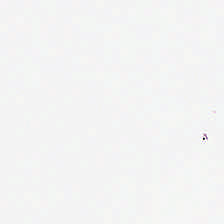

In [38]:
# [1120. 1344.] [4704. 4928.]
region_select = (4704, 1120, 4928, 1344)
full_sect = os_obj.read_region(level=0, size=(224,224), location=(1120,4704))
display(full_sect)

<class 'PIL.Image.Image'> (2875, 2057)
<class 'PIL.Image.Image'> (2675, 1657)


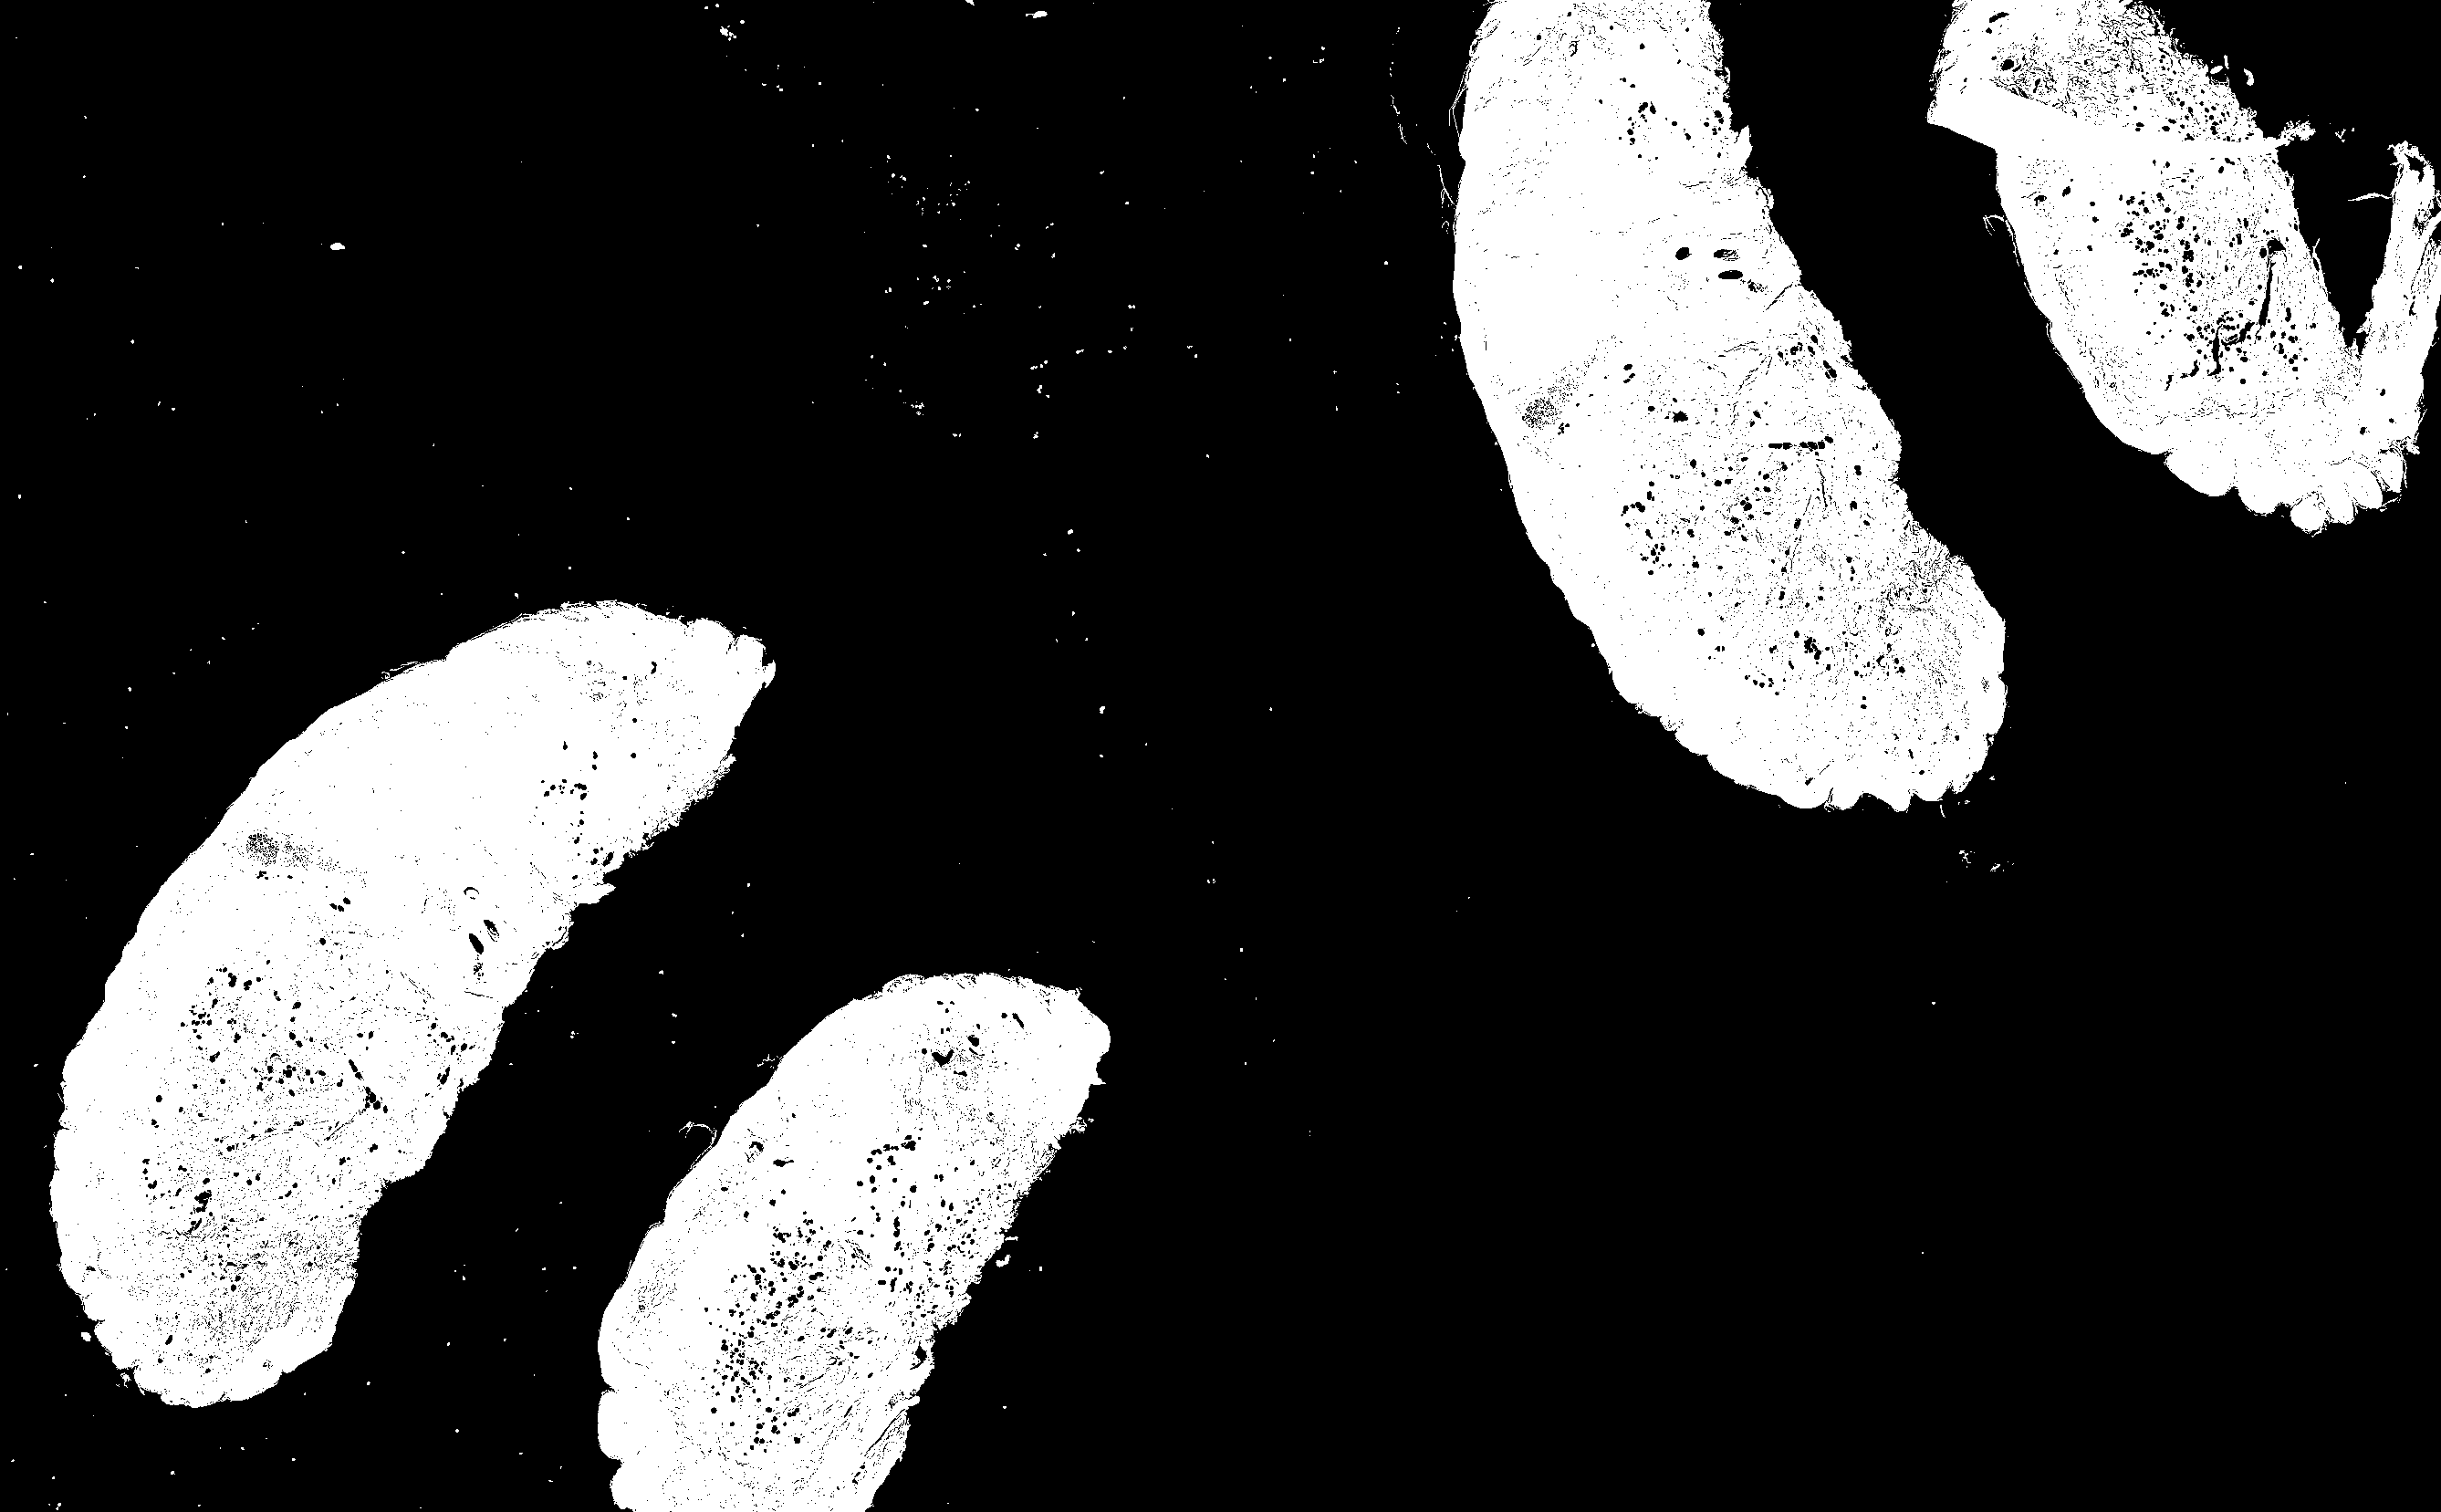

In [14]:
from PIL import ImageOps
print(type(mask_im),mask_im.size)
sec_select = (100, 200, 100, 200)
sm_sect = ImageOps.crop(mask_im, sec_select)
print(type(sm_sect),sm_sect.size)
display(sm_sect)

In [13]:
print(type(mask_im),mask_im.size)

<class 'PIL.Image.Image'> (2875, 2057)



```python
MAXPATCHESTOWRITE = 1000
import glob
import math
import os
import numpy as np
import openslide
from skimage.filters import threshold_otsu

def get_thumbnail(img, x_level0, y_level0, patch_size, output_path):
    patch = img.read_region((x_level0, y_level0), 0, (patch_size, patch_size))
    patch = patch.convert('RGB')
    fname = img.properties['aperio.Filename'].replace(' ', '_')
    fname += '_' + str(x_level0)
    fname += '_' + str(y_level0)
    fname += '_' + '0'
    fname += '_' + str(patch_size)
    fname += '.jpg'
    patch_arr = np.array(patch.convert('L'))
    if np.average(patch_arr) < 230:
        global num_patches
        num_patches += 1
        patch.save(os.path.join(output_path, fname))

def process_svs(SVS,
                normalization_factor=1000,
                patch_size=512,
                buffer=10,
                output_path=OUTPUT_PATH):
    img = openslide.OpenSlide(SVS)

    global num_patches
    num_patches = 0

    x_max, y_max = img.dimensions
    thumbnail = img.get_thumbnail((normalization_factor, normalization_factor))

    grey_thumbnail = np.array(thumbnail.convert("L"))
    thresh = threshold_otsu(grey_thumbnail)
    mask = np.array(grey_thumbnail) < thresh

    # how many pixels in the raw image per pixel in mask
    x_num_orgPix_per_thumbPix = math.ceil(x_max / mask.shape[0])
    y_num_orgPix_per_thumbPix = math.ceil(y_max / mask.shape[1])
    # print(x_num_orgPix_per_thumbPix, y_num_orgPix_per_thumbPix)

    # Find out how many pixels in image mask to count as a patch in original
    num_x_mask_pixels_per_rawPatch = math.ceil(patch_size / x_num_orgPix_per_thumbPix)
    num_y_mask_pixels_per_rawPatch = math.ceil(patch_size / y_num_orgPix_per_thumbPix)
    # print(num_x_mask_pixels_per_rawPatch, num_y_mask_pixels_per_rawPatch)

    mask_x, mask_y = mask.shape
    x_mask_prev = 0

    # Iterate through the mask to identify positive pixels
    for x in range(buffer, mask_x - buffer):
        x_mask_window = x + num_x_mask_pixels_per_rawPatch
        if x_mask_window <= x_mask_prev:
            continue
        y_mask_prev = 0
        for y in range(buffer, mask_y - buffer):
            y_mask_window = y + num_y_mask_pixels_per_rawPatch
            # print('Evaluate: {} {} & {}'.format(y, y_mask_window, y_mask_prev))
            if y_mask_window <= y_mask_prev:
                continue
            if y % 100 == 0:
                print('X: {}\tY:{} of {} with total of {} so far'.format(x, y, 
                                                                         mask.shape, 
                                                                         num_patches), end='\r',
                                                                  flush=True)
                
            if np.sum(mask[x:x_mask_window, y:y_mask_window]) > 0:
                # convert mask coordinates to level0 coordinates
                x_level0 = x * x_num_orgPix_per_thumbPix
                y_level0 = y * y_num_orgPix_per_thumbPix
                get_thumbnail(img, x_level0, y_level0, patch_size, output_path)
                
                #                                      <0><0>          Limit number of files
                if num_patches >= MAXPATCHESTOWRITE:
                    print('\n\n\t{} num_patched out\n\n'.format(num_patches))
                    return
                #                                      <0><0>

            # print('yamsk windoe: {}'.format(y_mask_window))
            y_mask_prev = y_mask_window
        x_mask_prev = x_mask_window

    print('Printed {} from {}'.format(num_patches, SVS))

num_patches = 0
"""
# if __name__ == '__main__':
#     for SVS in glob.glob('/data/biliary/svs/negative/*svs'):
#         process_svs(SVS)
"""
print('processing: {}'.format(SVS))
process_svs(SVS)
```